<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [20]:
# Load the data
house = pd.read_csv('../housing.csv')
house.drop('Id',axis=1,inplace=True)

In [21]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = house.select_dtypes(include = ["object"]).columns
numerical_features = house.select_dtypes(exclude = ["object"]).columns
# numerical_features = numerical_features.drop("SalePrice")
print(numerical_features)
print("Numerical features : " + str(len(numerical_features)))
print(categorical_features)
print("Categorical features : " + str(len(categorical_features)))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Numerical features : 37
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
 

In [22]:
#transforming some misclassified categorical values back to object type
misscl = ['YearBuilt','GarageYrBlt','YearRemodAdd','MoSold']
for item in misscl:
    house[item] = house[item].astype(str)
categorical_features = house.select_dtypes(include = ["object"]).columns
numerical_features = house.select_dtypes(exclude = ["object"]).columns
# numerical_features = numerical_features.drop("SalePrice")
print(numerical_features)
print("Numerical features : " + str(len(numerical_features)))
print(categorical_features)
print("Categorical features : " + str(len(categorical_features)))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'YrSold', 'SalePrice'],
      dtype='object')
Numerical features : 33
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'C

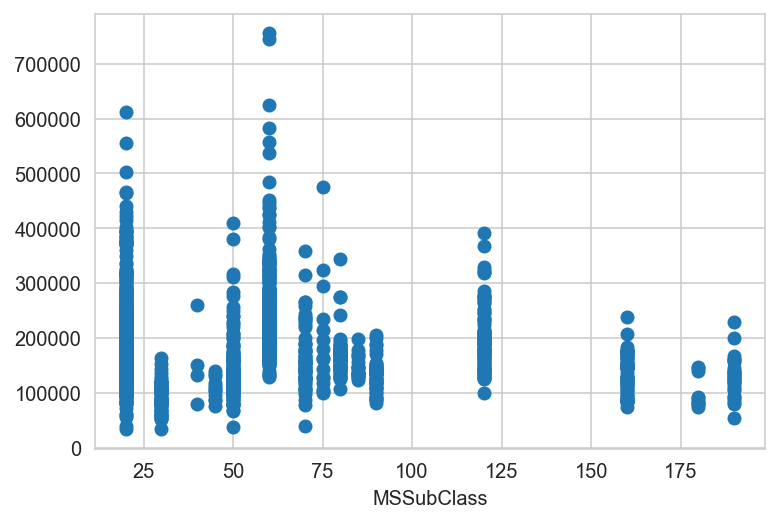

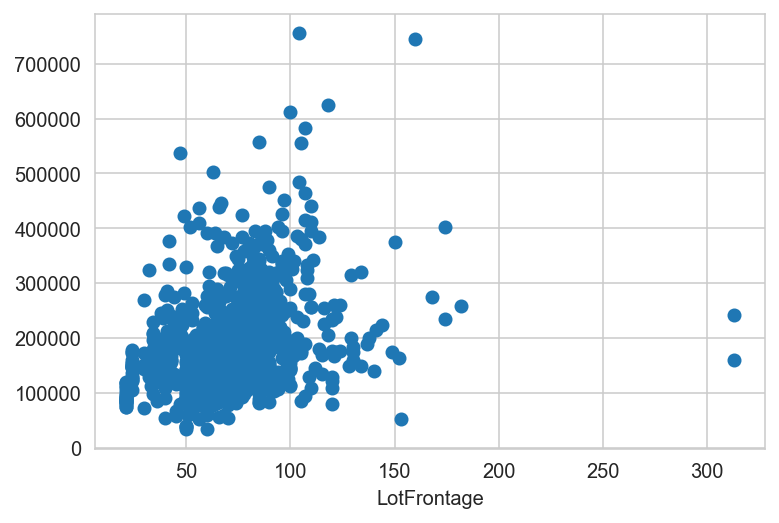

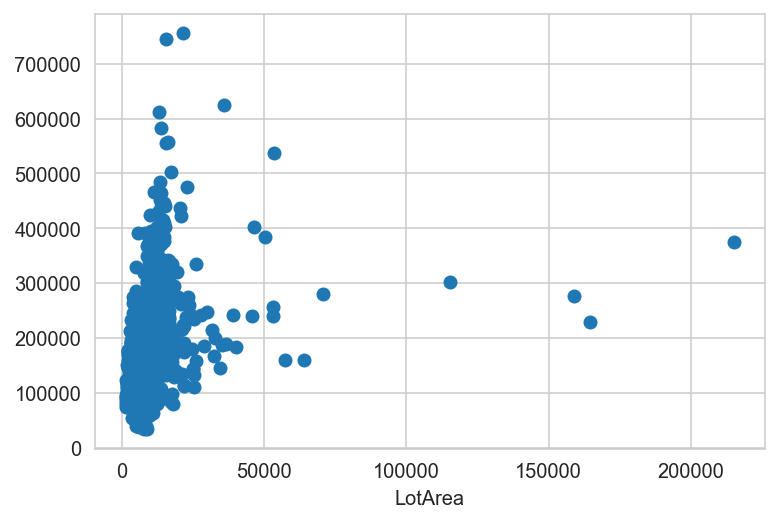

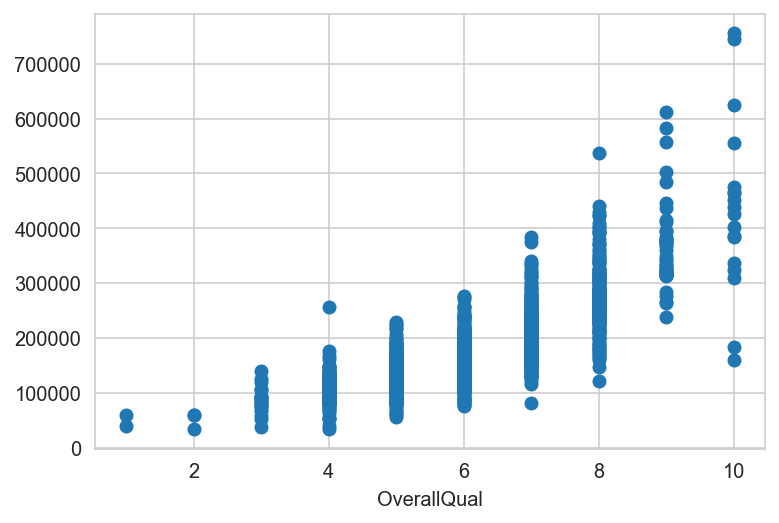

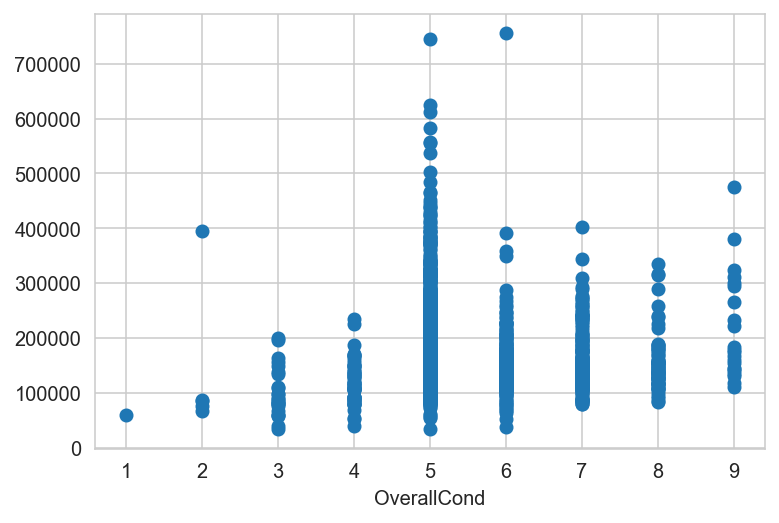

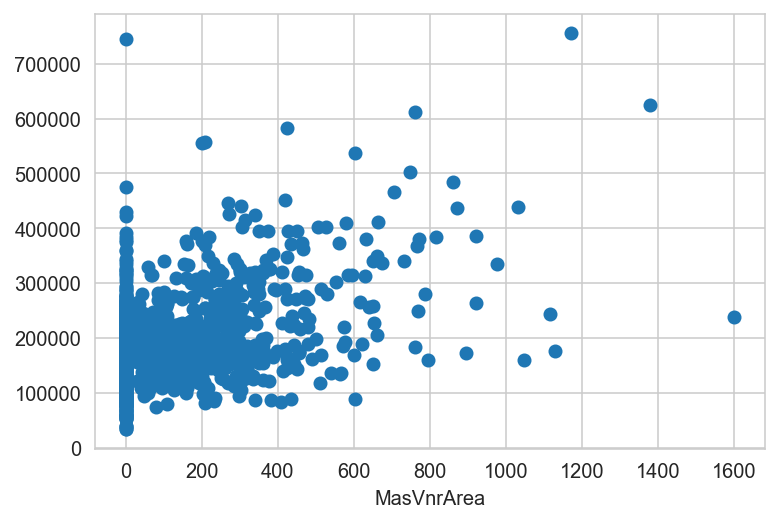

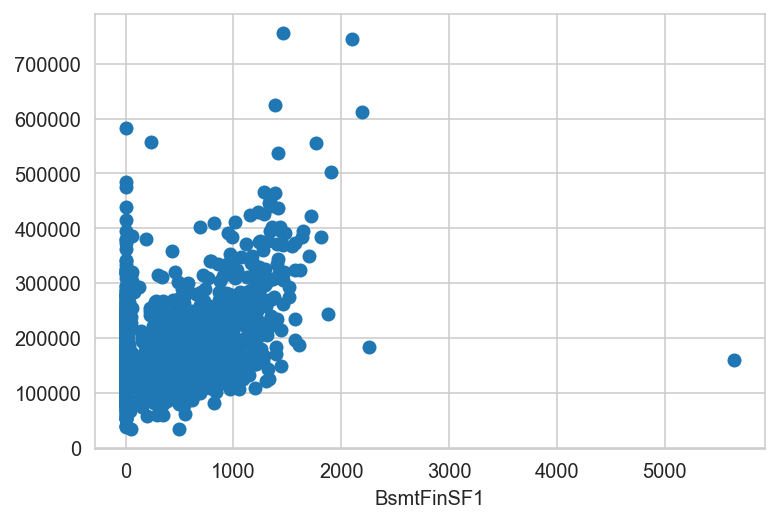

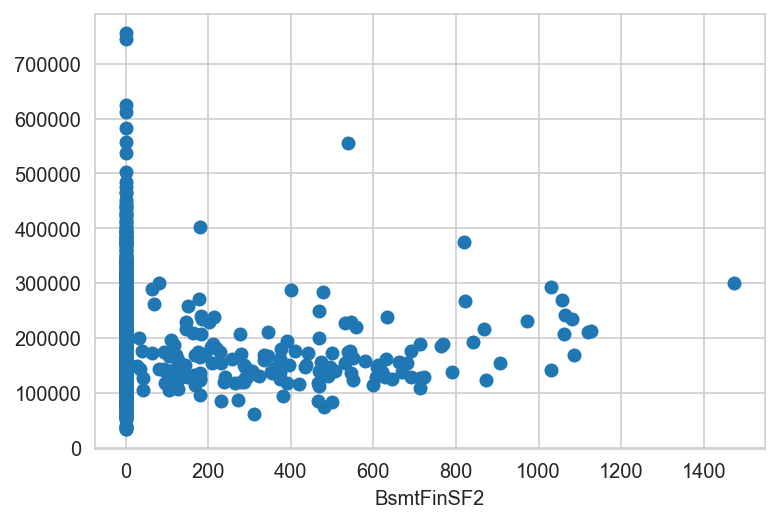

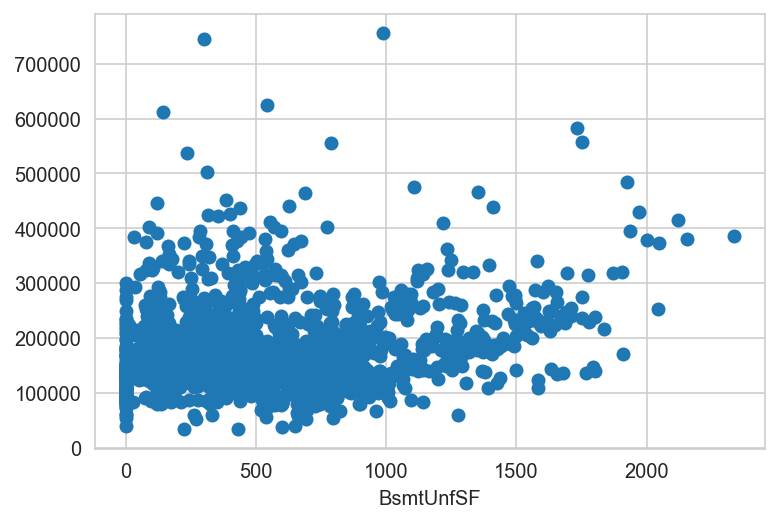

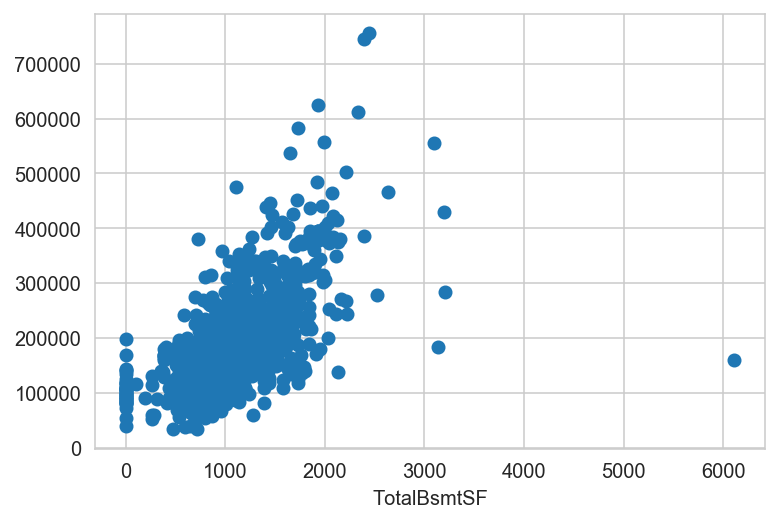

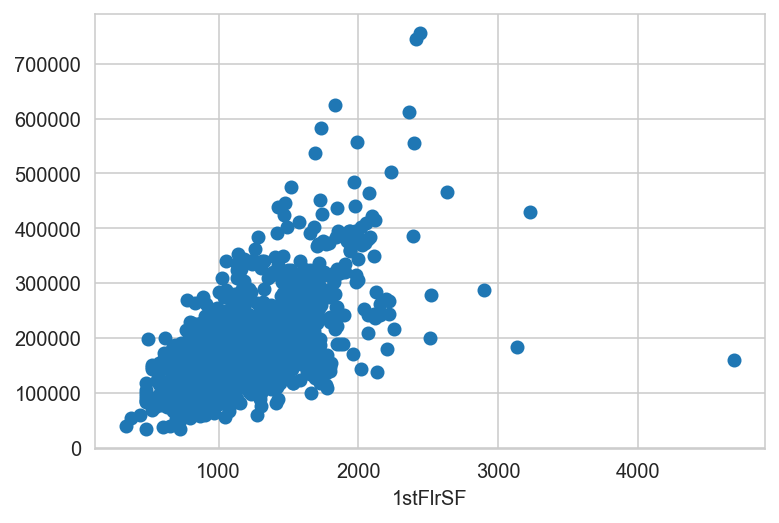

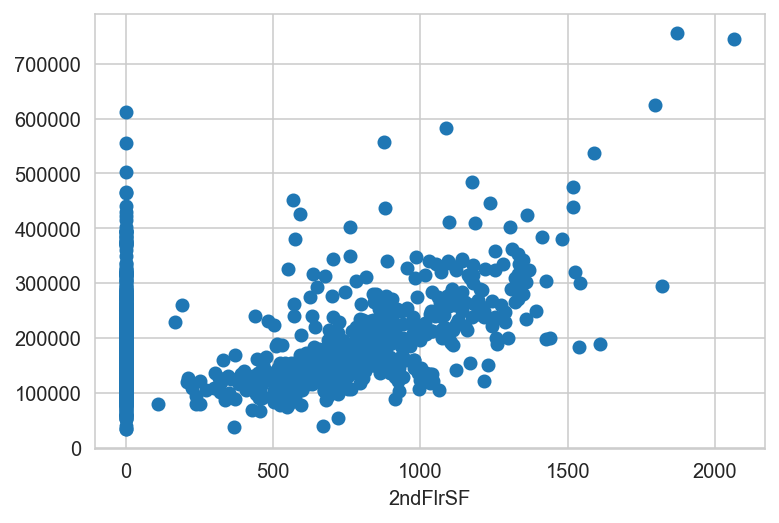

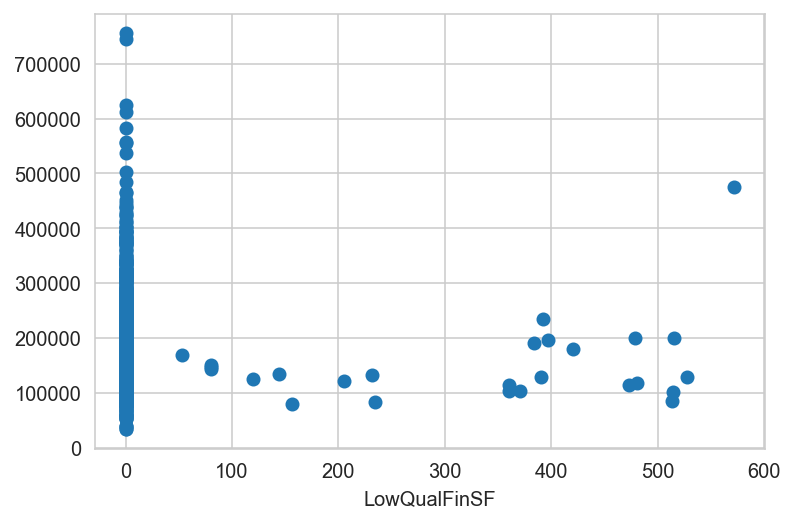

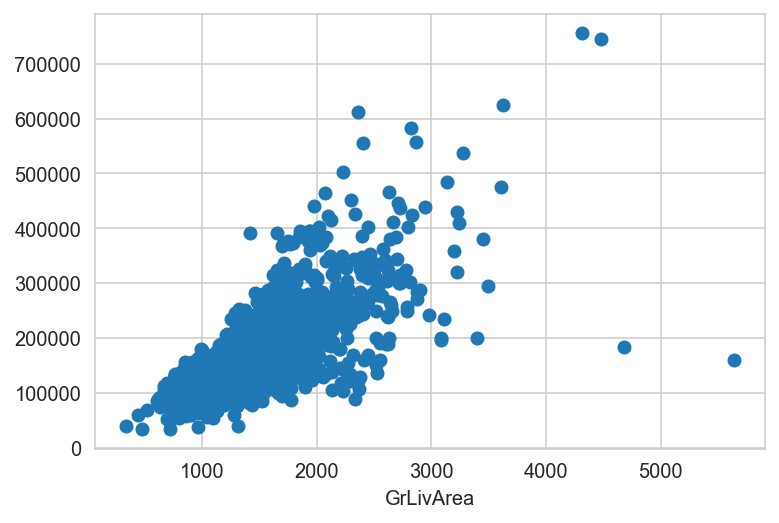

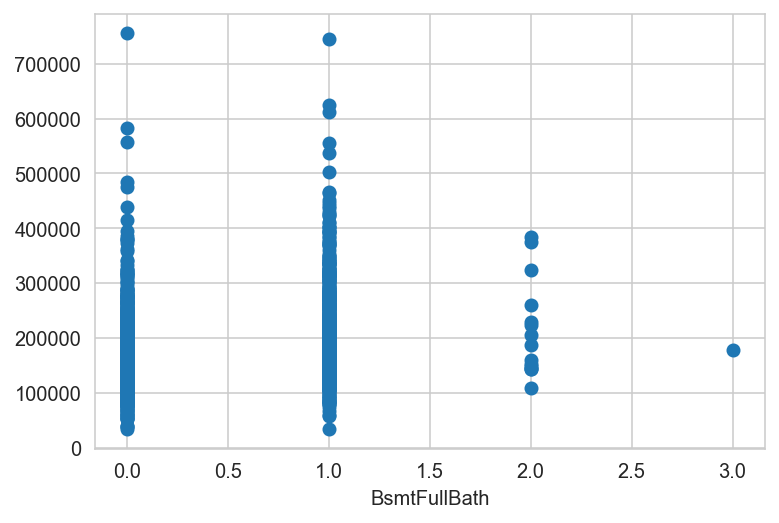

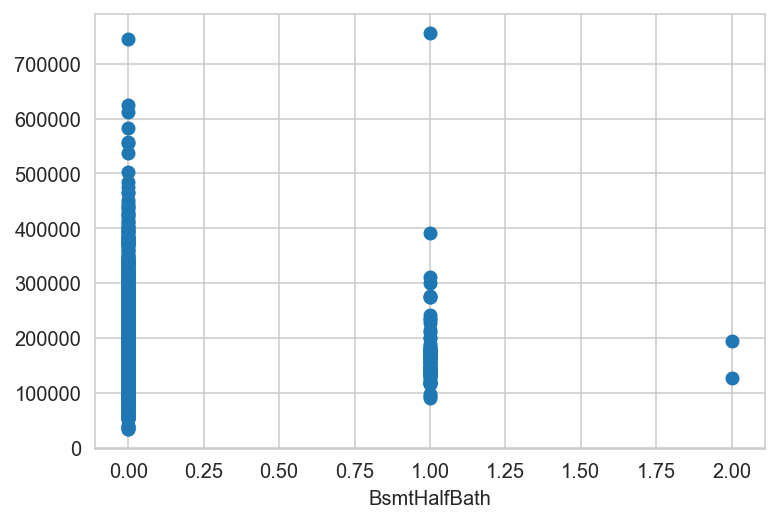

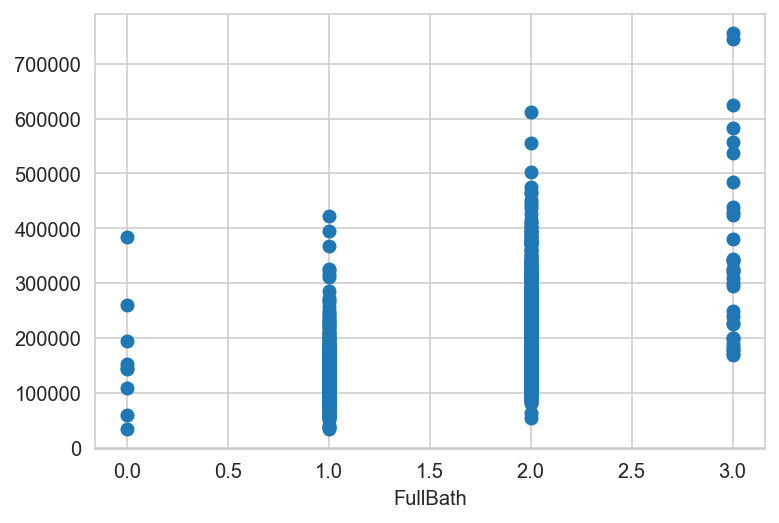

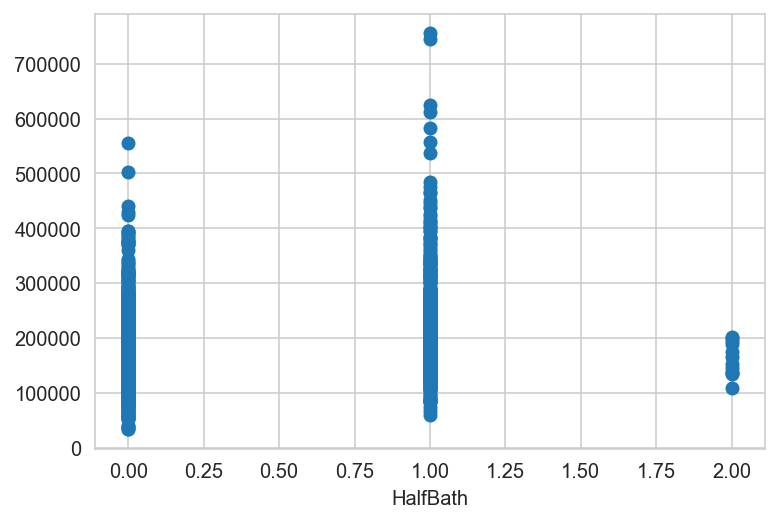

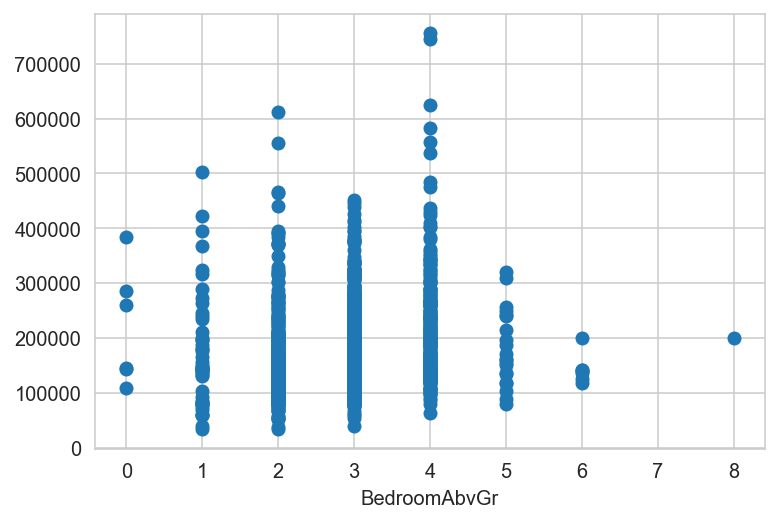

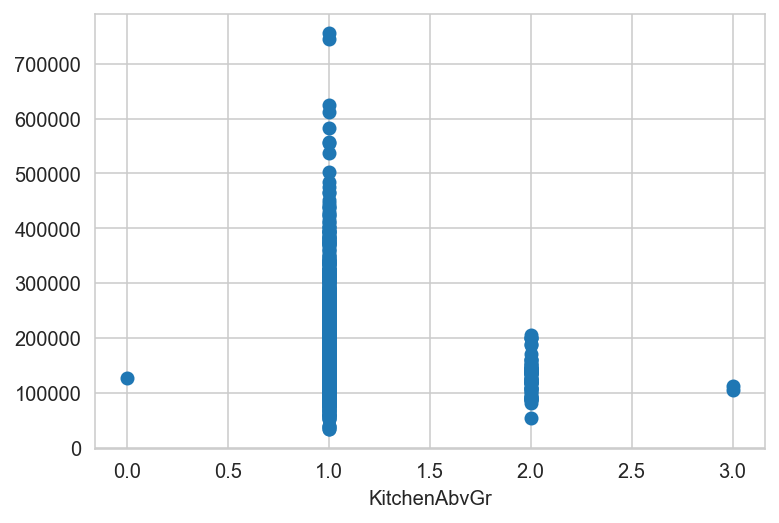

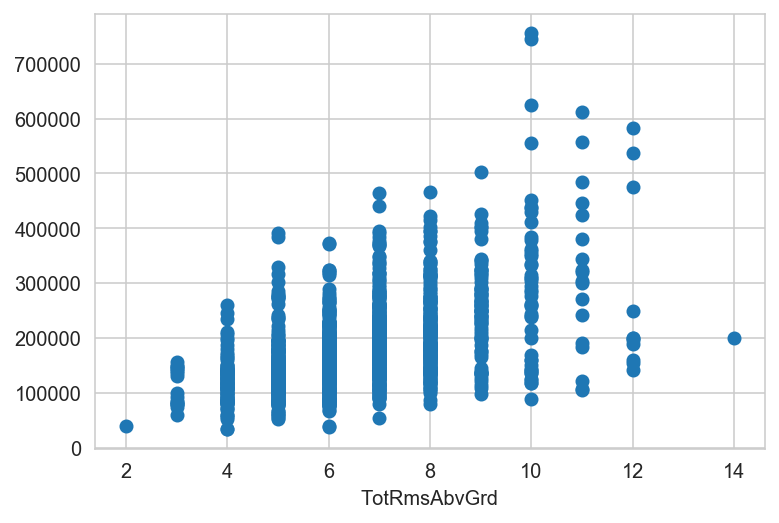

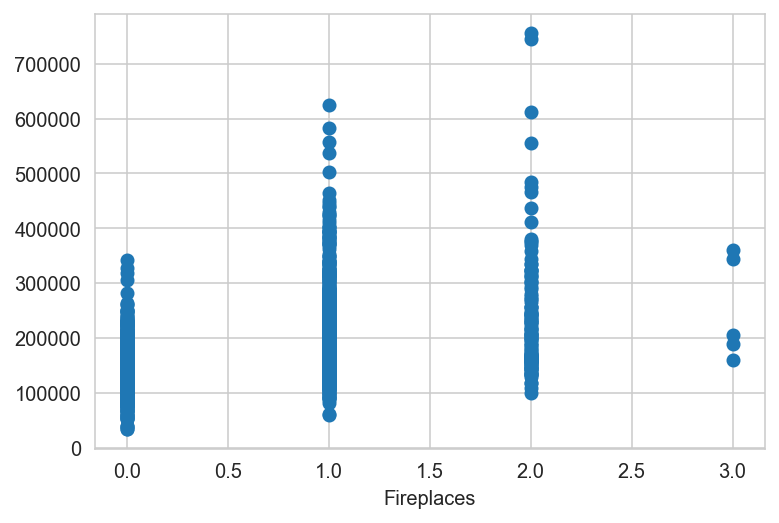

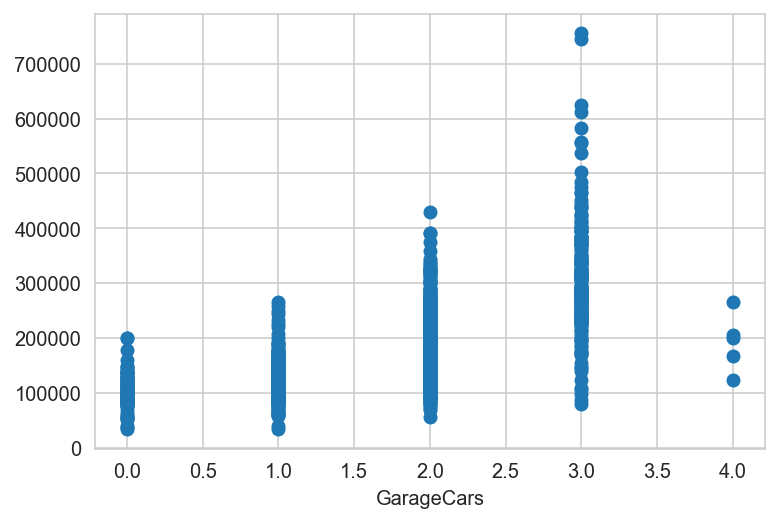

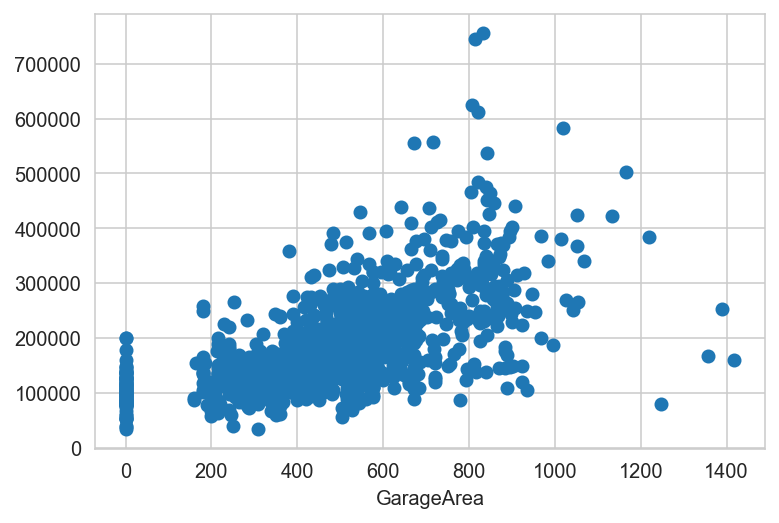

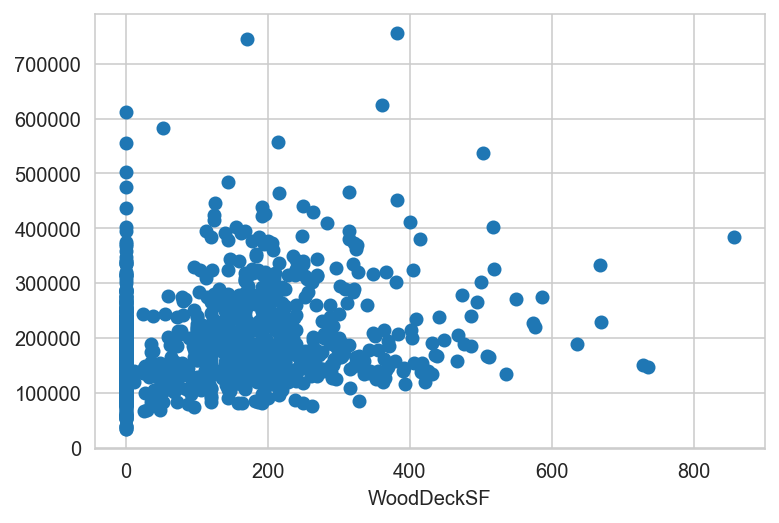

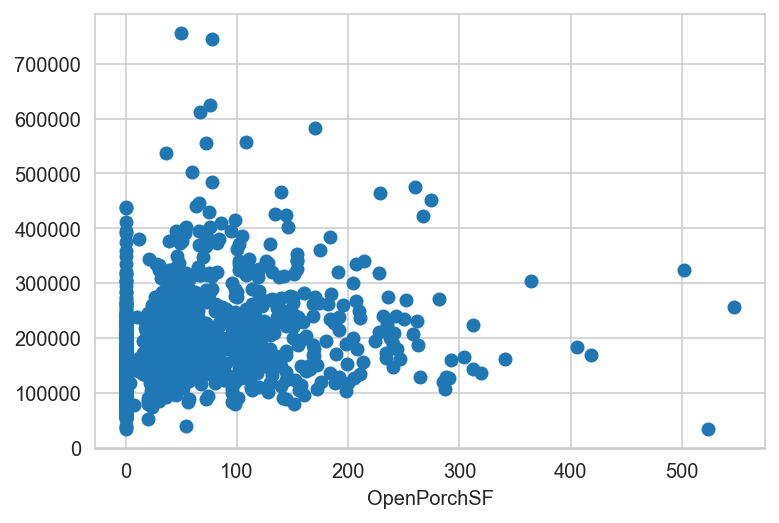

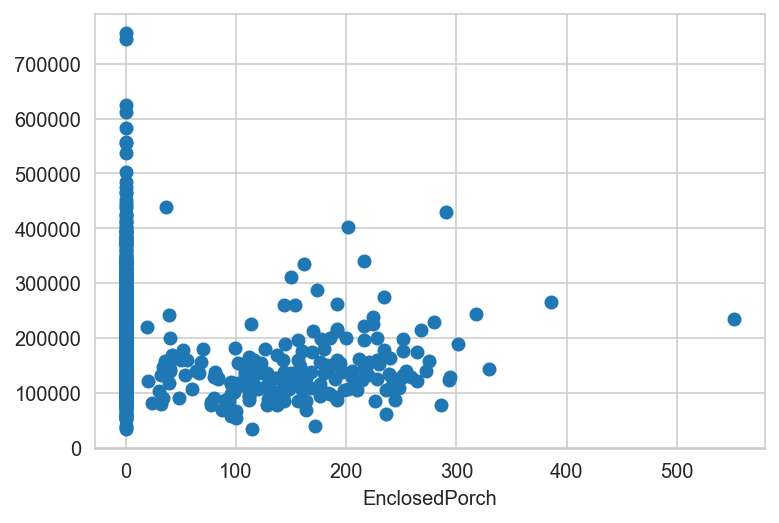

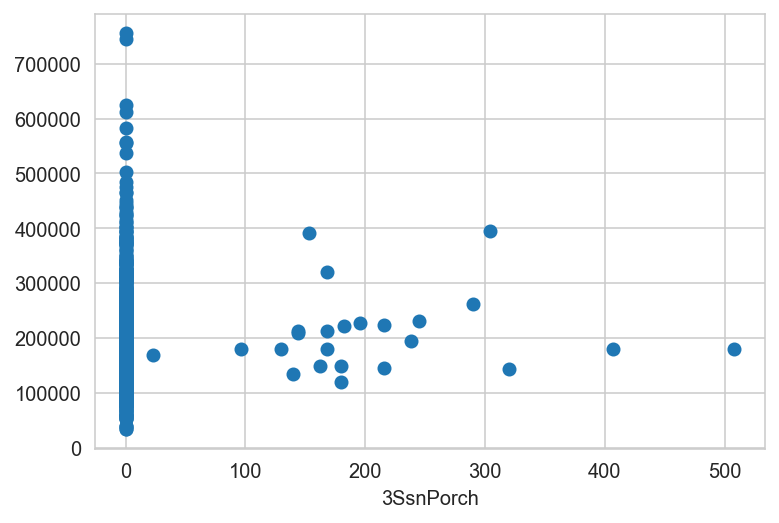

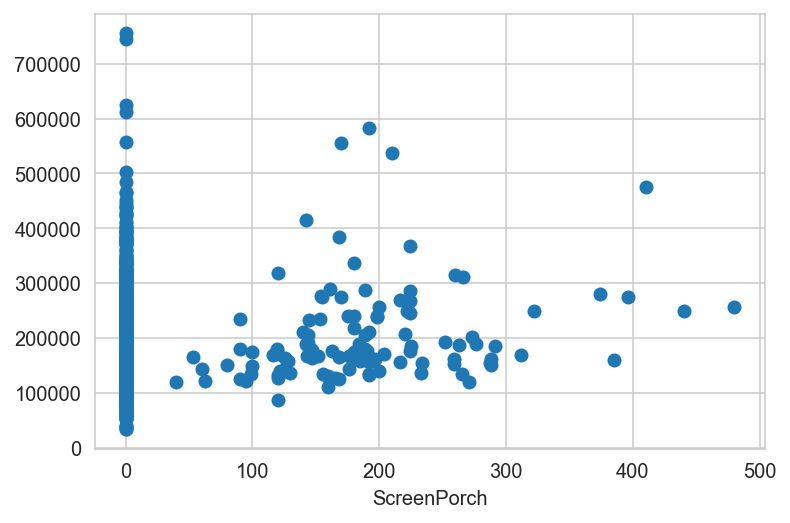

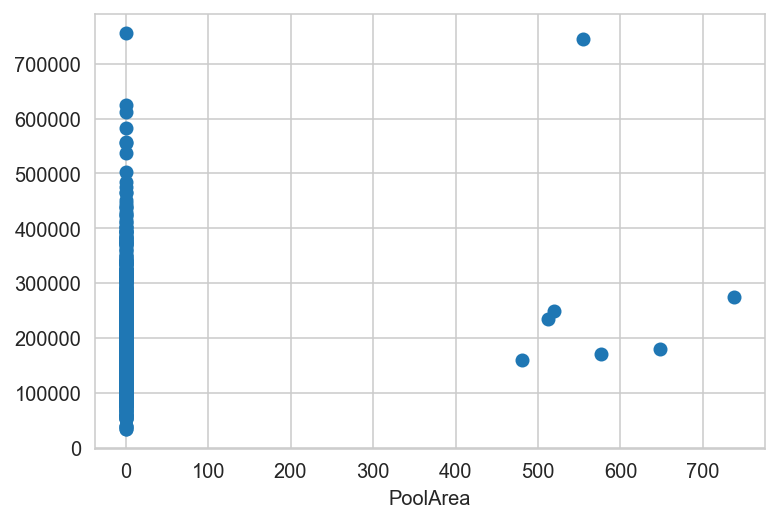

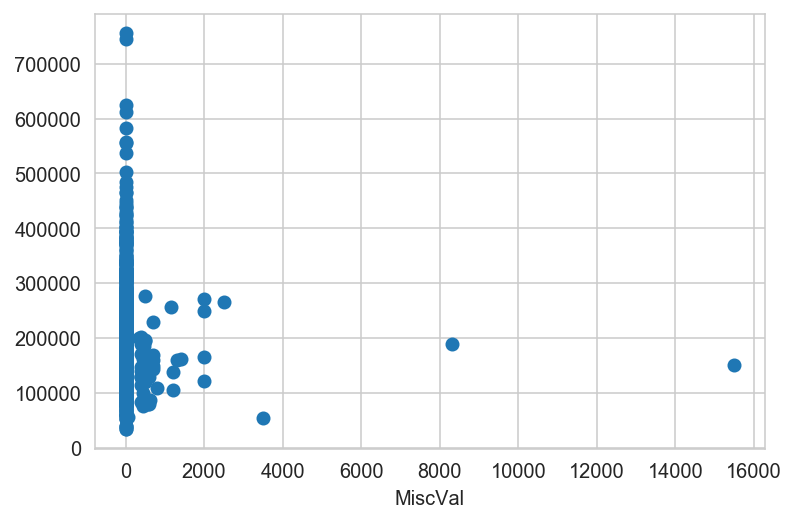

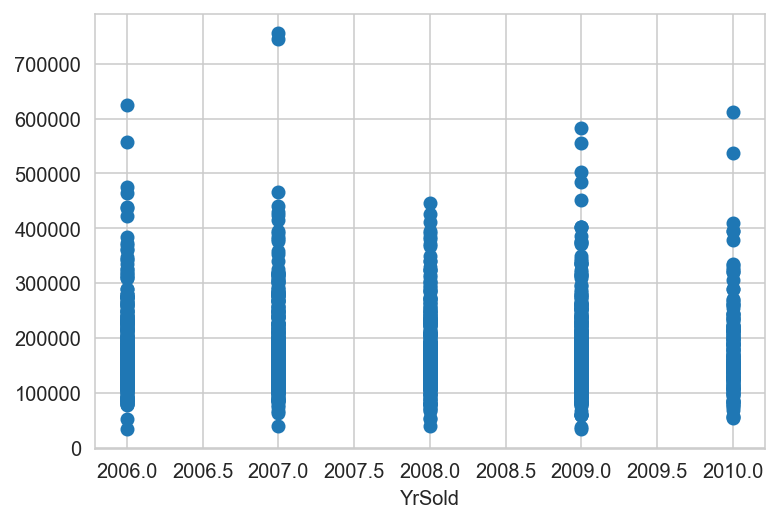

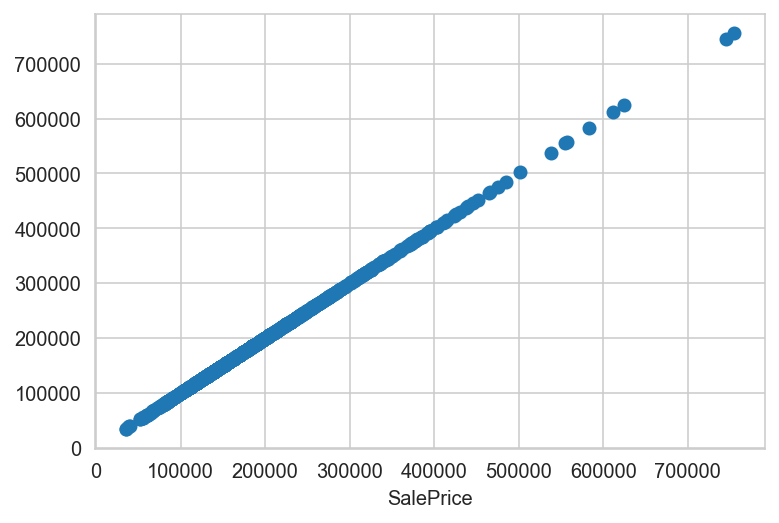

In [16]:
#Reviewing numeric columns and try to drop outliers:
for item in numerical_features:
    plt.scatter(house[item],house['SalePrice'])
    plt.xlabel(item)
    plt.show()

In [24]:
#drop LotFrontage > 300
a = house[(house.LotFrontage > 300) & (house.SalePrice < 300000)].index
print(a)
#drop LotArea > 100000
b = house[(house.LotArea > 100000) & (house.SalePrice < 300000)].index
print(b)
#drop BsmtFinSF1 > 5000
c = house[(house.BsmtFinSF1 > 5000) & (house.SalePrice < 300000)].index
print(c)
#drop TotalBsmtSF > 6000
d = house[(house.TotalBsmtSF > 6000) & (house.SalePrice < 300000)].index
print(d)
#drop 1stFlrSF >4000
e = house[(house['1stFlrSF'] > 4000) & (house.SalePrice < 300000)].index
print(e)
#drop GrLivArea > 4000 and price < 200000
f = house[(house['GrLivArea'] > 4000) & (house.SalePrice < 300000)].index
print(f)

#Drop BedroomAbvGr > 8
g = house[(house.BedroomAbvGr > 7) & (house.SalePrice < 300000)].index
print(g)
#Drop KitchenAbvGr > 3
h = house[(house.KitchenAbvGr >= 3) & (house.SalePrice < 300000)].index
print(h)
#Drop TotRmsAbvGrd > 14
i = house[(house.TotRmsAbvGrd >= 14) & (house.SalePrice < 300000)].index
print(i)
#Drop FirePlaces >3
j = house[(house.Fireplaces >= 3) & (house.SalePrice < 300000)].index
print(j)
#Drop GarageCars >=4
k = house[(house.GarageCars >= 4) & (house.SalePrice < 300000)].index
print(k)
#Drop OpenPrchSF > 450
l = house[(house.OpenPorchSF >= 450) & (house.SalePrice < 300000)].index
print(l)
#Drop All Porch parameters
#Drop All Poor parameters
#Drop MiscVal 

finalout = a.append(b).append(c).append(d).append(e).append(f).append(g).append(h).append(i).append(j).append(k).append(l)
finalout.value_counts()

Int64Index([934, 1298], dtype='int64')
Int64Index([249, 335], dtype='int64')
Int64Index([1298], dtype='int64')
Int64Index([1298], dtype='int64')
Int64Index([1298], dtype='int64')
Int64Index([523, 1298], dtype='int64')
Int64Index([635], dtype='int64')
Int64Index([48, 809], dtype='int64')
Int64Index([635], dtype='int64')
Int64Index([166, 605, 1298], dtype='int64')
Int64Index([420, 747, 1190, 1340, 1350], dtype='int64')
Int64Index([495, 1328], dtype='int64')


1298    6
635     2
1190    1
495     1
934     1
809     1
523     1
335     1
48      1
166     1
605     1
1328    1
1350    1
249     1
747     1
1340    1
420     1
dtype: int64

In [25]:
print(house.iloc[finalout.value_counts().index,:])

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298          60       RL        313.0    63887   Pave   NaN      IR3   
635          190       RH         60.0    10896   Pave  Pave      Reg   
1190         190       RL          NaN    32463   Pave   NaN      Reg   
495           30  C (all)         60.0     7879   Pave   NaN      Reg   
934           20       RL        313.0    27650   Pave   NaN      IR2   
809           75       RM         90.0     8100   Pave   NaN      Reg   
523           60       RL        130.0    40094   Pave   NaN      IR1   
335          190       RL          NaN   164660   Grvl   NaN      IR1   
48           190       RM         33.0     4456   Pave   NaN      Reg   
166           20       RL          NaN    10708   Pave   NaN      IR1   
605           60       RL         85.0    13600   Pave   NaN      Reg   
1328          50       RM         60.0    10440   Pave  Grvl      Reg   
1350          90       RL         91.0    11643   P

In [26]:
house.drop(finalout.value_counts().index,inplace=True)
house.shape

(1443, 80)

In [27]:
#Check all Sales condition abnormal items
house[house['SaleCondition'] == 'Abnormal']
#No abnormal house sale were left at least

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows x 80 columns]

In [ ]:
# # First drop all the fixable variables
# #Quality columns
# Qualc = house.filter(like = 'Qual', axis =1).columns.values
# print(Qualc)
# Condc = house.filter(like = 'Cond', axis = 1).columns.values
# print(Condc)

In [28]:
#Merge BsmtBath and BsmtHalfBath and convert it to Categorical feature
house['TotalBsmtBath'] = house['BsmtFullBath'] + house['BsmtHalfBath']
house.drop(['BsmtFullBath','BsmtHalfBath'],axis=1,inplace=True)
#Merge FullBath and HalfBath
house['TotalBath'] = house['FullBath'] + house['HalfBath']
house.drop(['FullBath','HalfBath'],axis=1,inplace=True)
#Merge BsmtFinSF1 and BsmtFinSF2
#house['BsmtFinSF'] = house['BsmtFinSF1'] + house['BsmtFinSF2']
house.drop(['BsmtFinSF1','BsmtFinSF2'],axis=1,inplace=True)
#TotalSF
house['TotalSF'] = house['GrLivArea']+house['TotalBsmtSF']

In [29]:
#drop fixable columns functions:
#We want to drop all quality and condition columns, electrical 
#and heating components, Roof and exterior styles, fire and fence
droptarget = ['Qual', 'Cond', 'Heat', 'Electr','Roof','Exteri','Fire','Fence','Air','QC','Year','Yr']

def dropc(df,ls):
    for i in ls:
        dropcl = df.select_dtypes(include='object').filter(like = i, axis=1).columns.values
        df.drop(dropcl, axis = 1, inplace=True)
    return df

fixhouse = dropc(house,droptarget)
print(fixhouse.columns)
#Column of LowQualFinSF is dropped despite it is a numeric column, other than a category one.


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SalePrice',
       'TotalBsmtBath', 'TotalBath', 'TotalSF'],
      dtype='object')


In [30]:
#drop non residential properties:
fixhouse.MSZoning.value_counts()
fixhouse1 = fixhouse[~(fixhouse.MSZoning == 'C (all)')]
fixhouse1.MSZoning.value_counts()

RL    1141
RM     213
FV      65
RH      15
Name: MSZoning, dtype: int64

In [31]:
#profile2 = pandas_profiling.ProfileReport(fixhouse1)
#profile2

In [32]:
#Drop missing value for categoral feature > 90%
fixhouse1.isnull().sum()
fixhouse2 = fixhouse1.drop(columns =['Alley','MiscFeature'])
fixhouse2.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      255
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
MasVnrType         8
MasVnrArea         8
Foundation         0
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
GarageType        77
GarageFinish      77
GarageCars         0
GarageArea         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SalePrice    

In [ ]:
# profile3 = pandas_profiling.ProfileReport(fixhouse2)
# profile3


In [ ]:
# #Generate a new feature to calculate the total surface, so when the 2nd Floor is 0 sqft, the data will not be affecting
# #the model.
# fixhouse2['TotalFlrSF'] = fixhouse2['1stFlrSF'] + fixhouse2['2ndFlrSF']
# #BedroomAbvGr should be imputed with relative number to the surface
# sns.pairplot(fixhouse2[['TotalFlrSF','SalePrice']])
# #We have seen two very obvious outliers with large surface yet really low sale prices
# fixhouse2[((fixhouse2['TotalFlrSF']>4000) & (fixhouse2['SalePrice']<210000))].T
# fixhouse2.drop([523,1298],axis=0,inplace=True)
# print(fixhouse2.shape)

In [ ]:
# sns.pairplot(fixhouse2[['TotalFlrSF','SalePrice']])

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive',
       'YrSold', 'SaleType', 'TotalBsmtBath', 'TotalBath', 'TotalSF'],
      dtype='object')


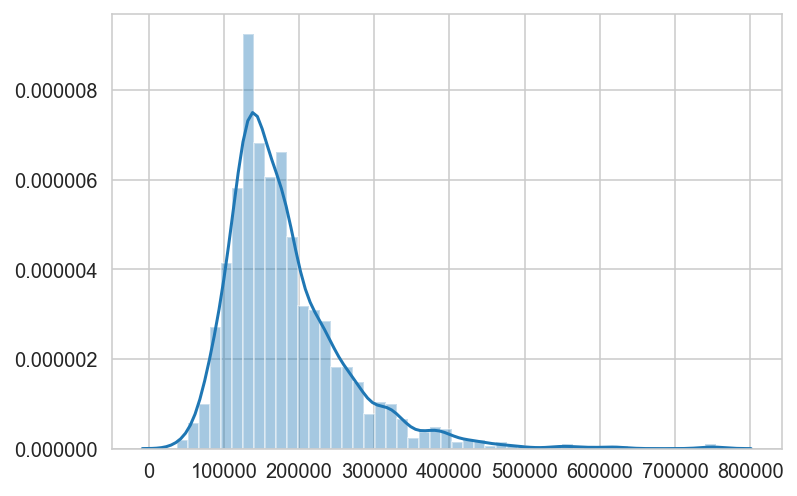

In [33]:
#separate data and target, droping unwanted features especially those with more than 95% 0 values.
#1st floor and 2nd floor surface area are both dropped due to the sum 
#is highly correlated with GrLiveArea and 2ndFlrSF 
#has too many zeros
X = fixhouse2.drop(['SalePrice','1stFlrSF', '2ndFlrSF'], axis=1)
#drop features with a lot zeros and not much meaning to impute
#drop features that has too many zero and broke the ElasticNet and Lasso Model REFCV
X = X.drop(['PoolArea','3SsnPorch','MiscVal','MoSold','ScreenPorch',
            'EnclosedPorch','OpenPorchSF','WoodDeckSF','MasVnrArea','LowQualFinSF'], axis=1)
#print(X.head().T)
y = fixhouse2.SalePrice.values
#check Target normality
sns.distplot(y)
X.YrSold = X.YrSold.astype(str)
print(X.columns)

In [34]:
#find nueric skew features
numeric_feats = X.dtypes[X.dtypes != "object"].index
print(numeric_feats)
from scipy.stats import norm, skew, boxcox
#Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.info()

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
       'TotalBsmtBath', 'TotalBath', 'TotalSF'],
      dtype='object')

Skew in numerical features: 

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, LotArea to GarageCars
Data columns (total 1 columns):
Skew    17 non-null float64
dtypes: float64(1)
memory usage: 272.0+ bytes


In [35]:
#Removing high skewness from features
skewness = skewness[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X[feat] = boxcox1p(X[feat], lam)
X.YrSold.value_counts()

There are 6 skewed numerical features to Box Cox transform


2009    330
2007    323
2006    312
2008    297
2010    172
Name: YrSold, dtype: int64

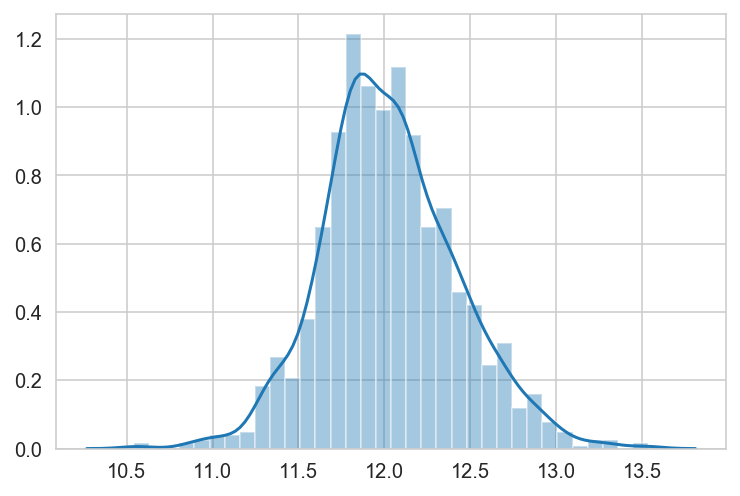

In [36]:
#Check normality of the new target
y = np.log1p(y)
sns.distplot(y)

In [37]:
#imputing NA values for certain columns before processing categoral features
X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish'):
    X[col] = X[col].fillna('None')
for col in ('BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X[col] = X[col].fillna('None')
X["MasVnrType"] = X["MasVnrType"].fillna("None")
#X["MasVnrArea"] = X["MasVnrArea"].fillna(0)
X.YrSold.head(20)

0     2008
1     2007
2     2008
3     2006
4     2008
5     2009
6     2007
7     2009
8     2008
9     2008
10    2008
11    2006
12    2008
13    2007
14    2008
15    2007
16    2010
17    2006
18    2008
19    2009
Name: YrSold, dtype: object

In [38]:
cat = X.select_dtypes(include='object').columns
cat
catdrop = []
for i in cat.values:
    if X[i].nunique() > 8:
        catdrop.append(i)
print(catdrop)
X.drop(catdrop,axis=1,inplace=True)
cat = X.select_dtypes(include='object').columns
cat

['Neighborhood', 'SaleType']


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'MasVnrType',
       'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'YrSold'],
      dtype='object')

In [39]:
#LabelEncoder on features to keep information in the ordering categories
from sklearn.preprocessing import LabelEncoder
cols = X.select_dtypes(include='object')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(X[c].values)) 
    X[c] = lbl.transform(list(X[c].values)).astype(str)

In [40]:
#One hot enconding for categoral features
cols = list(X.columns)
X = pd.get_dummies(X,drop_first=True)
X.shape

(1434, 90)

(1262, 90)
(172, 90)
13.534474352733596
1262
172
13.323928581764989


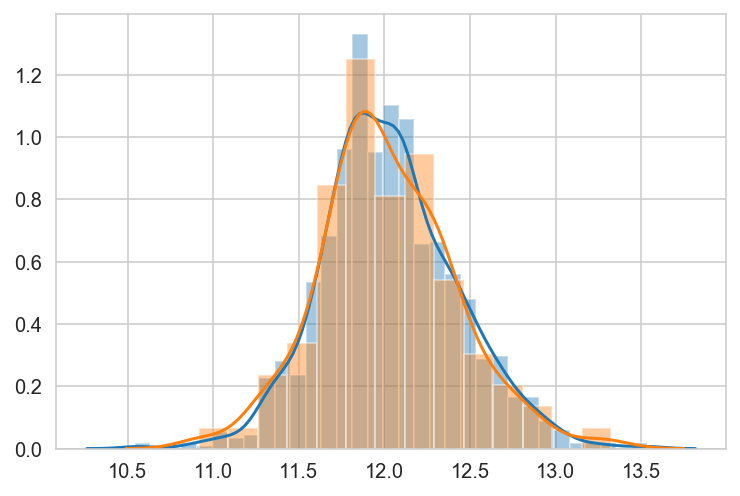

In [41]:
#### Split the train and test dataset based on the year 2010, which was labelencoded as 4\
#and one hot code split as YrSold_4
train = X[X.YrSold_4 == 0]
print(train.shape)
test = X[X.YrSold_4 == 1]
print(test.shape)
y_train = y[X.YrSold_4 == 0]
sns.distplot(y_train)
print(y_train.max())
print(len(y_train))
y_test = y[X.YrSold_4 == 1]
print(len(y_test))
sns.distplot(y_test)
print(y_test.max())

In [42]:
#drop all the yrsold columns, Year sold is a data leakage column, 
#the year will only be known once the property is sold
yrcol = train.filter(like = 'YrSold', axis=1).columns.values
yrcol
train = train.drop(yrcol, axis=1)
test = test.drop(yrcol,axis=1)
print(train.shape)
print(test.shape)

(1262, 86)
(172, 86)


In [43]:
#Standardize the data for linear regression
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
print(numeric_feats)
train[numeric_feats] = scaler.fit_transform(train[numeric_feats])
print(train.shape)
test[numeric_feats] = scaler.fit_transform(test[numeric_feats])
print(test.shape)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
       'TotalBsmtBath', 'TotalBath', 'TotalSF'],
      dtype='object')
(1262, 86)
(172, 86)


Optimal number of features : 15


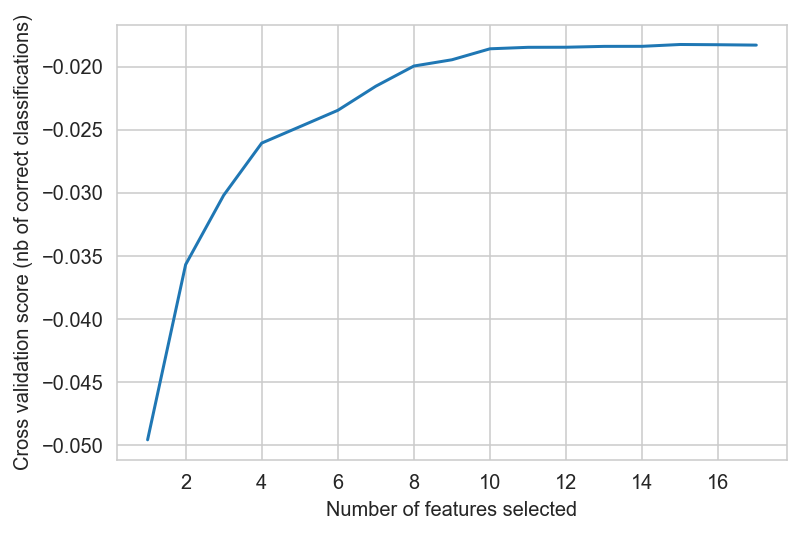

Index(['LotArea', 'OverallQual', 'OverallCond', 'BsmtUnfSF', 'TotalBsmtSF',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'TotalBsmtBath', 'TotalBath',
       'TotalSF'],
      dtype='object')
15
['MSSubClass', 'LotFrontage']
2


In [44]:
#use recursive feature selection cross validation
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression,ElasticNet,Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
model = LinearRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=5,
              scoring='neg_mean_squared_error')
rfecv.fit(train[numeric_feats], y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
numeric_selected = train.loc[:,rfecv.get_support()].columns
numeric_drop = []
for i in numeric_feats:
    if i not in numeric_selected:
        numeric_drop.append(i)
print(numeric_selected)
print(len(numeric_selected))
print(numeric_drop)
print(len(numeric_drop))

#Linearfeature = ['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 
# 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
# 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
# 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars',
# 'GarageArea']

Optimal number of features : 14


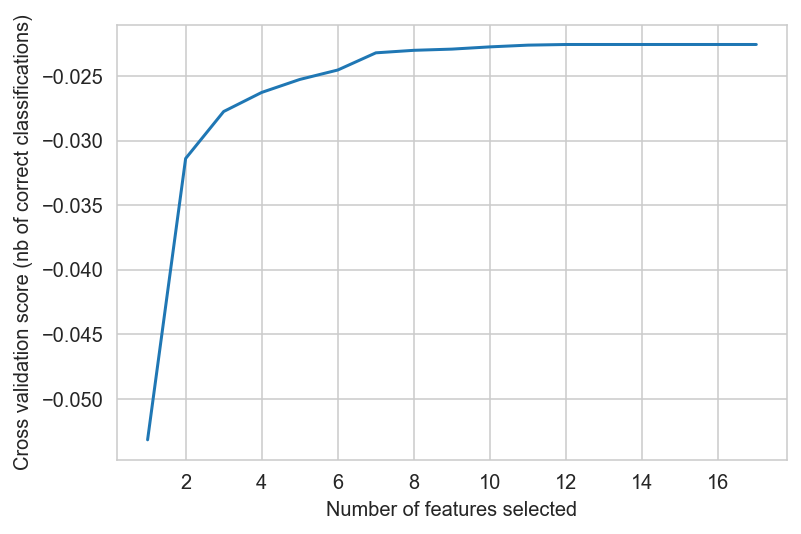

Index(['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'TotalBsmtBath', 'TotalBath', 'TotalSF'],
      dtype='object')
14
['MSSubClass', 'LotFrontage', 'BsmtUnfSF']
3


In [45]:
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
model = ElasticNet(alpha=0.05)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=5,
              scoring='neg_mean_squared_error')
rfecv.fit(train[numeric_feats], y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
numeric_selected = train.loc[:,rfecv.get_support()].columns
numeric_drop = []
for i in numeric_feats:
    if i not in numeric_selected:
        numeric_drop.append(i)
print(numeric_selected)
print(len(numeric_selected))
print(numeric_drop)
print(len(numeric_drop))

In [46]:
#check train dataset for categorical features:
#print(train.info())
cat2 = train.select_dtypes(include='uint8').columns
cat2
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
catBest = SelectKBest(f_classif, k=4).fit(train[cat2], y_train)
mask = catBest.get_support()
usefulcat = train.iloc[:,mask].columns
print(usefulcat)

Index(['BsmtUnfSF', 'LotShape_3', 'LotConfig_3', 'LandSlope_2'], dtype='object')


In [47]:
#combined the features selection from numerical REFCV and SelectKBest with f_classif
finalf = numeric_selected.append(usefulcat)
train2 = train[finalf]
test2 = test[finalf]
train2.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'TotalBsmtBath', 'TotalBath', 'TotalSF',
       'BsmtUnfSF', 'LotShape_3', 'LotConfig_3', 'LandSlope_2'],
      dtype='object')

In [48]:
# from sklearn import metrics
# sorted(metrics.SCORERS.keys())

In [49]:
#set up Cross validate function
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#a = train['GarageYrBlt'].values.reshape(-1,1)
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train2.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [50]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC

score = rmsle_cv(LinearRegression())
print("\nLinearRegression score with full set: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ElasticNet())
print("\nElasticNet score with full set: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(Lasso())
print("\nLasso score with full set: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(Ridge())
print("\nRidge score with full set: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# from xgboost import XGBRegressor
# score = rmsle_cv(XGBRegressor())
# print("\nXGBRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#score = rmsle_cv(BayesianRidge())
#print("\nBayesianRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#score = rmsle_cv(LassoLarsIC())
#print("\nLLassoLarsIC score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv2(LinearRegression())
# print("\nLinearRegression score with only GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv2(ElasticNet())
# print("\nElasticNet score with only GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv2(Lasso())
# print("\nLasso score with only GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv2(Ridge())
# print("\nRidge score with only GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv3(LinearRegression())
# print("\nLinearRegression score without GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv3(ElasticNet())
# print("\nElasticNet score without GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv3(Lasso())
# print("\nLasso score without GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv3(Ridge())
# print("\nRidge score without GarageYrblt: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



LinearRegression score with full set: 0.1346 (0.0083)


ElasticNet score with full set: 0.3920 (0.0230)


Lasso score with full set: 0.3920 (0.0230)


Ridge score with full set: 0.1345 (0.0084)



In [51]:
import yellowbrick as yb

In [52]:

from yellowbrick.regressor import ResidualsPlot

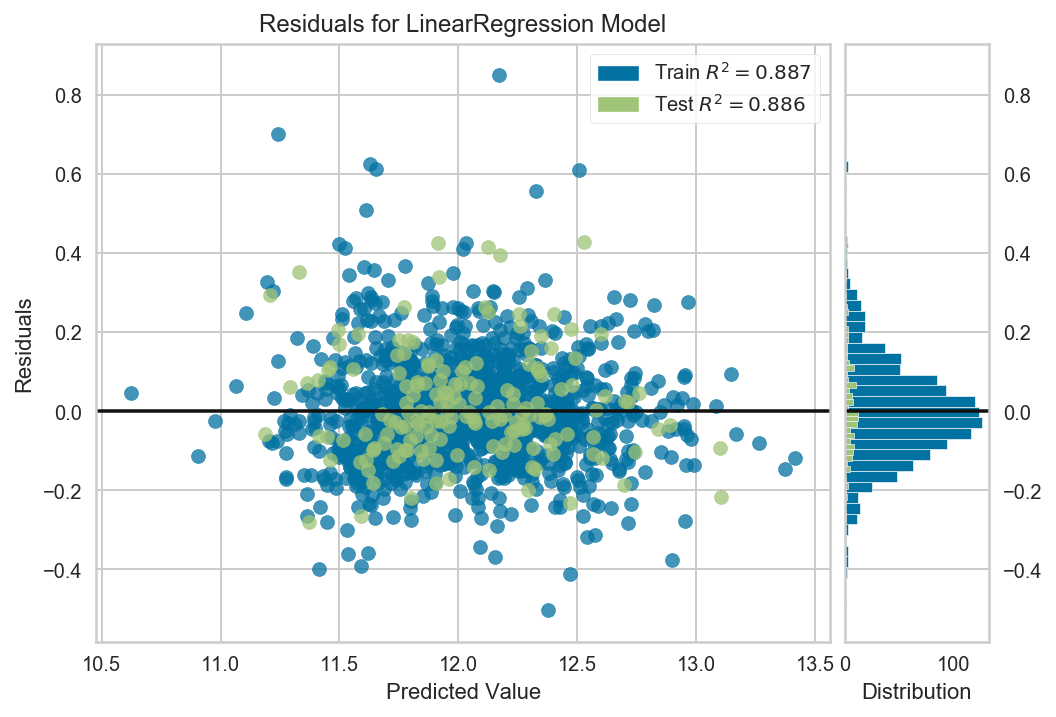

In [53]:
ridge = LinearRegression()
visualizer = ResidualsPlot(ridge)
#b = test['GarageYrBlt'].values.reshape(-1,1)
visualizer.fit(train2.values, y_train)  # Fit the training data to the model
visualizer.score(test2.values, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

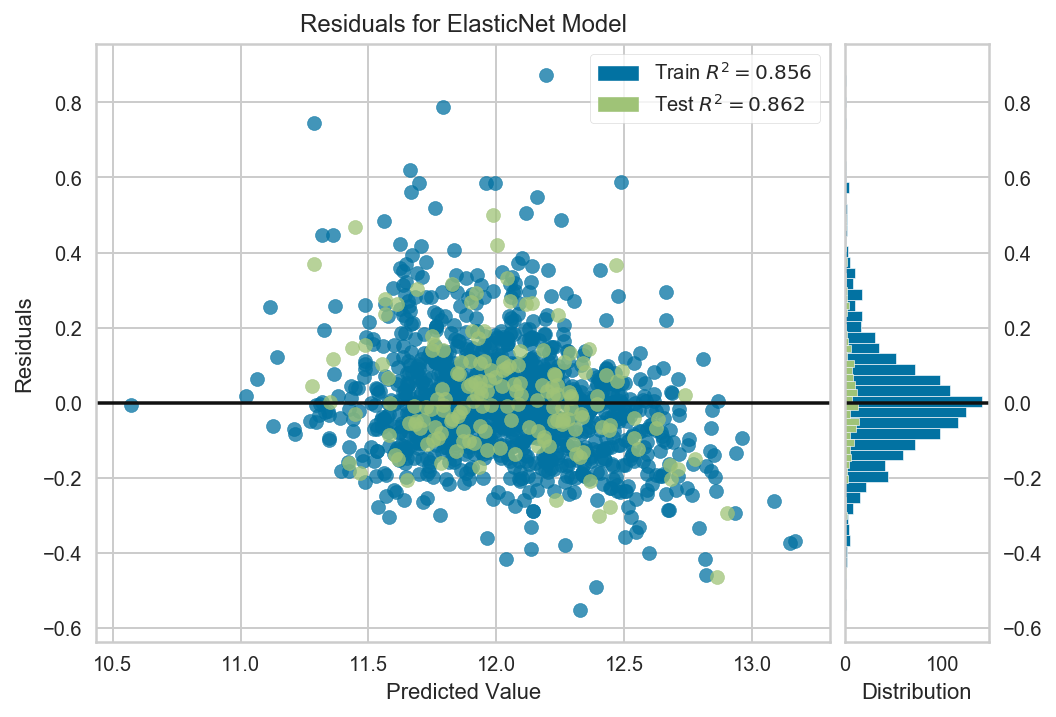

In [54]:
ridge = ElasticNet(alpha=0.05)
visualizer = ResidualsPlot(ridge)
#b = test['GarageYrBlt'].values.reshape(-1,1)
visualizer.fit(train2.values, y_train)  # Fit the training data to the model
visualizer.score(test2.values, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [ ]:
# ridge = LinearRegression()
# visualizer = ResidualsPlot(ridge)
# b = test['GarageYrBlt'].values.reshape(-1,1)
# visualizer.fit(a, y_train)  # Fit the training data to the model
# visualizer.score(b, y_test)  # Evaluate the model on the test data
# visualizer.poof()                 # Draw/show/poof the data

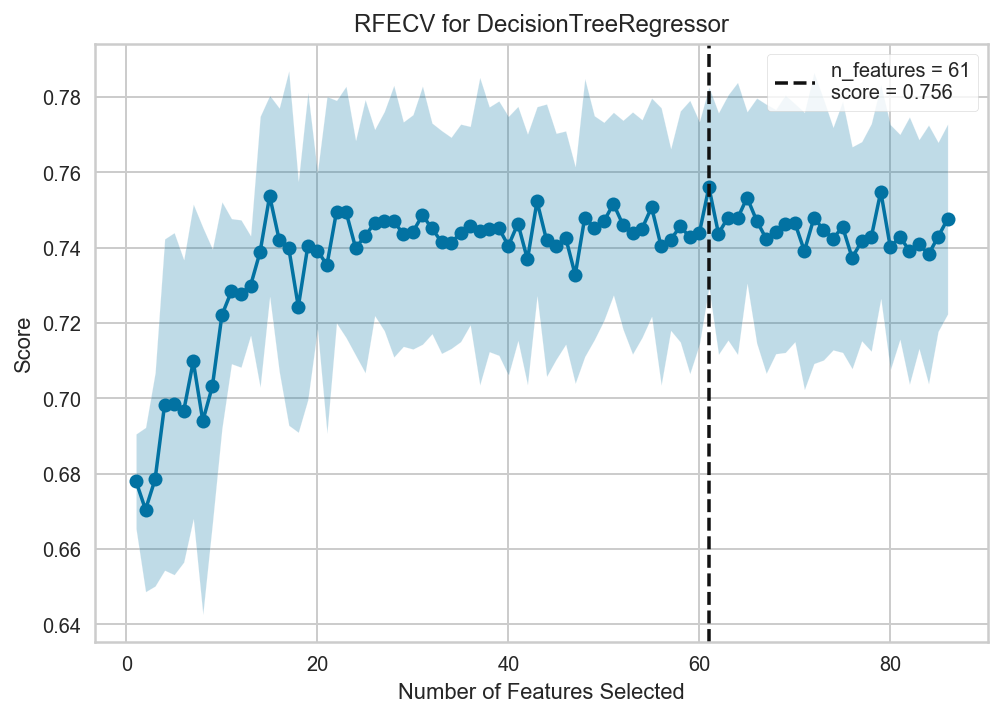

[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True False  True False  True
  True  True  True False  True  True False  True  True False False False
  True  True False  True False False  True False  True  True  True  True
  True  True False False False  True  True  True False  True  True  True
 False  True  True  True False  True False  True  True  True False False
 False False False  True  True  True  True  True  True False  True  True
  True  True]
['MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'BsmtUnfSF' 'TotalBsmtSF' 'GrLivArea' 'BedroomAbvGr' 'TotRmsAbvGrd'
 'Fireplaces' 'GarageCars' 'GarageArea' 'TotalBsmtBath' 'TotalBath'
 'TotalSF' 'MSZoning_1' 'MSZoning_2' 'MSZoning_3' 'LotShape_1'
 'LotShape_3' 'LandContour_1' 'LandContour_2' 'LandContour_3'
 'LotConfig_1' 'LotConfig_2' 'LotConfig_4' 'LandSlope_1' 'BldgType_3'
 'BldgType_4' 'HouseStyle_2' 'HouseStyle_5' 'HouseStyle_7' 'MasVnrType_1'
 'M

In [55]:
#use decisiontree regressor to do feature selections
from yellowbrick.features import RFECV
from sklearn.tree import DecisionTreeRegressor

viz = RFECV(DecisionTreeRegressor(),cv=5)
viz.fit(train, y_train)
viz.poof()
print(viz.get_support())
train3 = train.iloc[:,viz.get_support()]
test3 = test.iloc[:,viz.get_support()]
print(train.iloc[:,viz.get_support()].columns.values)

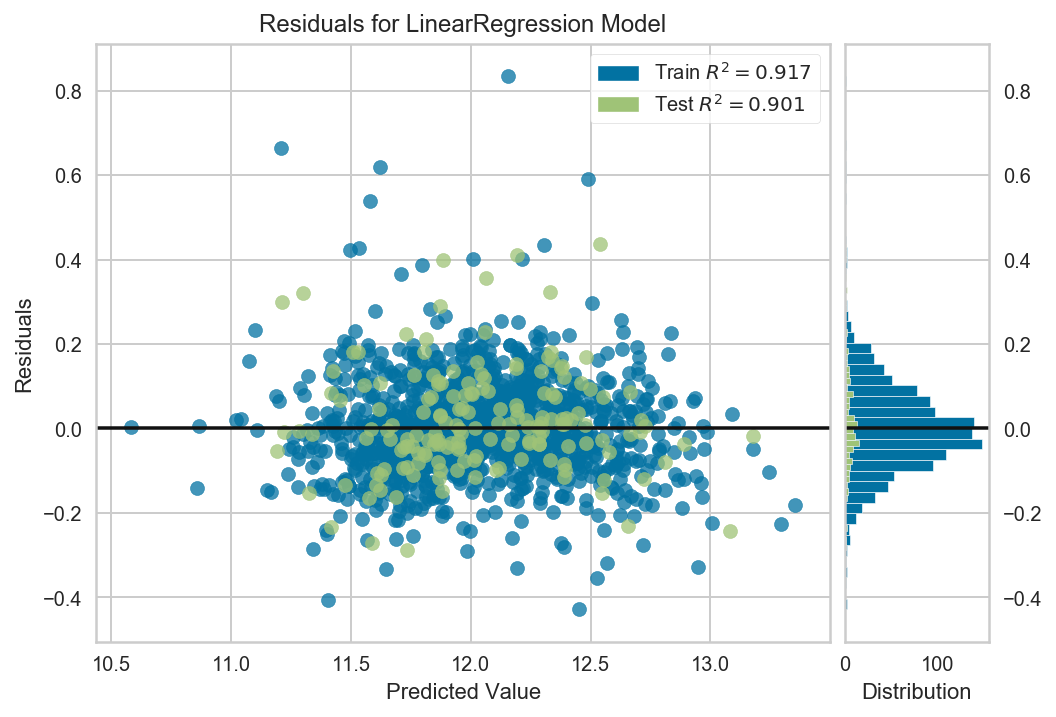

In [56]:
ridge2 = LinearRegression()
visualizer = ResidualsPlot(ridge2)
#b = test['GarageYrBlt'].values.reshape(-1,1)
visualizer.fit(train3.values, y_train)  # Fit the training data to the model
visualizer.score(test3.values, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

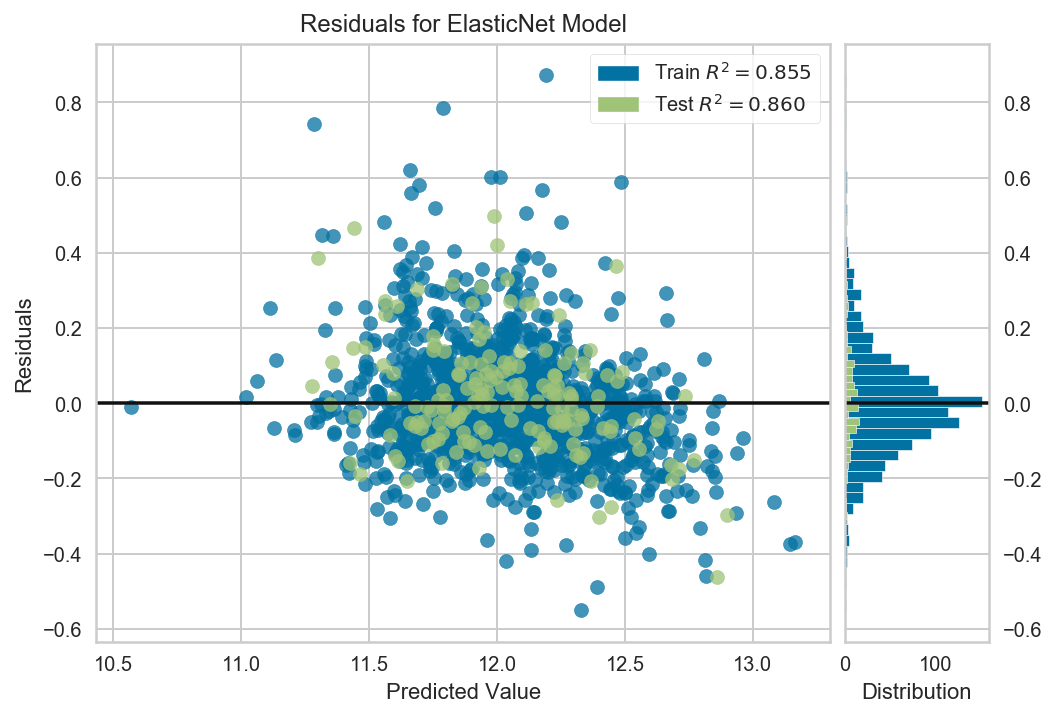

In [57]:
ridge2 = ElasticNet(alpha=0.05)
visualizer = ResidualsPlot(ridge2)
#b = test['GarageYrBlt'].values.reshape(-1,1)
visualizer.fit(train3.values, y_train)  # Fit the training data to the model
visualizer.score(test3.values, y_test)  # Evaluate the model on the test data
visualizer.poof()      

In [ ]:
#the final model is linear regression and the final train set is train2
print(train2.columns)
y_pred = ridge.predict(test2.values)

In [346]:
print(list(zip(ridge.coef_, test2.columns)))


[(0.04162807609519765, 'LotArea'), (0.13319078623185387, 'OverallQual'), (0.03816250845565872, 'OverallCond'), (0.0764037527489918, 'TotalBsmtSF'), (0.07042570422432662, 'GrLivArea'), (-0.024492509739904016, 'BedroomAbvGr'), (-0.028199711670574078, 'KitchenAbvGr'), (0.011864980502779471, 'TotRmsAbvGrd'), (0.014624274805993933, 'Fireplaces'), (0.044557204020776835, 'GarageCars'), (0.023384712488361437, 'GarageArea'), (0.030041494471837165, 'TotalBsmtBath'), (0.06552498214499221, 'TotalBath'), (0.019066561531842746, 'TotalSF'), (-0.02533746362880448, 'BsmtUnfSF'), (-0.02667444616612935, 'LotShape_3'), (-0.047562806052824924, 'LotConfig_3'), (-0.12559515742924976, 'LandSlope_2')]


(array([ 6., 11., 18., 32., 34., 26., 26., 10.,  6.,  3.]),
 array([11.27751948, 11.43999582, 11.60247215, 11.76494848, 11.92742482,
        12.08990115, 12.25237748, 12.41485381, 12.57733015, 12.73980648,
        12.90228281]),
 <a list of 10 Patch objects>)

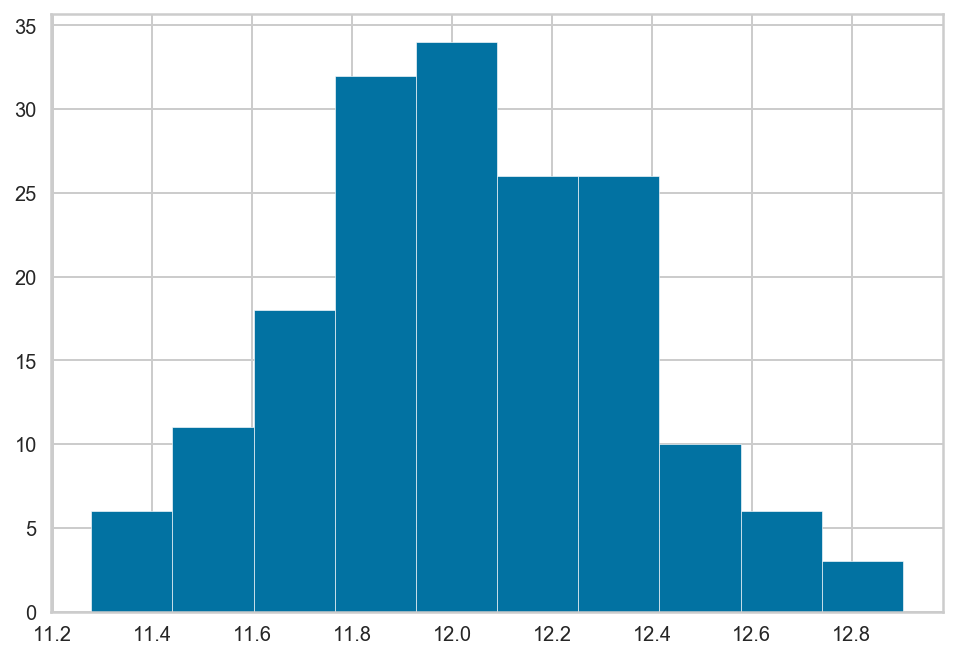

In [59]:
plt.hist(y_pred)

In [ ]:
# for folds in range(5,11):
#     print('------------------------------------\n')
#     print('K:', folds)
#     model = LinearRegression()
    
#     # Perform cross-validation
#     scores = cross_val_score(model, train2, y_train, cv=folds)
#     print("Cross-validated scores:", scores)
#     print("Mean CV R2:", np.mean(scores))
#     print('Std CV R2:', np.std(scores))
    
#     # Make cross-validated predictions
#     predictions = cross_val_predict(model, train2, y_train, cv=folds)
    
#     r2 = metrics.r2_score(y_train, predictions)
#     print("Cross-Predicted R2:", r2)
#     print(predictions.max())

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [292]:
# A:from quest1, we used linear model with selected few features.
# features are :['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea',
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageCars', 'GarageArea', 'TotalBsmtBath', 'TotalBath', 'TotalSF',
#        'BsmtUnfSF', 'LotShape_3', 'LotConfig_3', 'LandSlope_2']
#the test set actual price:
X2 = pd.concat([train2,test2])
#Got all data with 18 selected columns
X2.shape
print(X2.head().T)
print(test2.head().T)
print(X2.index)

                      0         1         2         3         4
LotArea       -0.156265  0.098685  0.422475  0.088154  0.921093
OverallQual    0.636043 -0.091687  0.636043  0.636043  1.363774
OverallCond   -0.519498  2.200860 -0.519498 -0.519498 -0.519498
TotalBsmtSF   -0.472904  0.502392 -0.319162 -0.713124  0.221334
GrLivArea      0.524134 -0.406432  0.660851  0.536940  1.325915
BedroomAbvGr   0.176832  0.176832  0.176832  0.176832  1.430552
KitchenAbvGr  -0.193789 -0.193789 -0.193789 -0.193789 -0.193789
TotRmsAbvGrd   0.947330 -0.311123 -0.311123  0.318104  1.576557
Fireplaces    -0.977020  0.616003  0.616003  0.616003  0.616003
GarageCars     0.308012  0.308012  0.308012  1.667140  1.667140
GarageArea     0.347724 -0.067962  0.631146  0.791752  1.708152
TotalBsmtBath  0.984245  0.984245  0.984245  0.984245  0.984245
TotalBath      1.320400  0.056102  1.320400 -1.208196  1.320400
TotalSF        0.130491  0.076211  0.306132  0.009258  1.019135
BsmtUnfSF     -0.567299 -0.149845  0.150

In [293]:
#We will use all the data with 18 columns and linear regression to predict their model prices
# plt.hist(y_train)
# plt.show()
ridge = LinearRegression()
ridge.fit(train2, y_train)
y2_pred = ridge.predict(X2.values)
print(y2_pred[0:5])

[12.23408408 12.16475562 12.30636867 12.14993536 12.60094211]


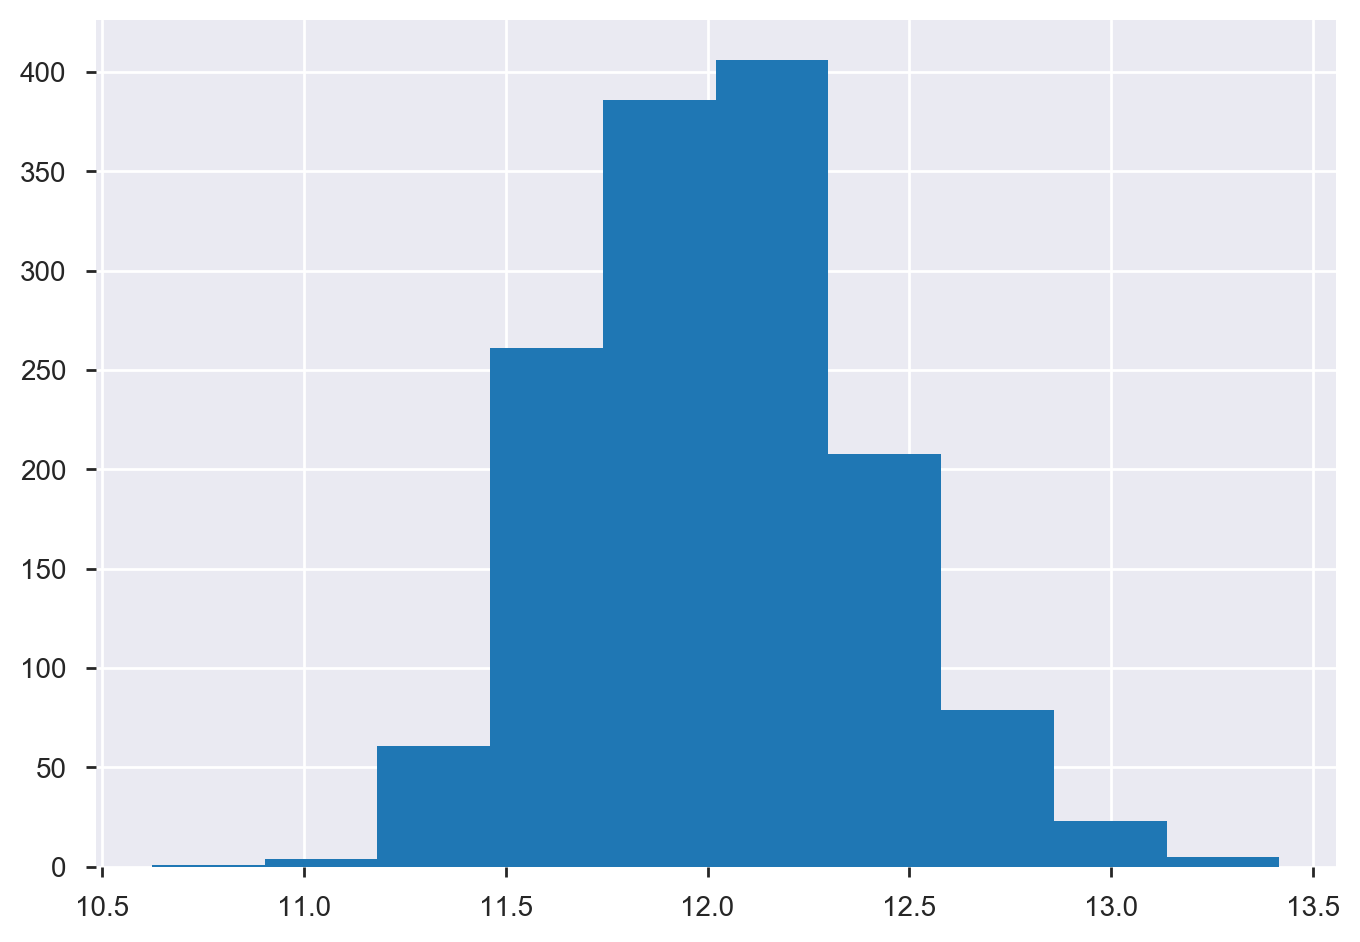

In [294]:
plt.hist(y2_pred)
plt.show()

In [295]:
predy2 = np.expm1(y2_pred)
predy2.shape
print(predy2)
#Restore the actual prices

[205680.48781138 191903.97799552 221098.62398923 ... 230204.05665752
 218445.5824437  137507.20231075]


In [296]:
fixhouse2.index == X2.index

array([ True,  True,  True, ..., False, False, False])

In [297]:
#Price variance left by Unexplained features
print(len(fixhouse2.index))
print(len(fixhouse1.index))
print(len(fixhouse.index))
print(len(house.index))
print(len(fixhouse1.columns))
print(len(fixhouse.columns))
house2 = pd.read_csv('../housing.csv')
newhouse = house2.loc[X2.index,:]
print(newhouse.shape)

1434
1434
1443
1460
53
53
(1434, 81)


In [298]:
#find all quality columns dropped from house to fixhouse version:
fixable = []
house = pd.read_csv('../housing.csv')
alist = house.columns.values.tolist()
blist = fixhouse.columns.values.tolist()

53
81
['GarageCond', 'Fence', 'BsmtQual', 'PoolQC', 'ExterQual', 'BsmtFinSF2', 'RoofMatl', 'BsmtHalfBath', 'Exterior1st', 'Heating', 'YearRemodAdd', 'SaleCondition', 'Electrical', 'GarageYrBlt', 'BsmtCond', 'YearBuilt', 'RoofStyle', 'BsmtFinSF1', 'FireplaceQu', 'CentralAir', 'HalfBath', 'Condition1', 'Exterior2nd', 'GarageQual', 'Condition2', 'KitchenQual', 'Id', 'FullBath', 'BsmtFullBath', 'HeatingQC', 'ExterCond']


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

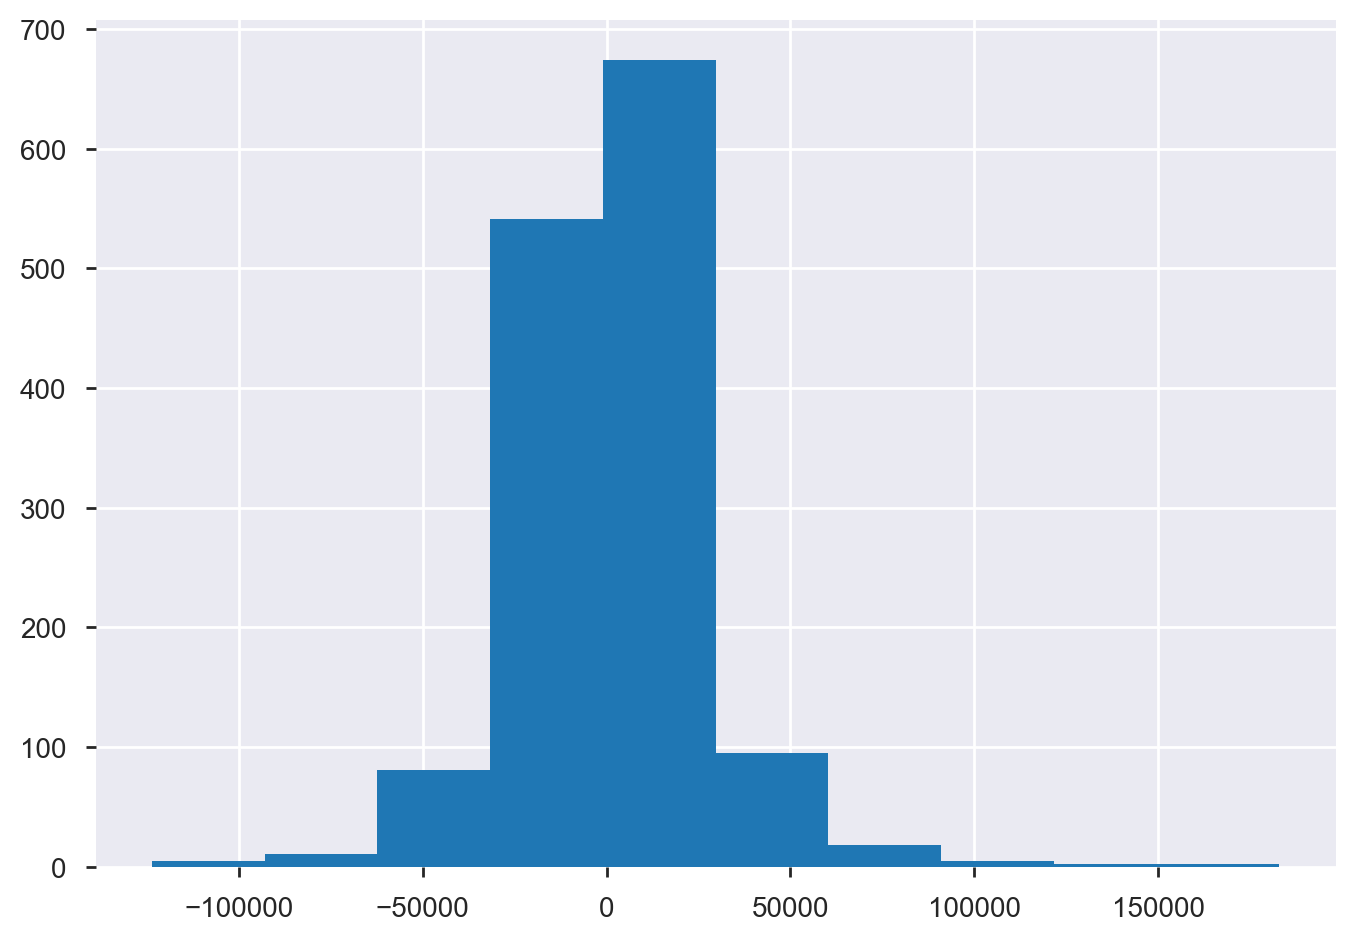

In [299]:
s = set(blist)
s0 = set(alist)
print(len(s))
print(len(s0))
diff = [x for x in s0 if x not in s]
print(diff)
diff2 = ['PoolArea','3SsnPorch','MiscVal','ScreenPorch',
            'EnclosedPorch','OpenPorchSF','WoodDeckSF','MasVnrArea','LowQualFinSF']
mergeddiff = list(set(diff + diff2))
newhouse2 = newhouse[mergeddiff]
#drop all the time columns and the fixed columns that have been analyzed:
misscl2 = ['Id','YearBuilt','GarageYrBlt','YearRemodAdd','BsmtFullBath',
           'BsmtHalfBath', 'FullBath', 'HalfBath','BsmtFinSF2','BsmtFinSF1']
newhouse2.drop(misscl2,axis=1,inplace=True)
newhouse2['SalePrice'] = newhouse['SalePrice']
newhouse2['Prediction'] = predy2
newhouse2['Unexplained'] = newhouse2['SalePrice'] - newhouse2['Prediction']
newhouse2['Unexplained'].hist()

In [300]:
newhouse2[abs(newhouse2['Unexplained'])>50000].T

6        7        13       70       112      151      159   \
GarageCond          TA       TA       TA       TA       TA       TA       TA   
WoodDeckSF         255      235      160      300      120        0      239   
MasVnrArea         186      240      306     1115      220      436      456   
Fence              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
BsmtQual            Ex       Gd       Gd       Gd       Ex       Ex       Gd   
PoolQC             NaN      NaN      NaN      NaN      NaN      NaN      NaN   
ExterQual           Gd       TA       Gd       TA       Gd       Gd       Gd   
SaleCondition   Normal   Normal  Partial   Normal  Partial  Partial  Partial   
RoofMatl       CompShg  CompShg  CompShg  CompShg  CompShg  CompShg  CompShg   
Exterior1st    VinylSd  HdBoard  VinylSd  Plywood  VinylSd  VinylSd  VinylSd   
Heating           GasA     GasA     GasA     GasA     GasA     GasA     GasA   
Electrical       SBrkr    SBrkr    SBrkr    SBrkr    SBrkr    SBrkr    SBrkr   
MiscVal              0      350        0        0        0        0        0   
EnclosedPorch        0      228        0        0        0        0        0   
BsmtCond            TA       TA       TA       TA       TA       TA       TA   
GarageQual          TA       TA       TA       TA       TA       TA       TA   
RoofStyle        Gable    Gable    Gable    Gable    Gable      Hip    Gable   
FireplaceQu         Gd       TA       Gd       Gd       Gd       Gd       Gd   
LowQualFinSF         0        0        0        0        0        0        0   
CentralAir           Y        Y        Y        Y        Y        Y        Y   
ScreenPorch          0        0        0        0      168        0        0   
Condition1        Norm     PosN     Norm     Norm     Norm     Norm     Norm   
Exterior2nd    VinylSd  HdBoard  VinylSd  Plywood  VinylSd  VinylSd  VinylSd   
Condition2        Norm     Norm     Norm     Norm     Norm     Norm     Norm   
OpenPorchSF         57      204       33        0      184      102      132   
KitchenQual         Gd       TA       Gd       TA       Ex       Gd       Gd   
3SsnPorch            0        0        0        0        0        0      168   
PoolArea             0        0        0        0        0        0        0   
HeatingQC           Ex       Ex       Ex       Ex       Ex       Ex       Ex   
ExterCond           TA       TA       TA       Gd       TA       TA       TA   
SalePrice       307000   200000   279500   244000   383970   372402   320000   
Prediction      253697   253672   220491   305154   279168   293168   269194   
Unexplained    53303.2   -53672  59008.7 -61154.3   104802  79233.5  50805.8   

                  169      178      196   ...     1437     66       378   \
GarageCond          TA       TA       TA  ...       TA       TA       TA   
WoodDeckSF         574        0      171  ...        0      301      113   
MasVnrArea         653      748      205  ...      426      287      350   
Fence              NaN      NaN      NaN  ...      NaN      NaN      NaN   
BsmtQual            Gd       Ex       Ex  ...       Ex       Gd       Ex   
PoolQC             NaN      NaN      NaN  ...      NaN      NaN      NaN   
ExterQual           Gd       Ex       Ex  ...       Ex       TA       Gd   
SaleCondition   Normal  Partial  Partial  ...  Partial   Normal  Partial   
RoofMatl       WdShake  CompShg  CompShg  ...  CompShg  CompShg  CompShg   
Exterior1st    Plywood  VinylSd  CemntBd  ...  VinylSd  Plywood  VinylSd   
Heating           GasA     GasA     GasA  ...     GasA     GasA     GasA   
Electrical       SBrkr    SBrkr    SBrkr  ...    SBrkr    SBrkr    SBrkr   
MiscVal              0        0        0  ...        0        0        0   
EnclosedPorch        0        0        0  ...        0        0        0   
BsmtCond            TA       TA       TA  ...       TA       TA       TA   
GarageQual          TA       TA       TA  ...       TA       TA       TA   
RoofS

In [301]:
#Merge all the Porch SF and review its quality:
newhouse2['Porch'] = newhouse2['EnclosedPorch'] + newhouse2['ScreenPorch'] +\
newhouse2['OpenPorchSF']+newhouse2['3SsnPorch']
newhouse2.drop(['EnclosedPorch','ScreenPorch','OpenPorchSF','3SsnPorch'],axis=1,inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [302]:
newhouse2.info()
#drop Pool Area and PoolQC as only 6 houses have pools
newhouse2.drop(['PoolQC','PoolArea'],axis=1,inplace=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1458
Data columns (total 30 columns):
GarageCond       1357 non-null object
WoodDeckSF       1434 non-null int64
MasVnrArea       1426 non-null float64
Fence            274 non-null object
BsmtQual         1397 non-null object
PoolQC           6 non-null object
ExterQual        1434 non-null object
SaleCondition    1434 non-null object
RoofMatl         1434 non-null object
Exterior1st      1434 non-null object
Heating          1434 non-null object
Electrical       1433 non-null object
MiscVal          1434 non-null int64
BsmtCond         1397 non-null object
GarageQual       1357 non-null object
RoofStyle        1434 non-null object
FireplaceQu      759 non-null object
LowQualFinSF     1434 non-null int64
CentralAir       1434 non-null object
Condition1       1434 non-null object
Exterior2nd      1434 non-null object
Condition2       1434 non-null object
KitchenQual      1434 non-null object
PoolArea         1434 non-

In [303]:
for col in ['Fence','FireplaceQu','GarageCond','MasVnrArea','BsmtCond','BsmtQual','GarageQual']:
    newhouse2[col] = newhouse2[col].fillna('None')
newhouse2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1458
Data columns (total 28 columns):
GarageCond       1434 non-null object
WoodDeckSF       1434 non-null int64
MasVnrArea       1434 non-null object
Fence            1434 non-null object
BsmtQual         1434 non-null object
ExterQual        1434 non-null object
SaleCondition    1434 non-null object
RoofMatl         1434 non-null object
Exterior1st      1434 non-null object
Heating          1434 non-null object
Electrical       1433 non-null object
MiscVal          1434 non-null int64
BsmtCond         1434 non-null object
GarageQual       1434 non-null object
RoofStyle        1434 non-null object
FireplaceQu      1434 non-null object
LowQualFinSF     1434 non-null int64
CentralAir       1434 non-null object
Condition1       1434 non-null object
Exterior2nd      1434 non-null object
Condition2       1434 non-null object
KitchenQual      1434 non-null object
HeatingQC        1434 non-null object
ExterCond        1434 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [304]:
newhouse2['MasVnrArea'][newhouse2['MasVnrArea']=='None'] = 0
newhouse2.MasVnrArea = newhouse2.MasVnrArea.astype('int64')


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/li

In [305]:
newhouse2cat = newhouse2.select_dtypes(include='object')
newhouse2num = newhouse2.select_dtypes(exclude='object')
print(newhouse2cat.columns)
print(newhouse2num.columns)

Index(['GarageCond', 'Fence', 'BsmtQual', 'ExterQual', 'SaleCondition',
       'RoofMatl', 'Exterior1st', 'Heating', 'Electrical', 'BsmtCond',
       'GarageQual', 'RoofStyle', 'FireplaceQu', 'CentralAir', 'Condition1',
       'Exterior2nd', 'Condition2', 'KitchenQual', 'HeatingQC', 'ExterCond'],
      dtype='object')
Index(['WoodDeckSF', 'MasVnrArea', 'MiscVal', 'LowQualFinSF', 'SalePrice',
       'Prediction', 'Unexplained', 'Porch'],
      dtype='object')


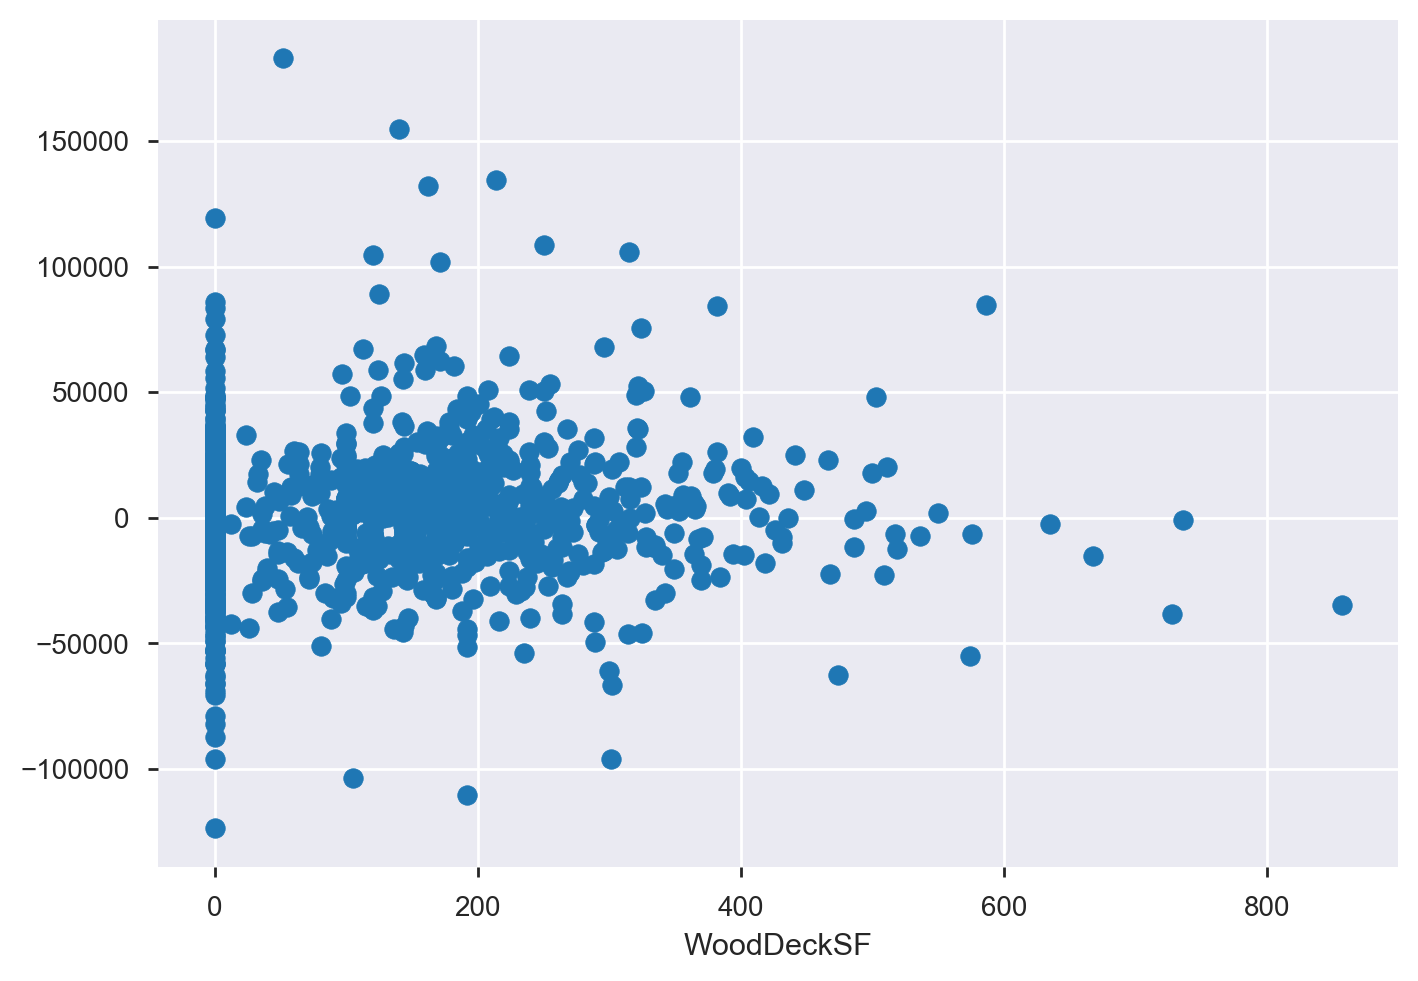

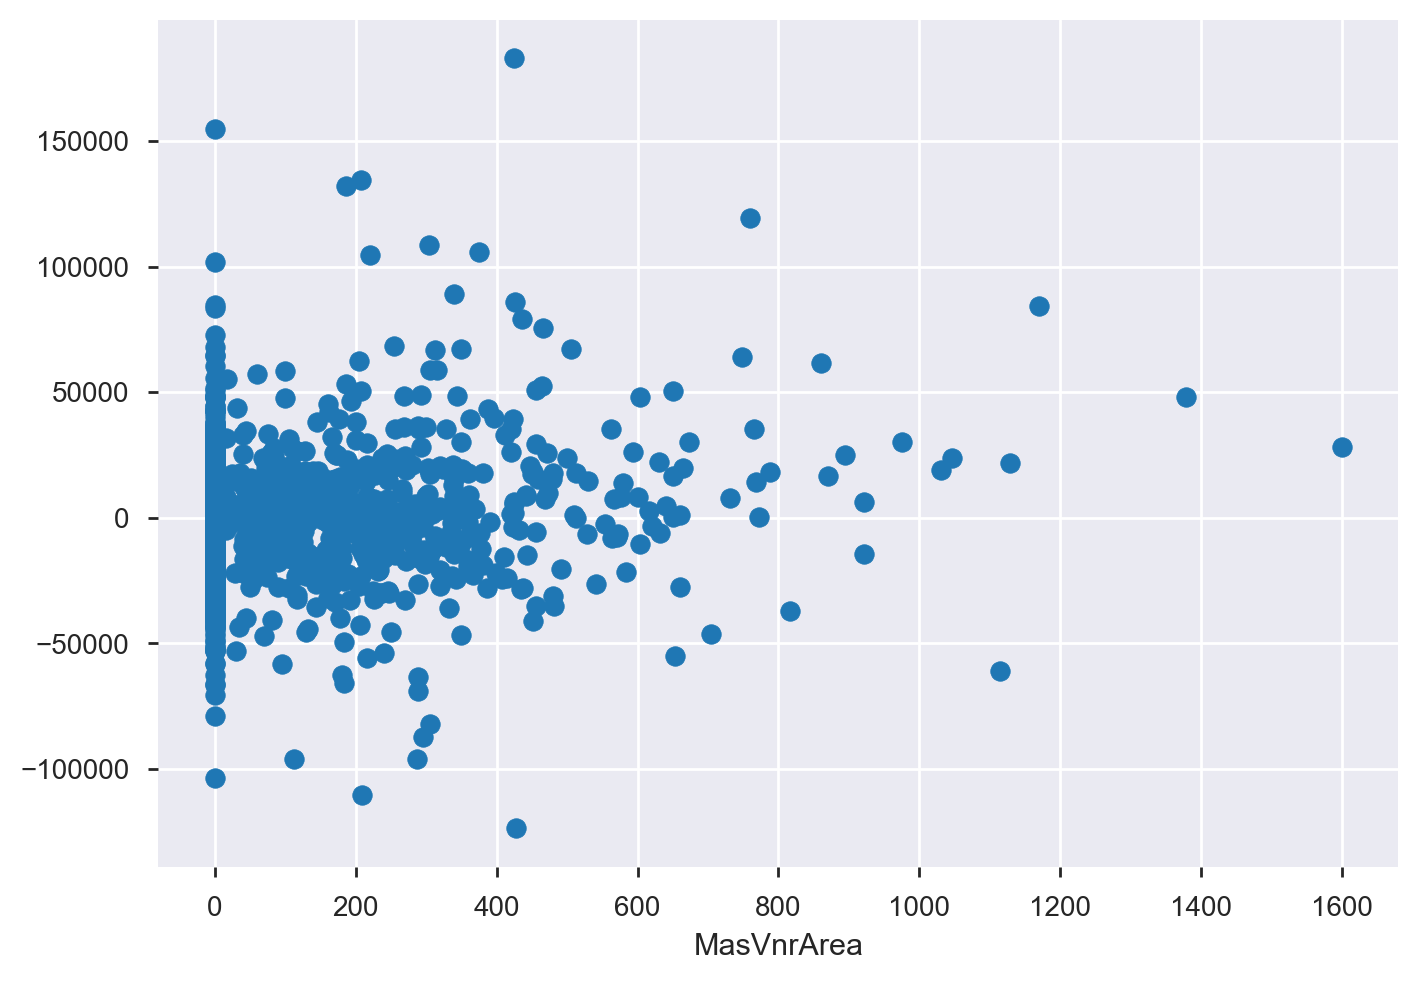

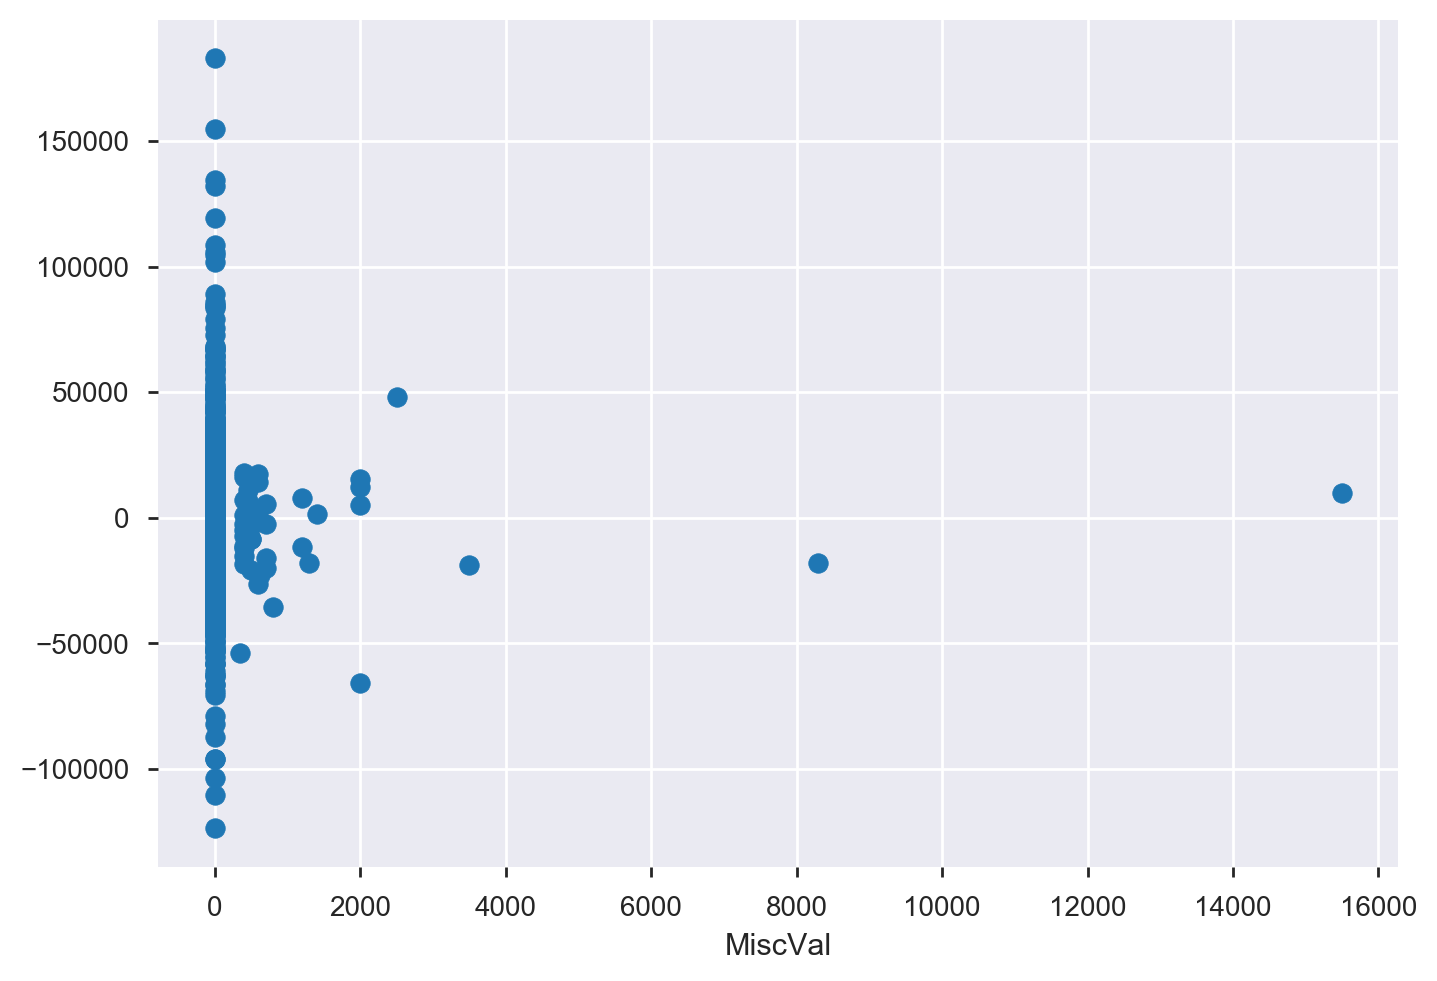

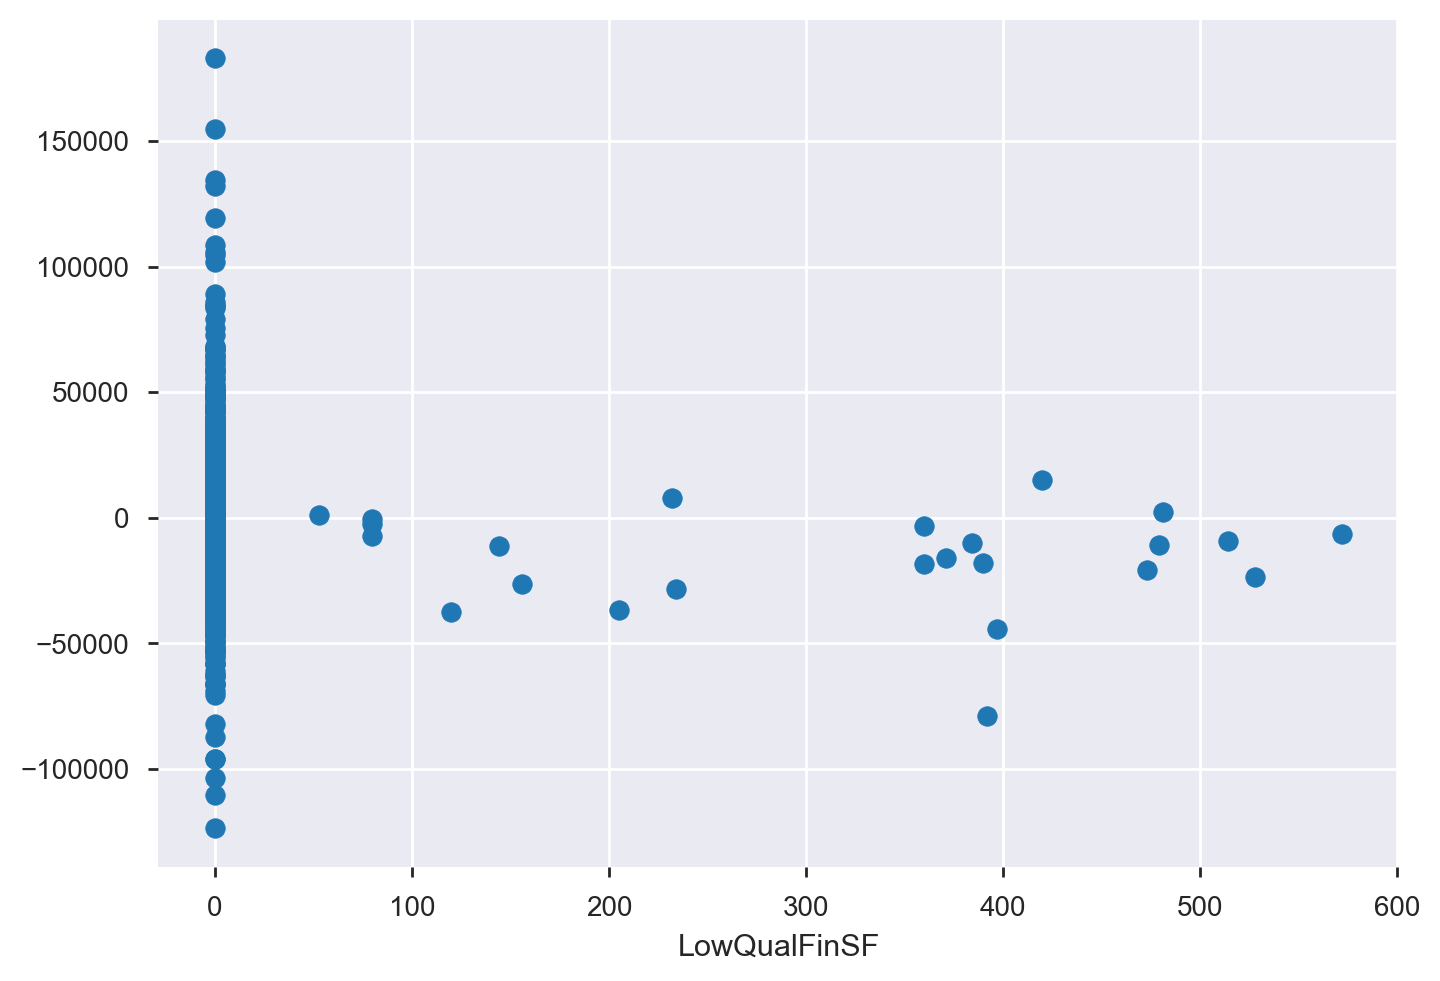

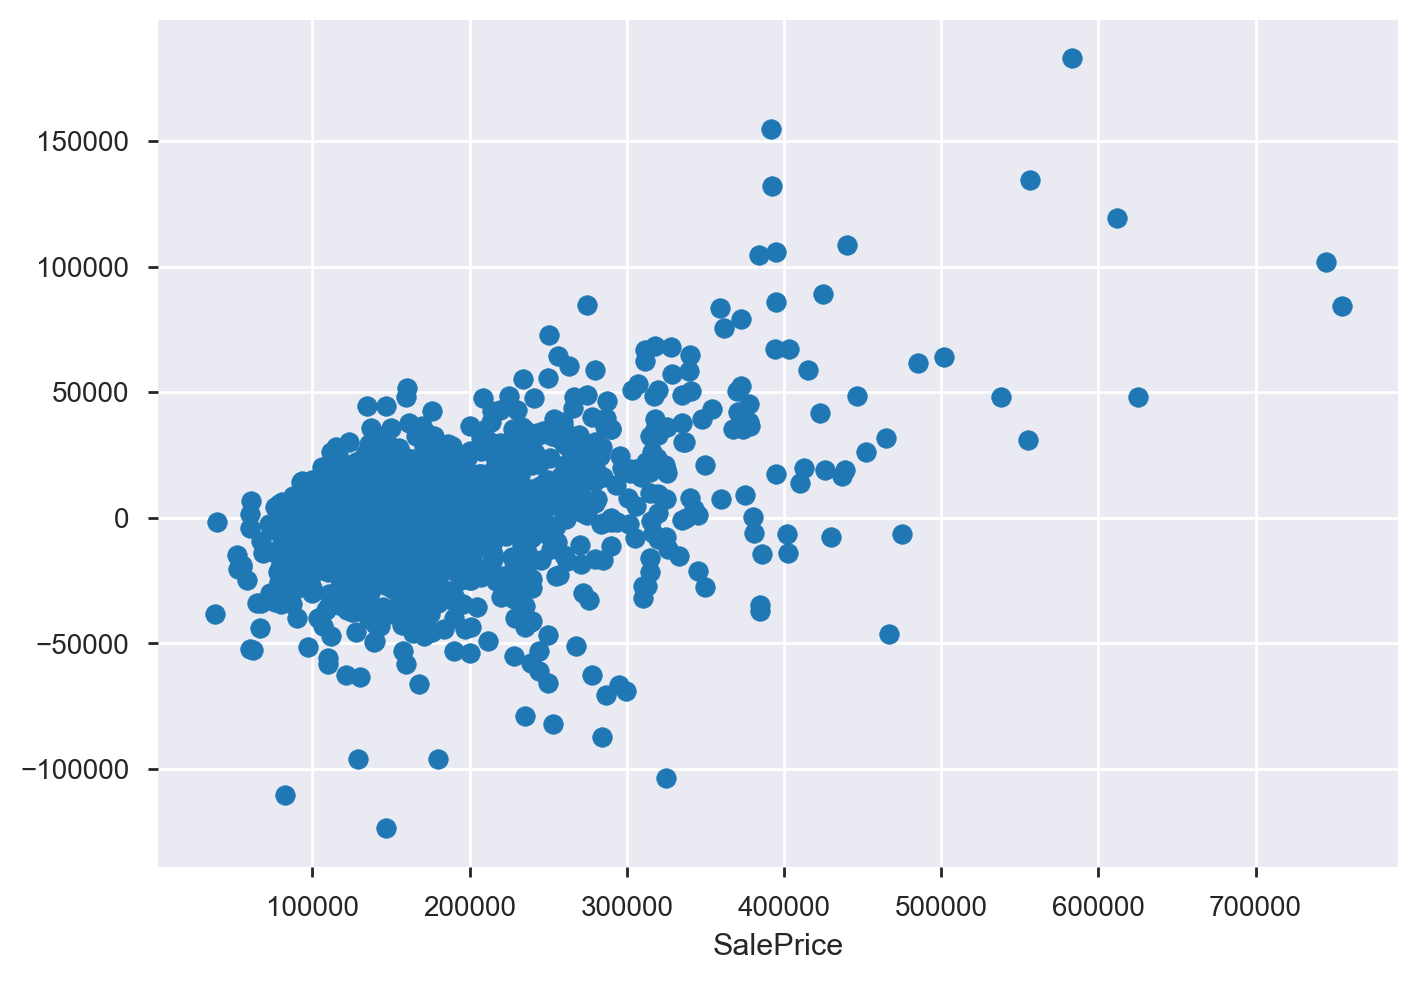

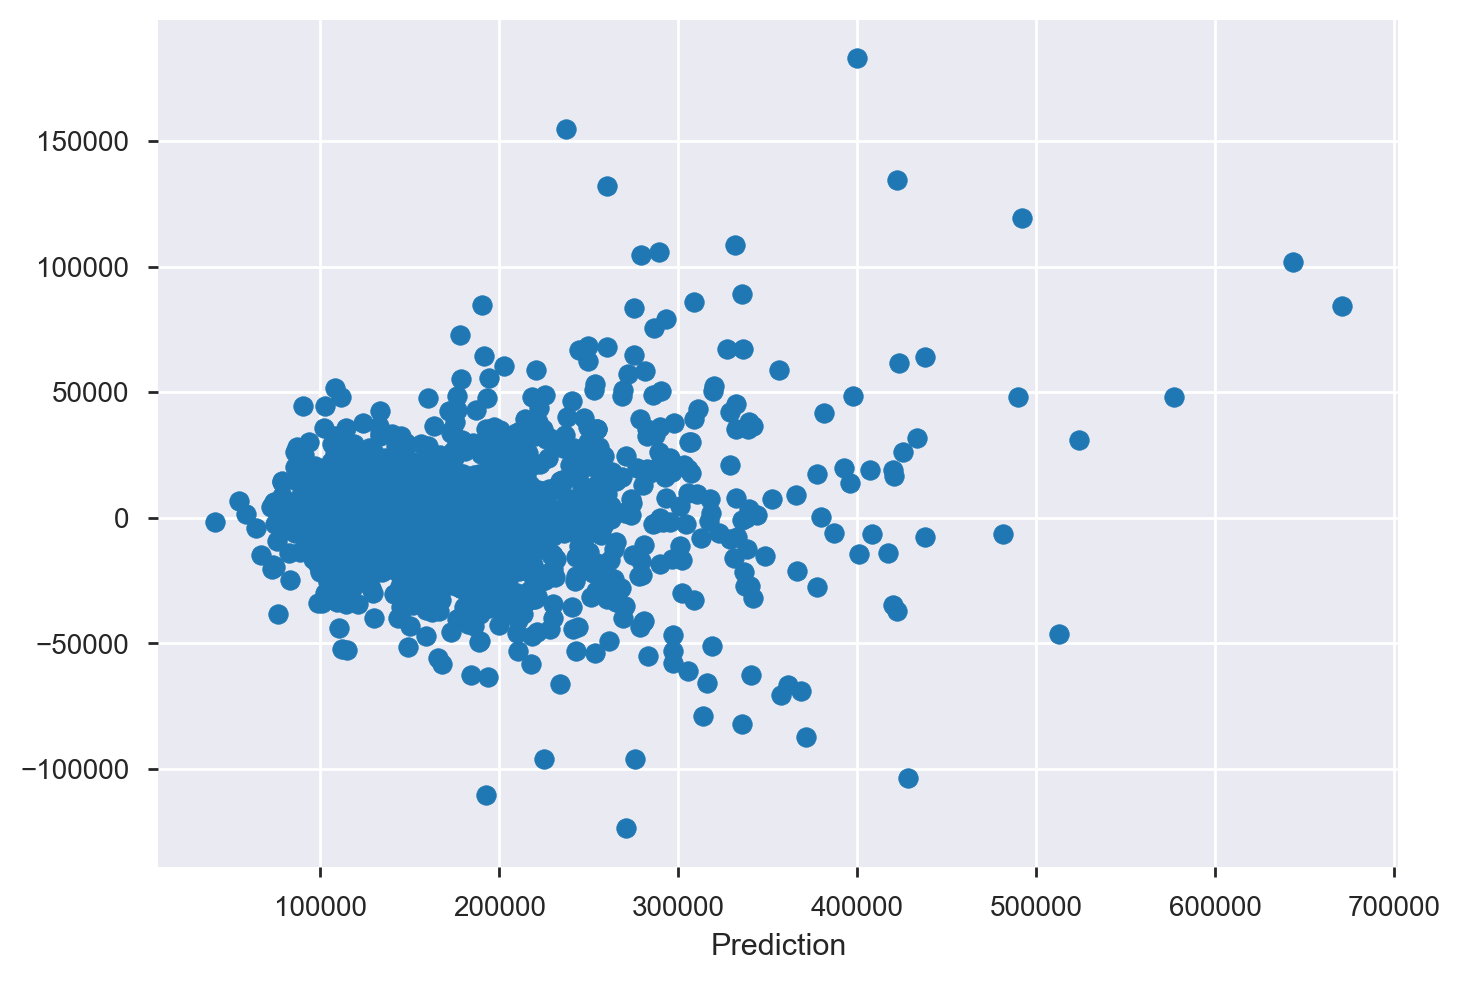

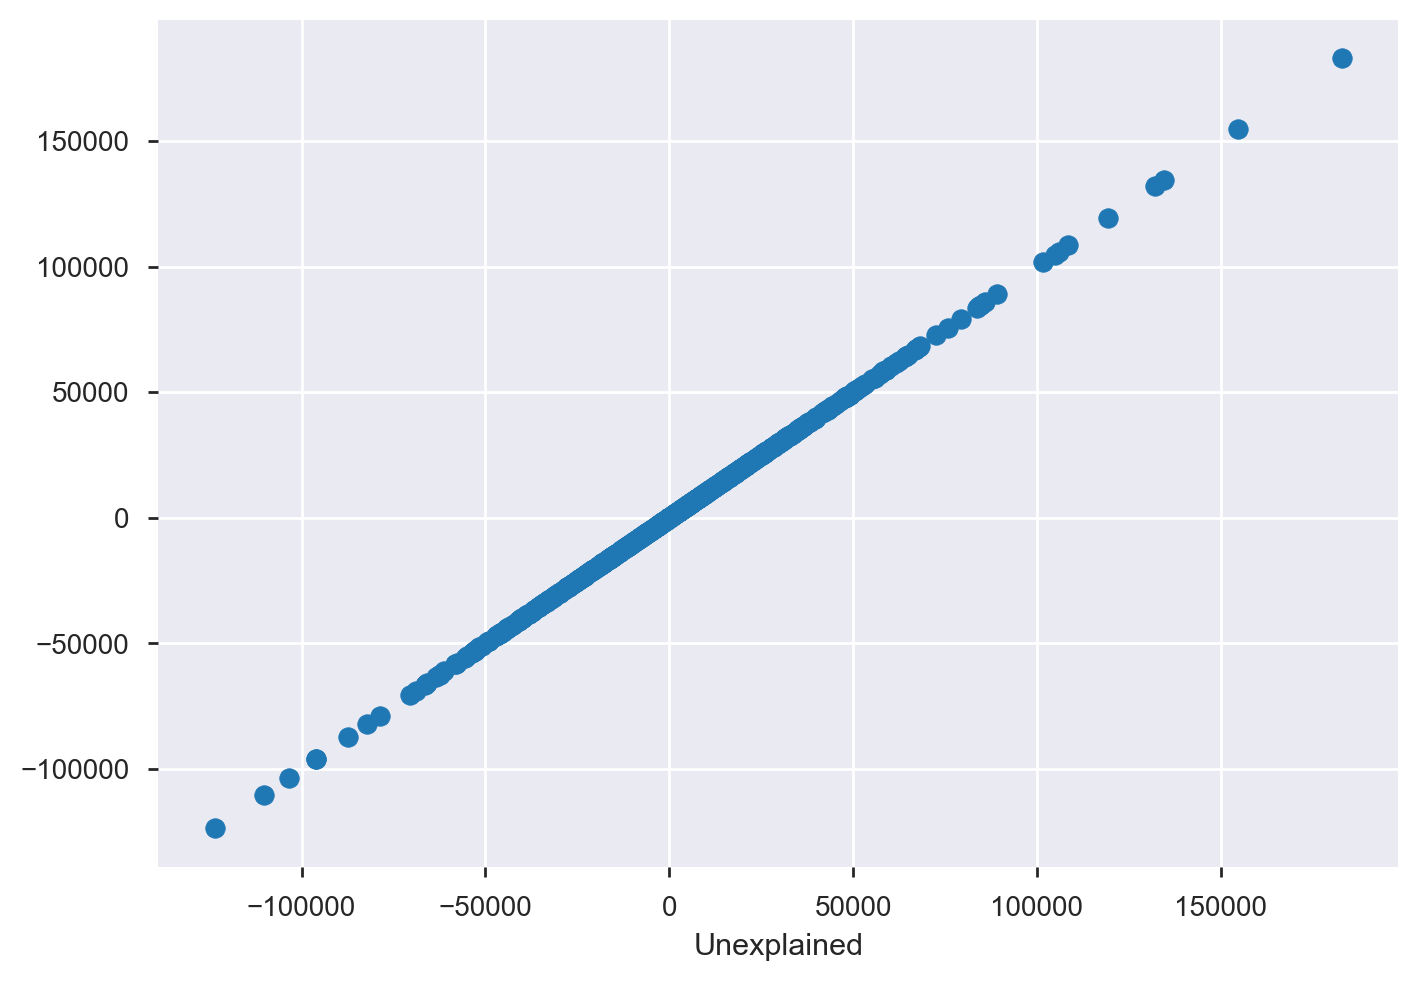

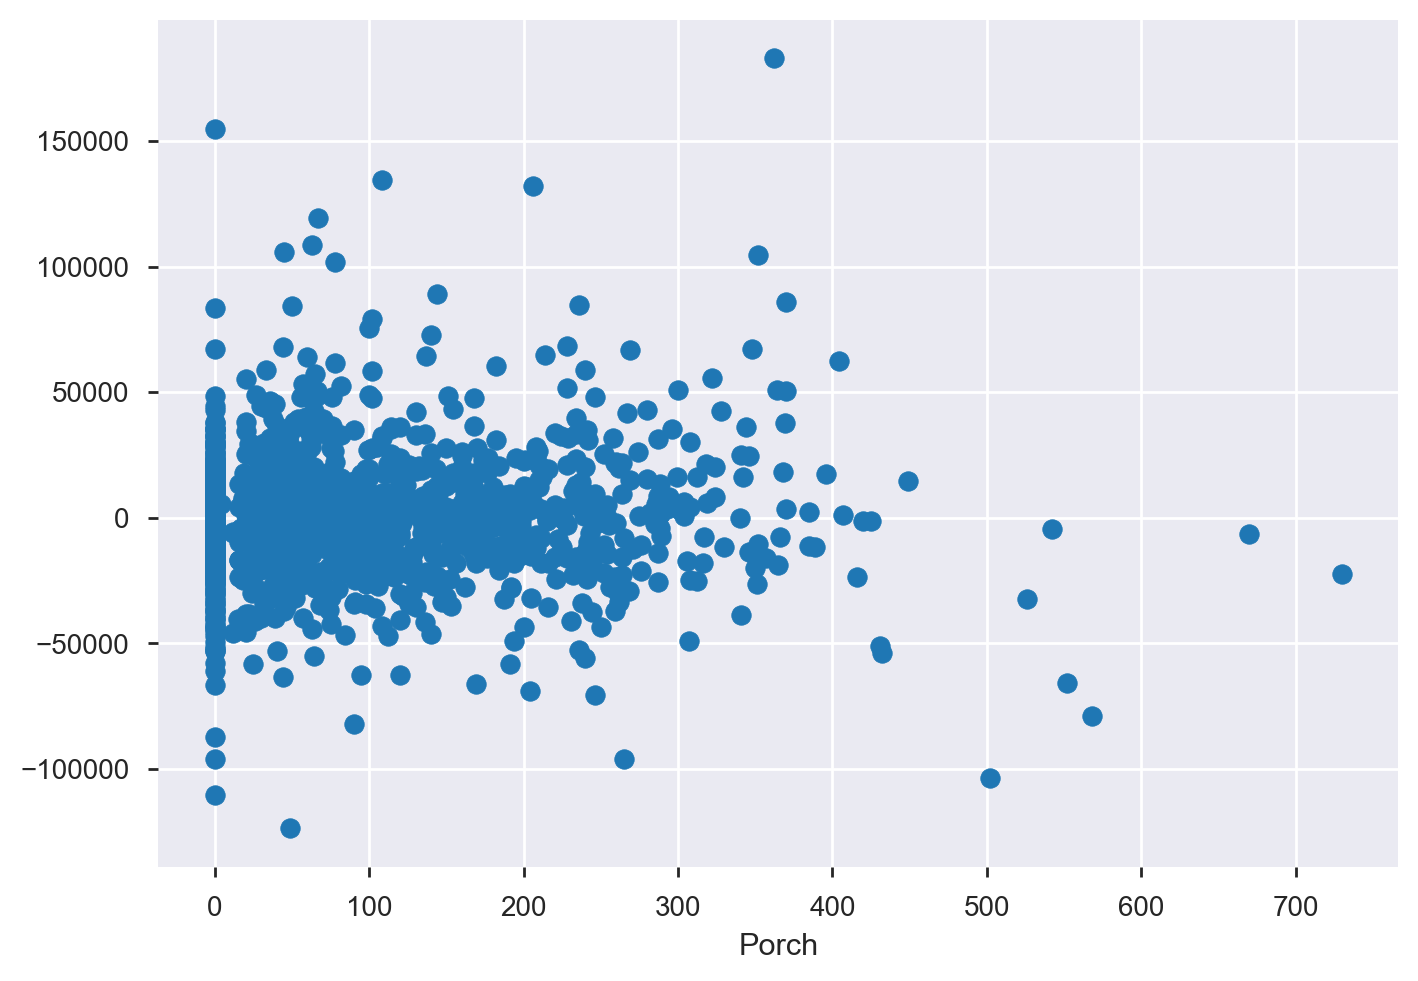

In [306]:
import pandas_profiling
profile4 = pandas_profiling.ProfileReport(newhouse2)
profile4
for col in newhouse2num.columns.values:
    plt.figure(figsize=(5,5))
    plt.scatter(newhouse2num[col],newhouse2['Unexplained'])
    plt.xlabel(col)
    plt.show()
#None of the numseric data seems to have linear realationship 
#

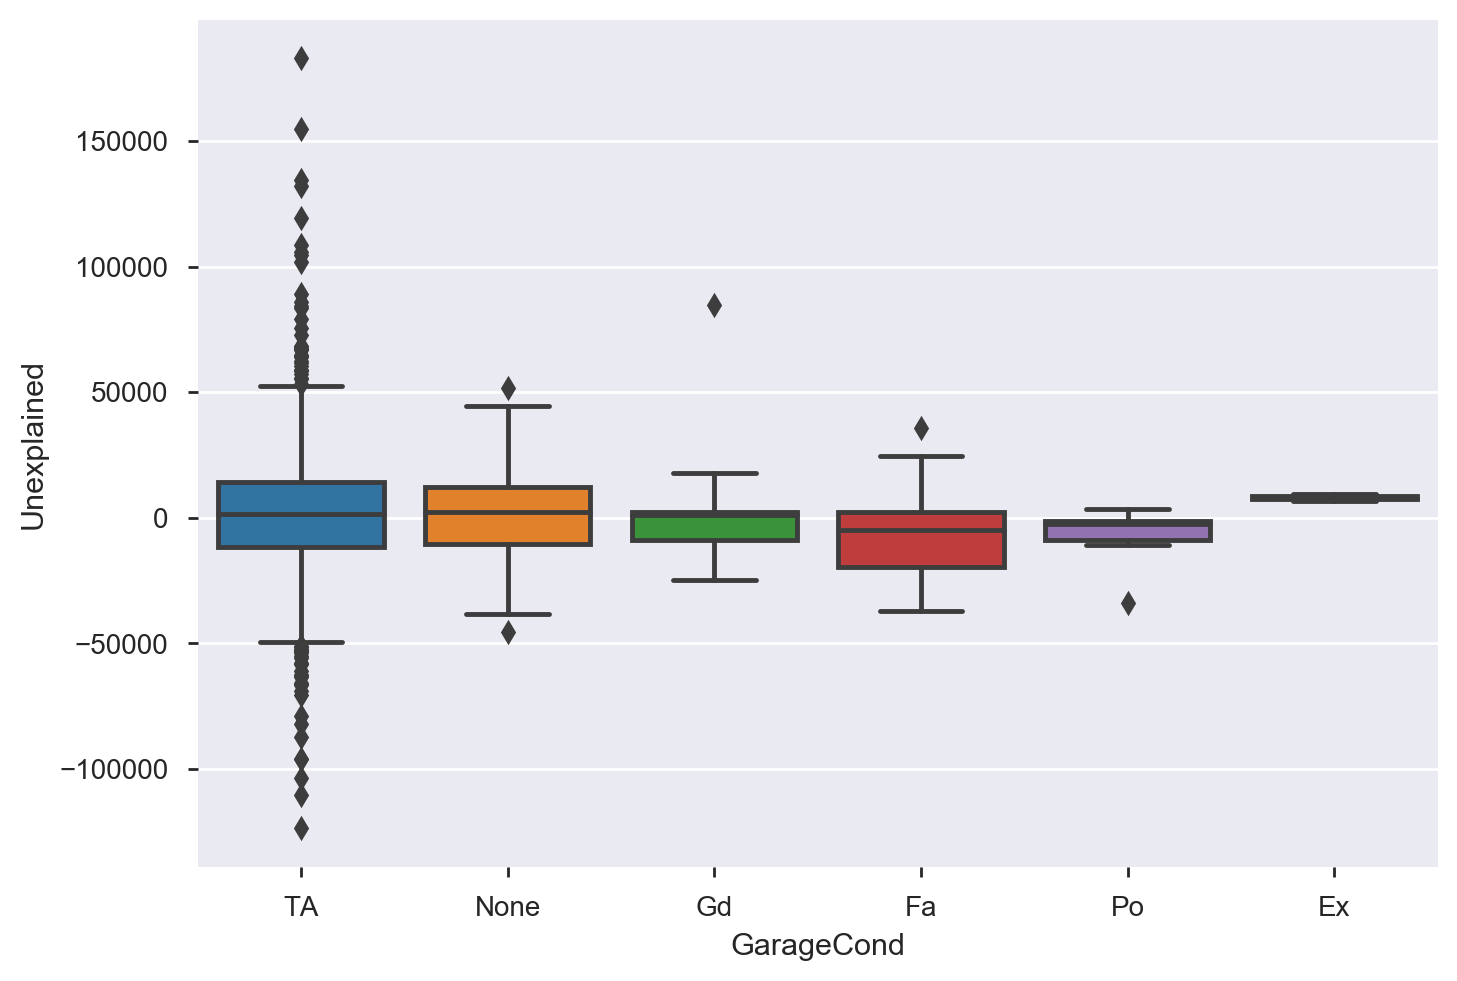

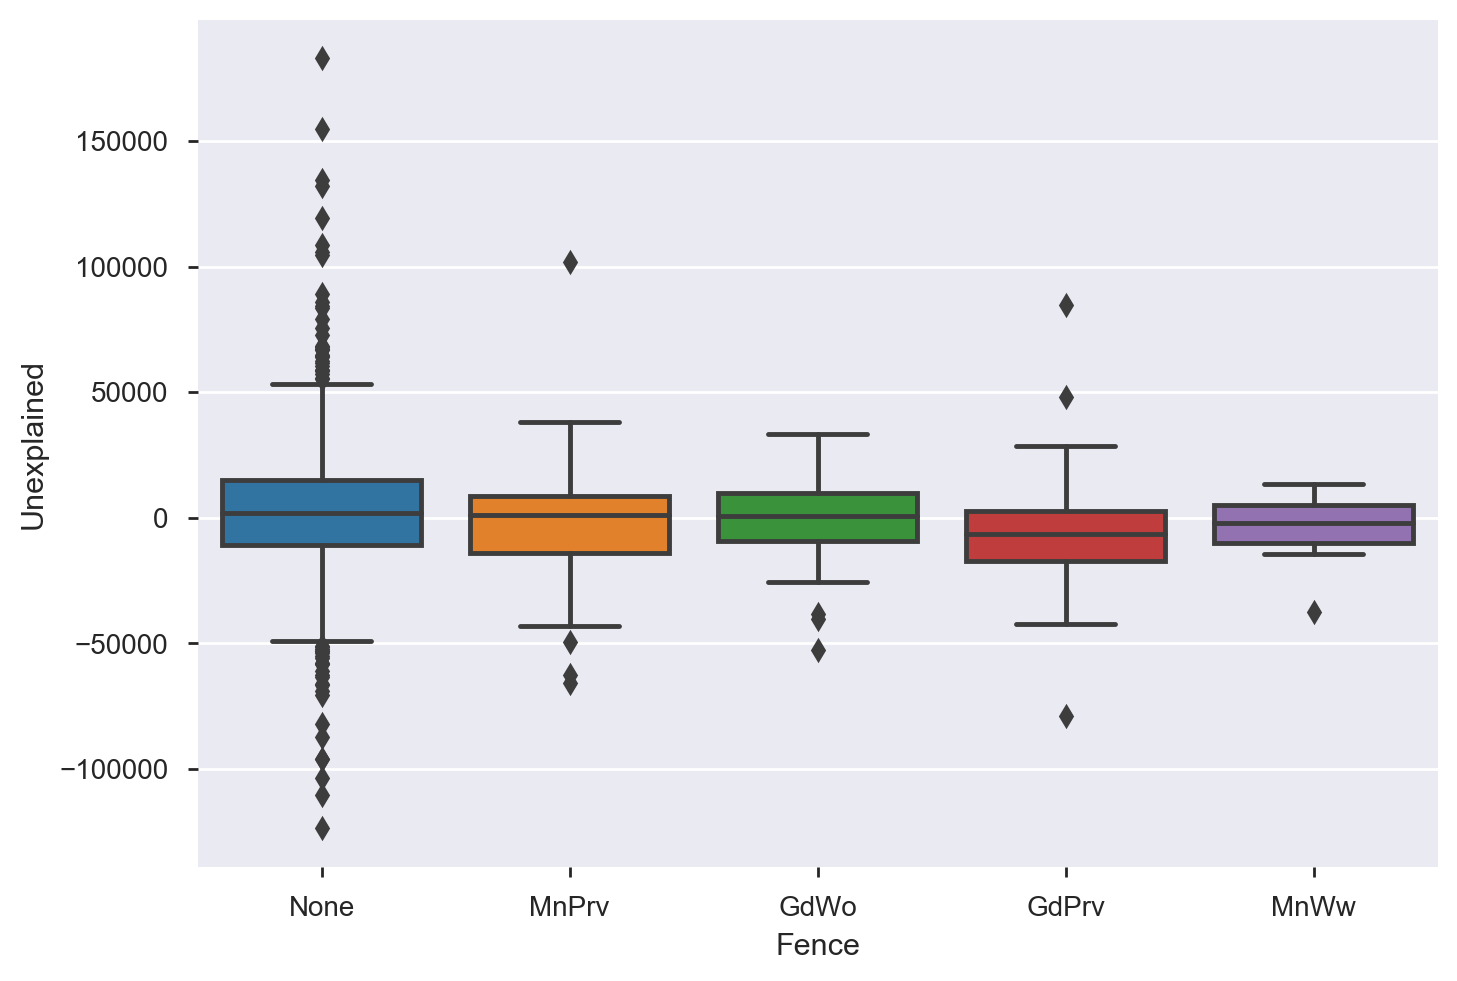

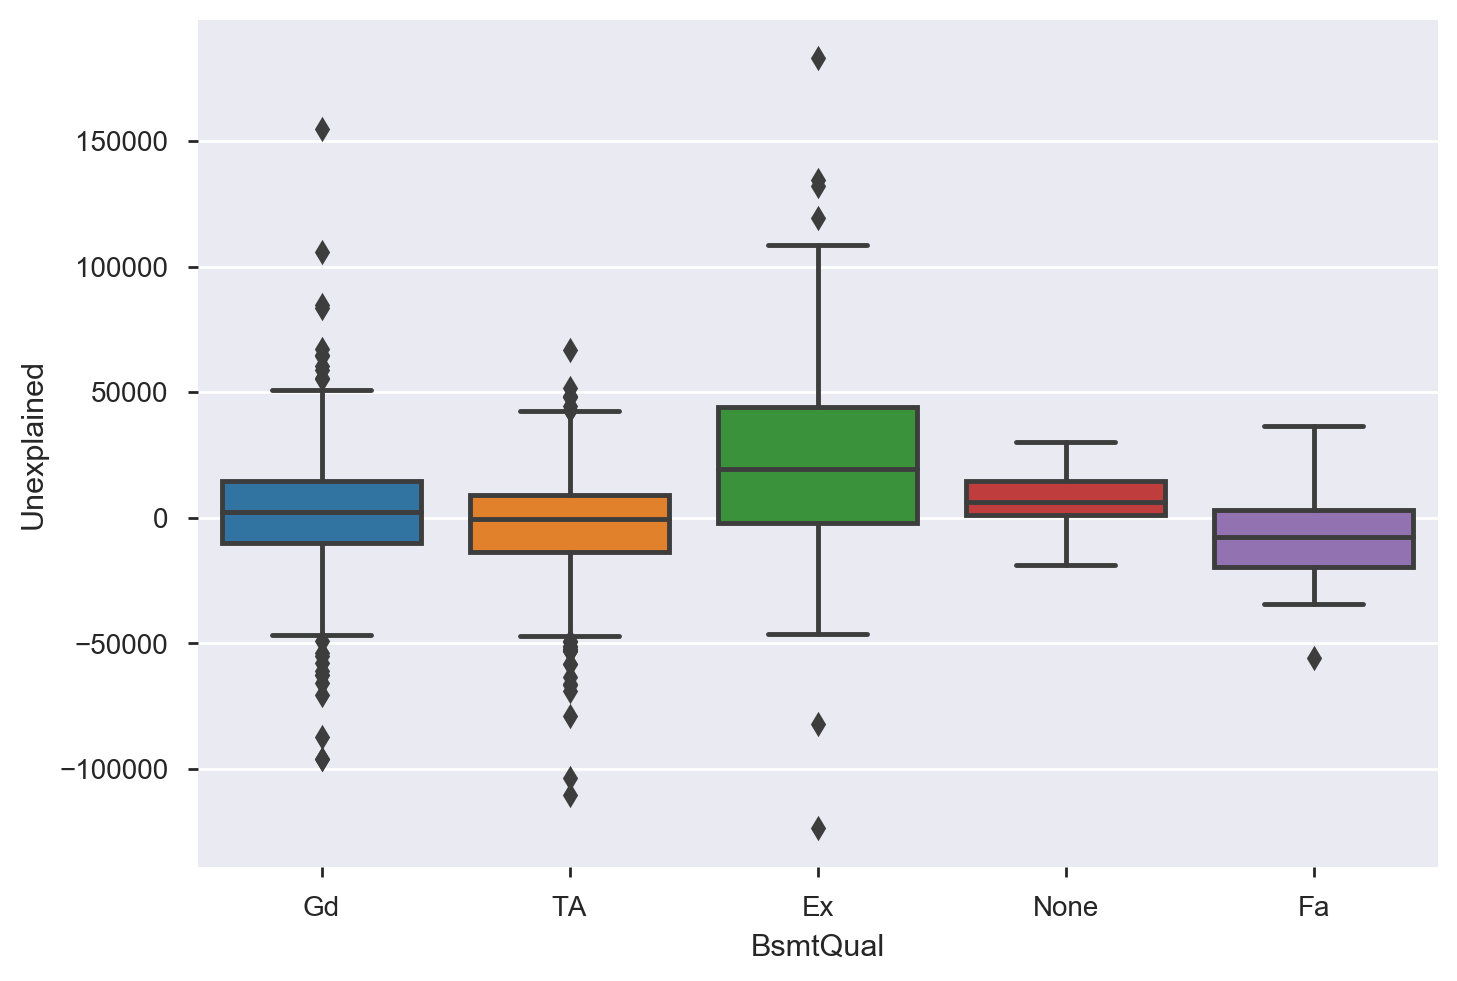

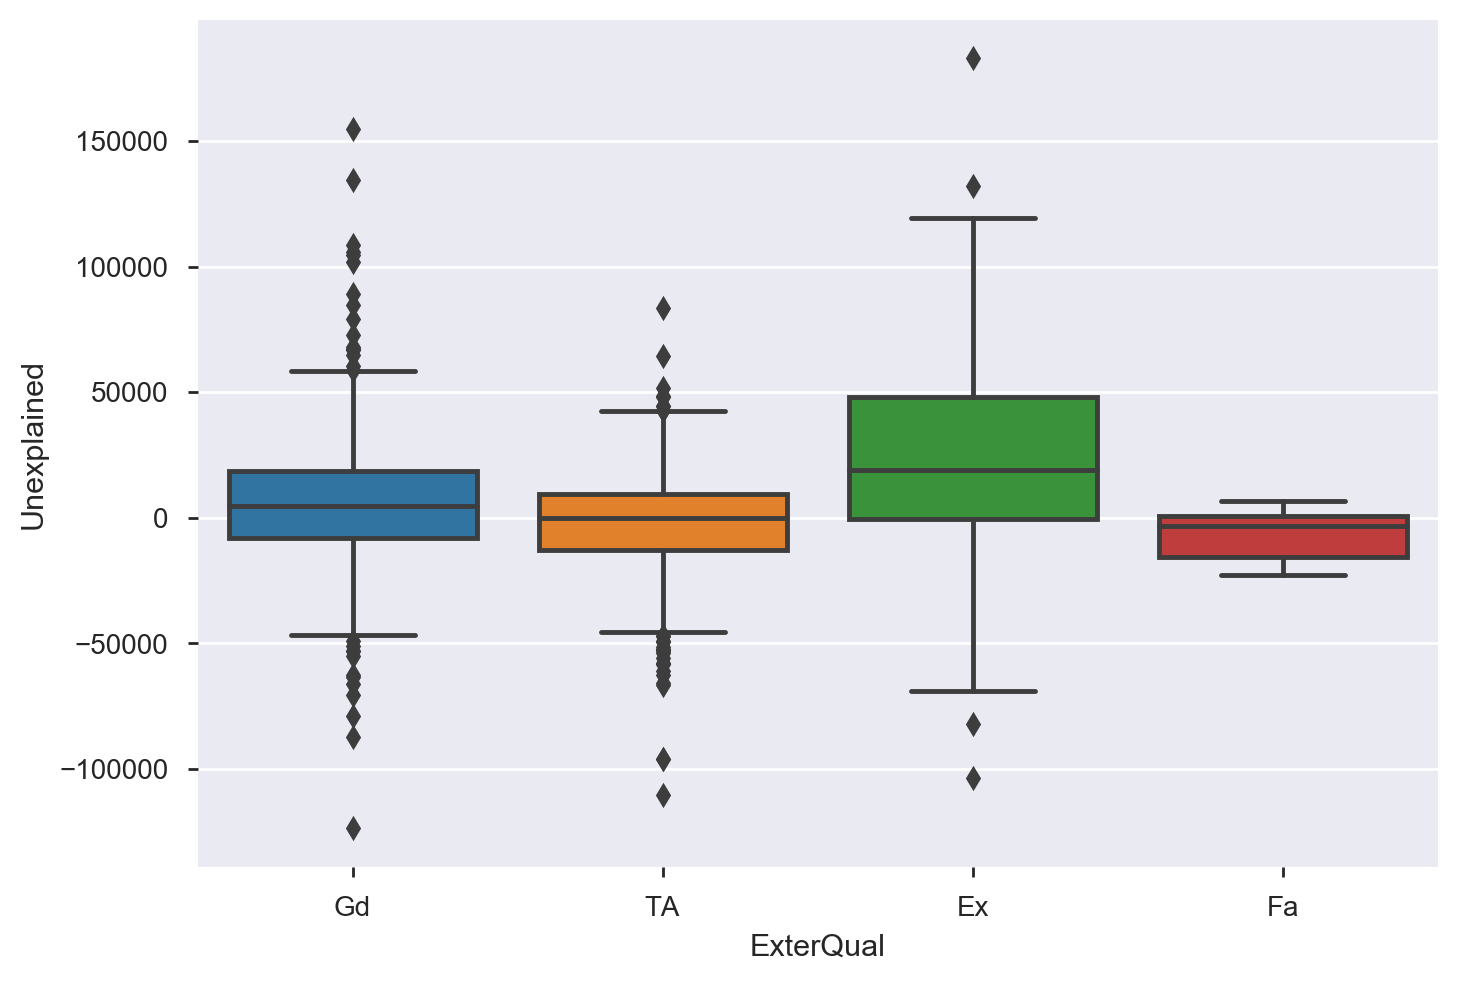

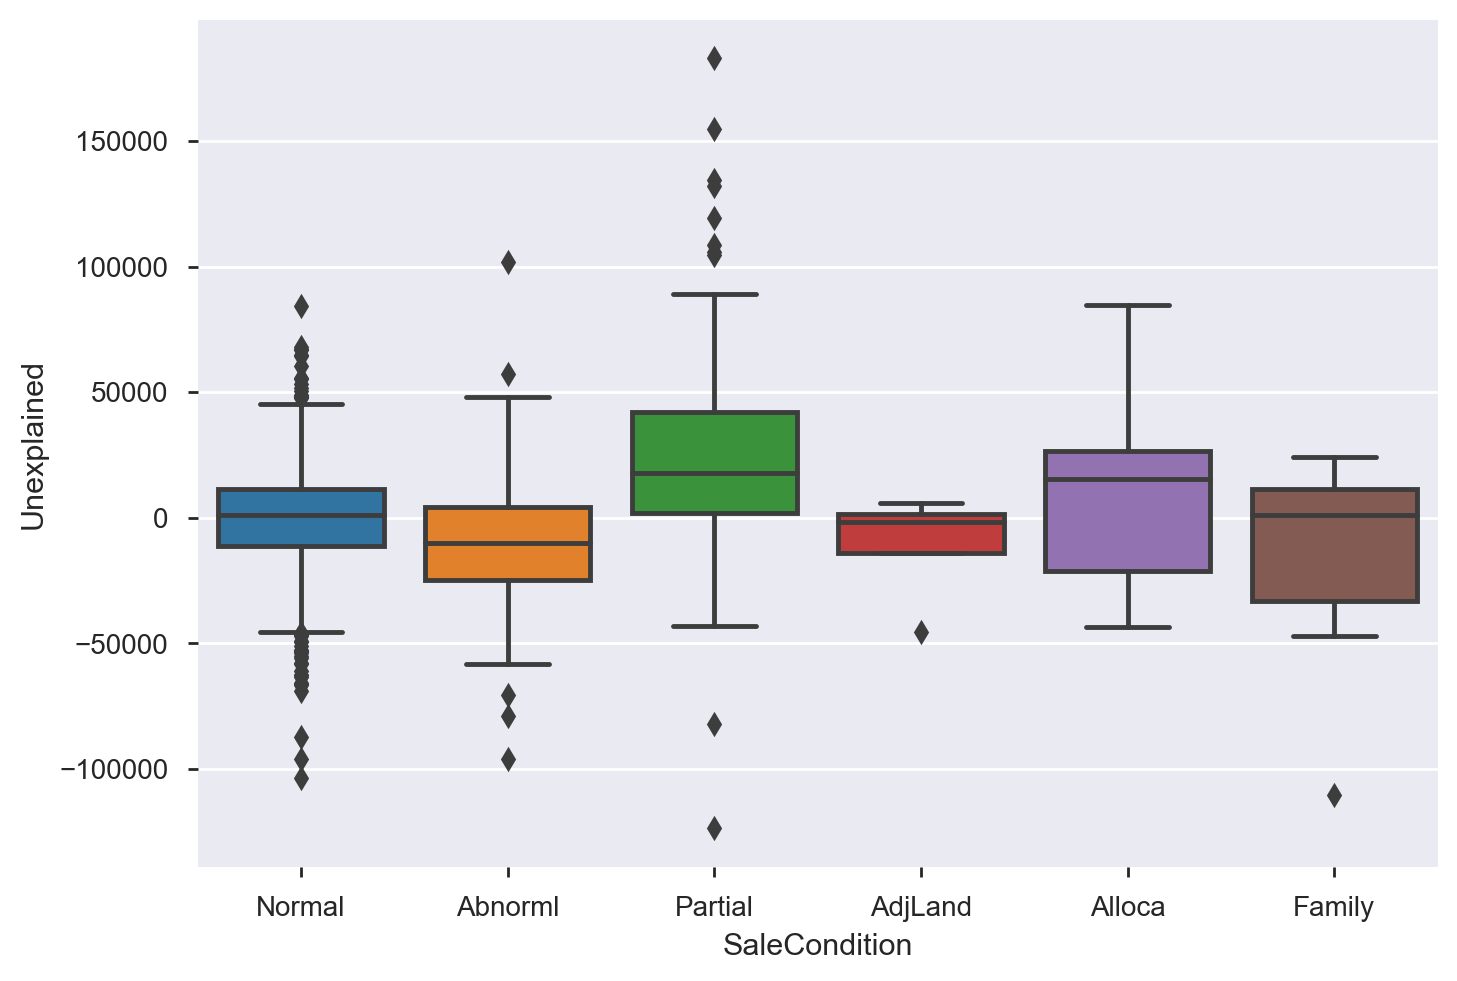

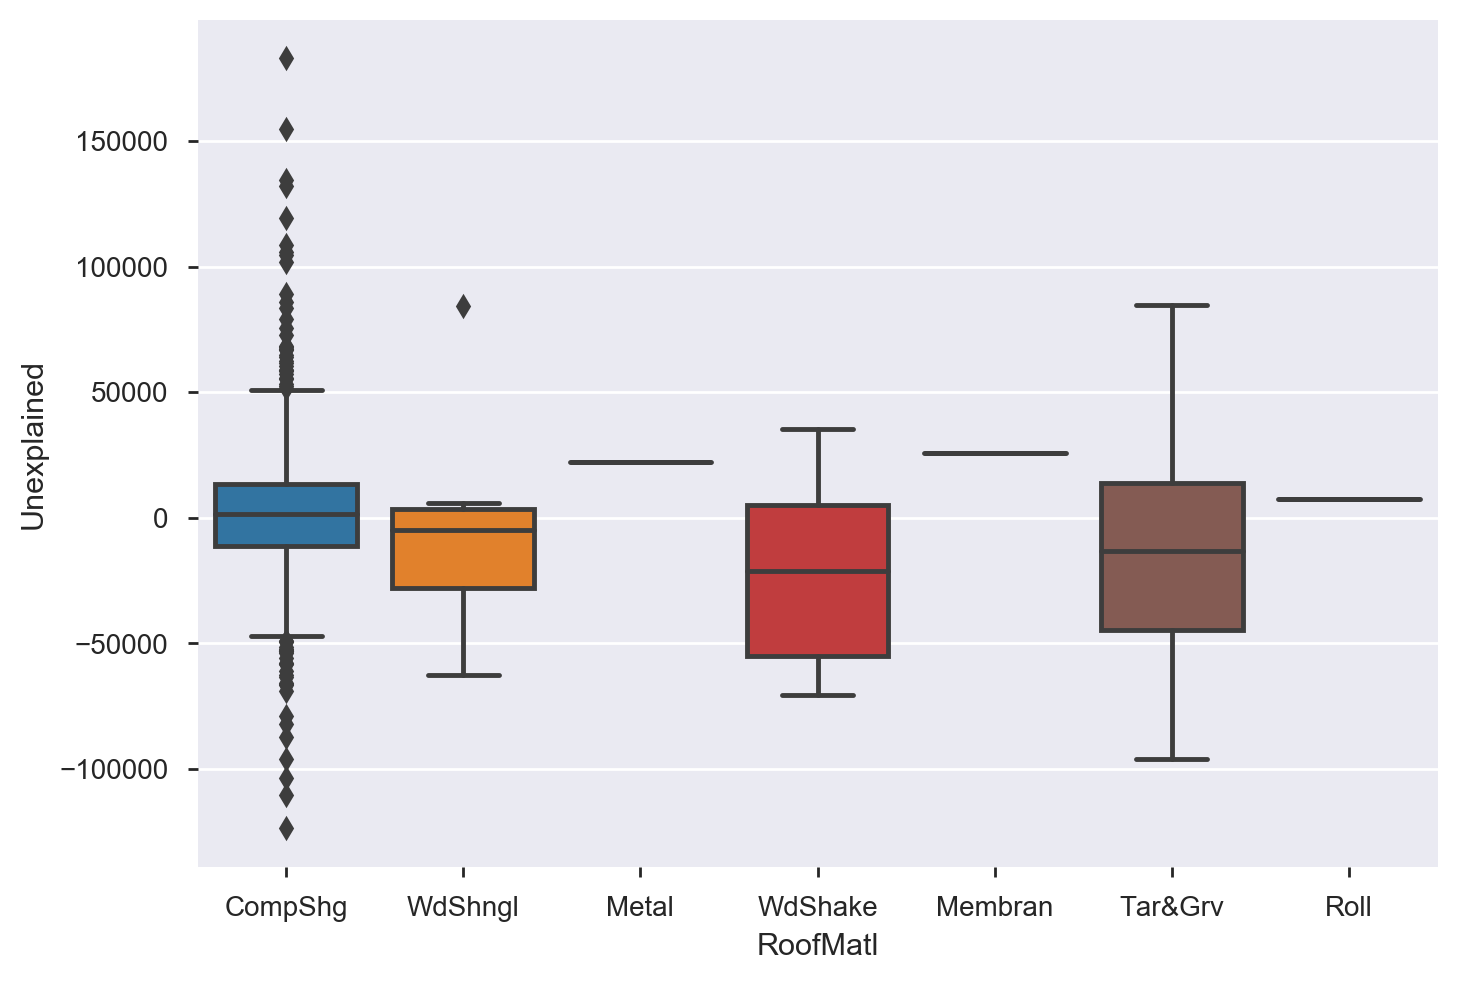

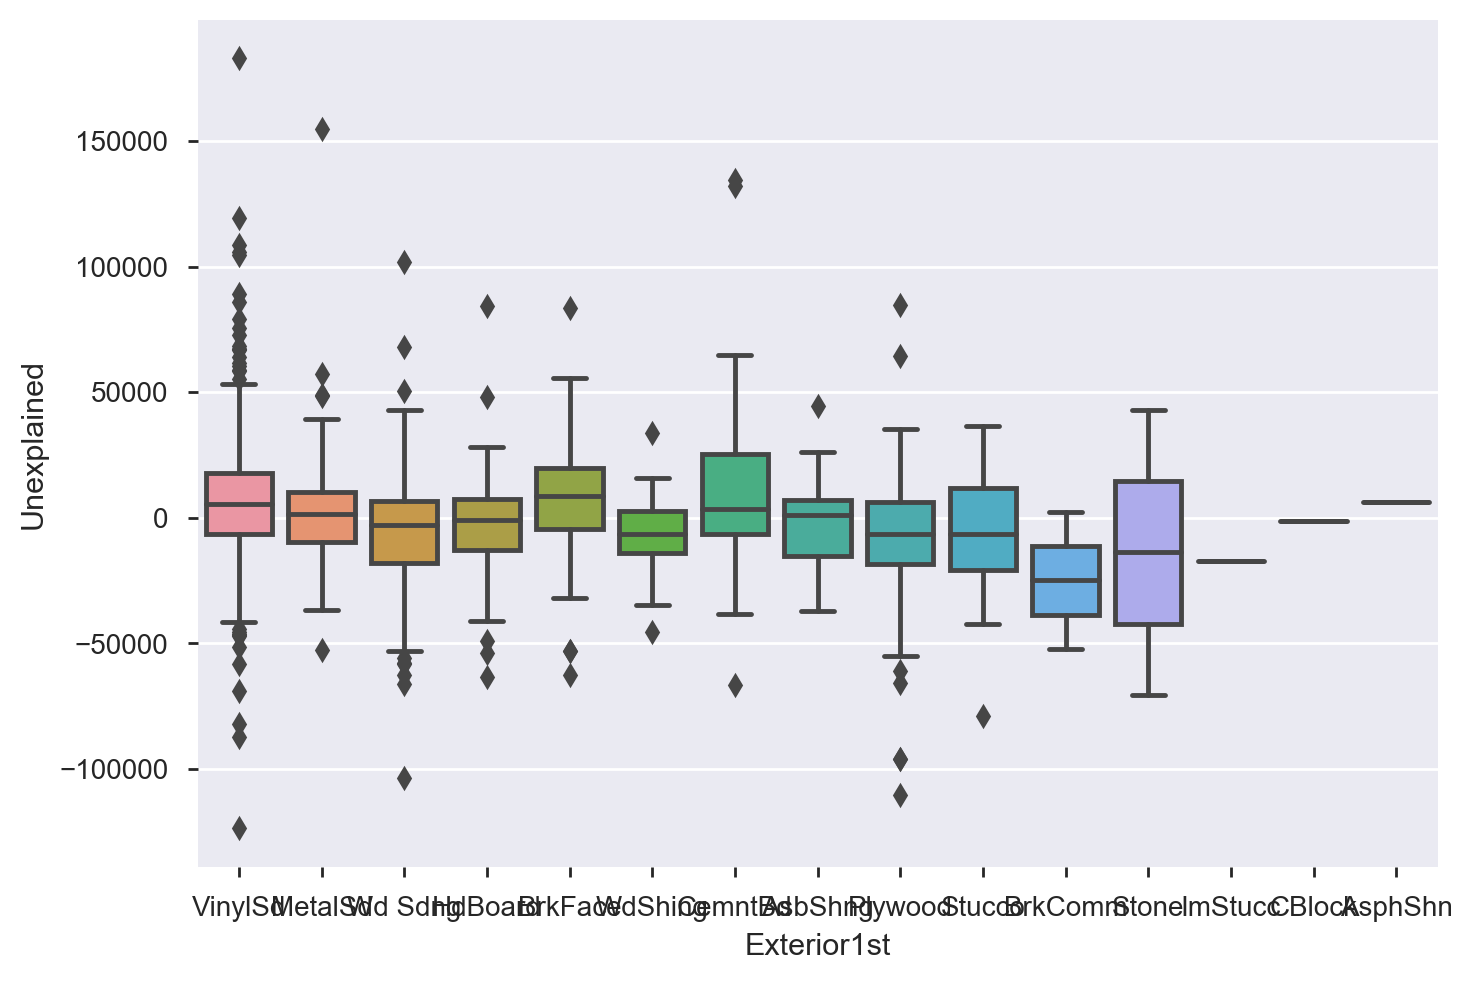

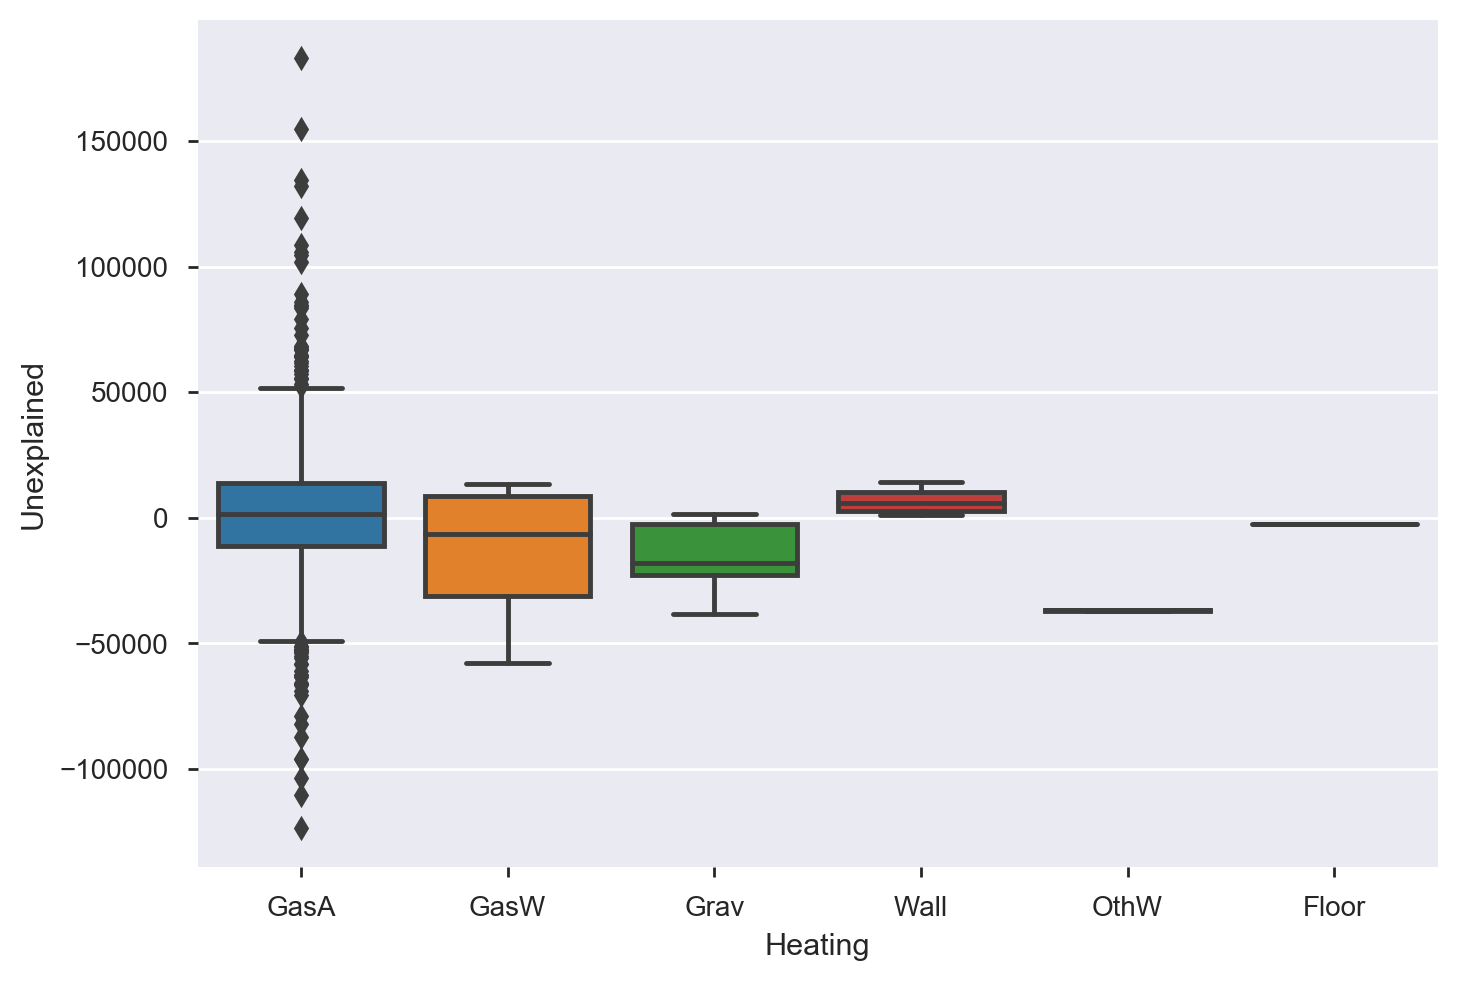

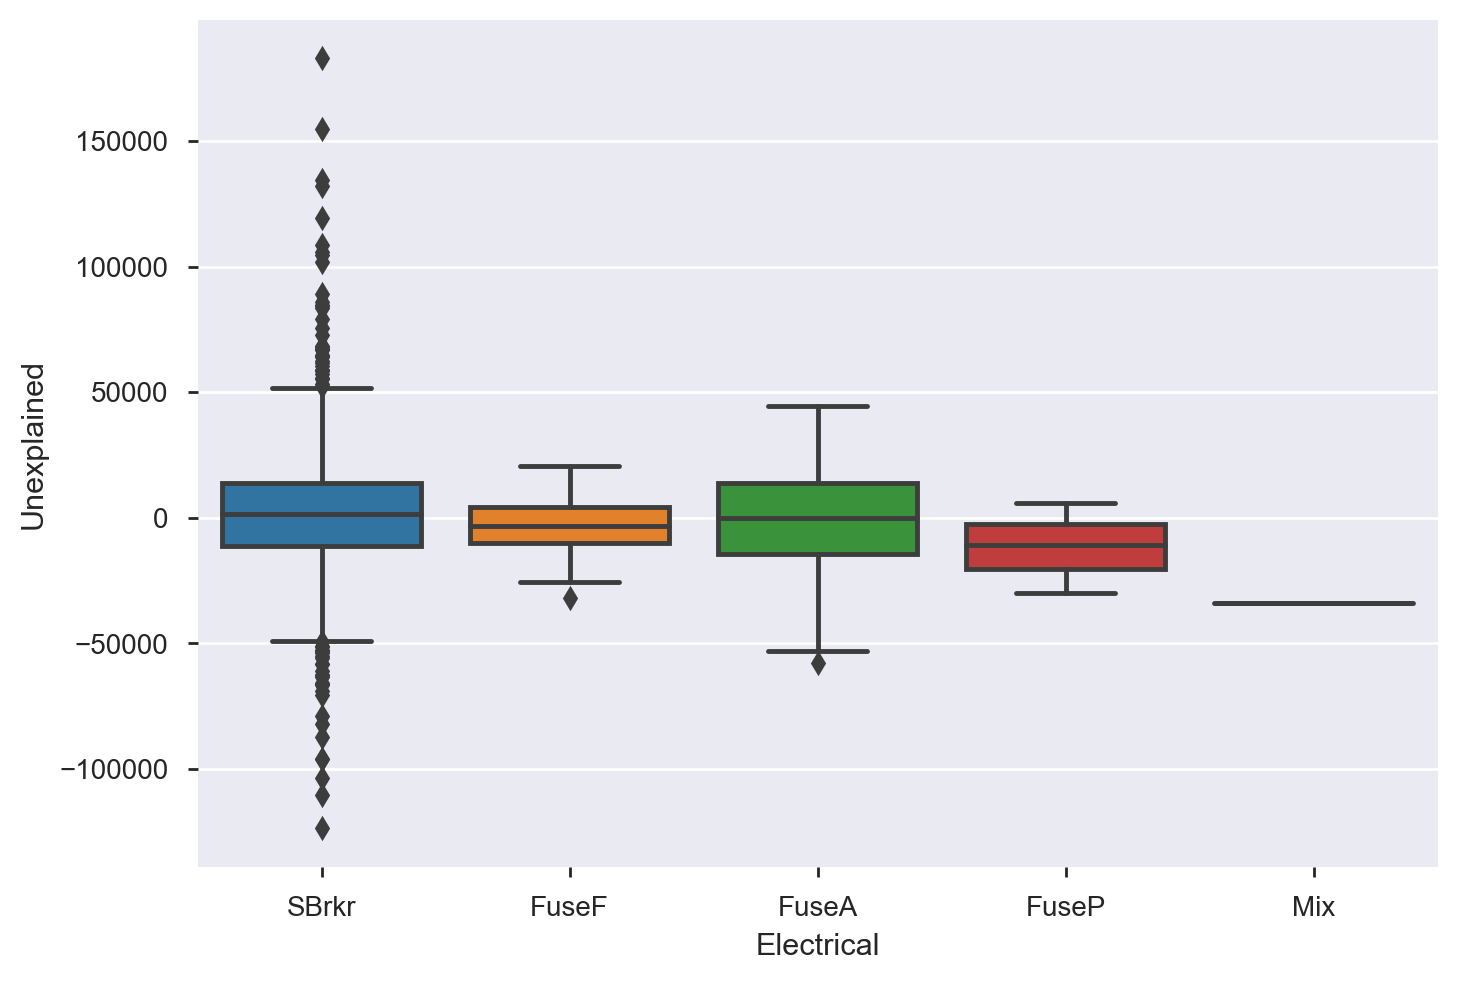

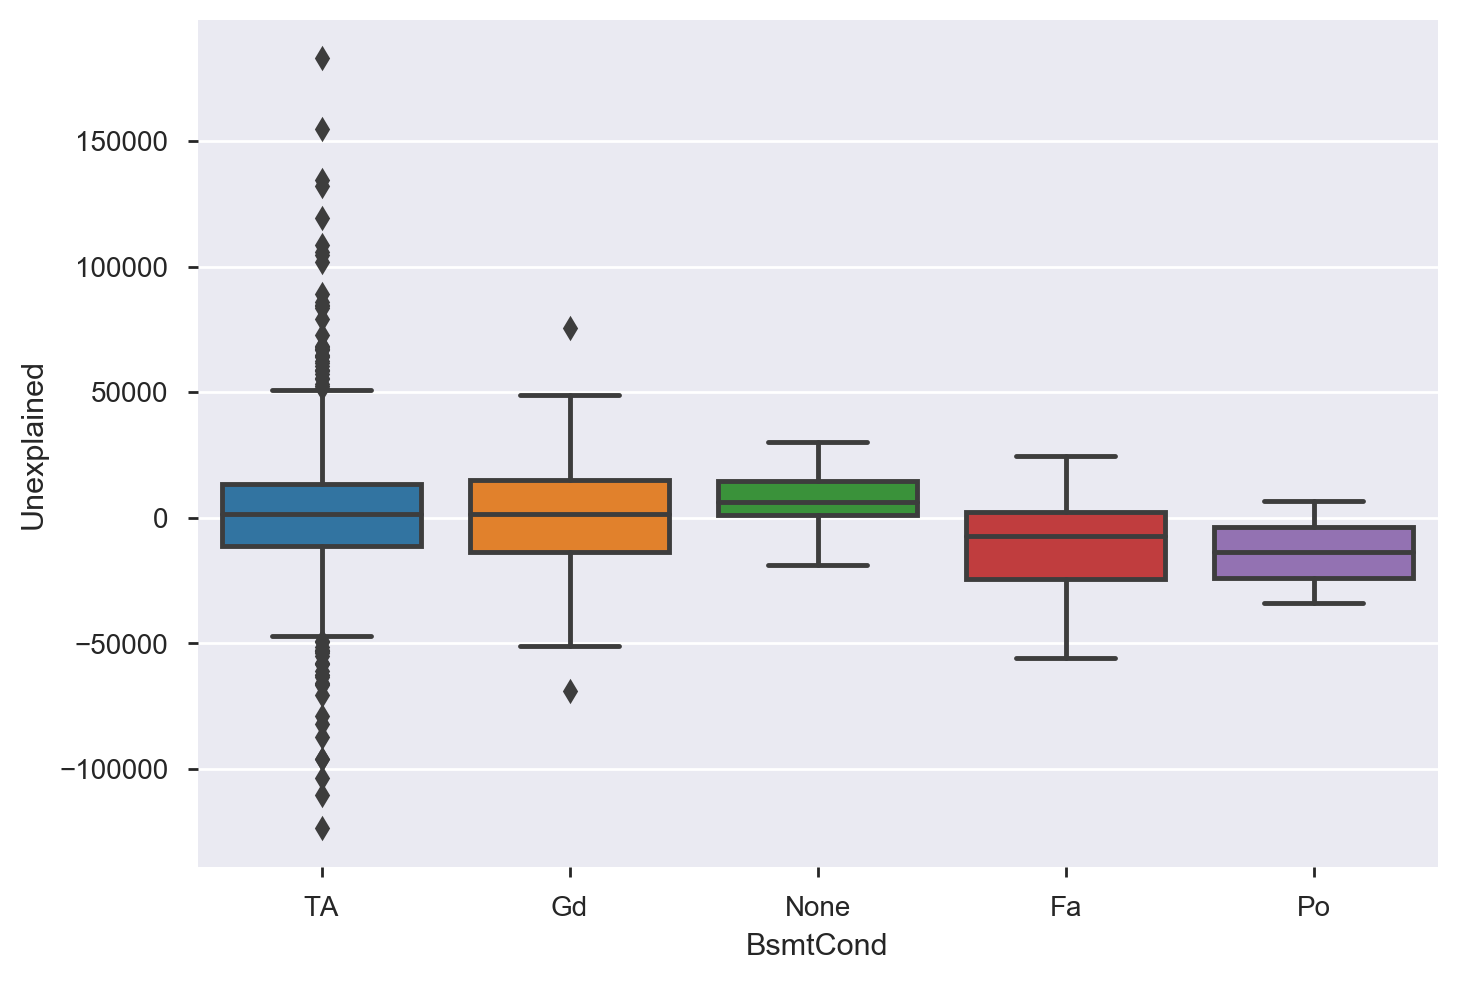

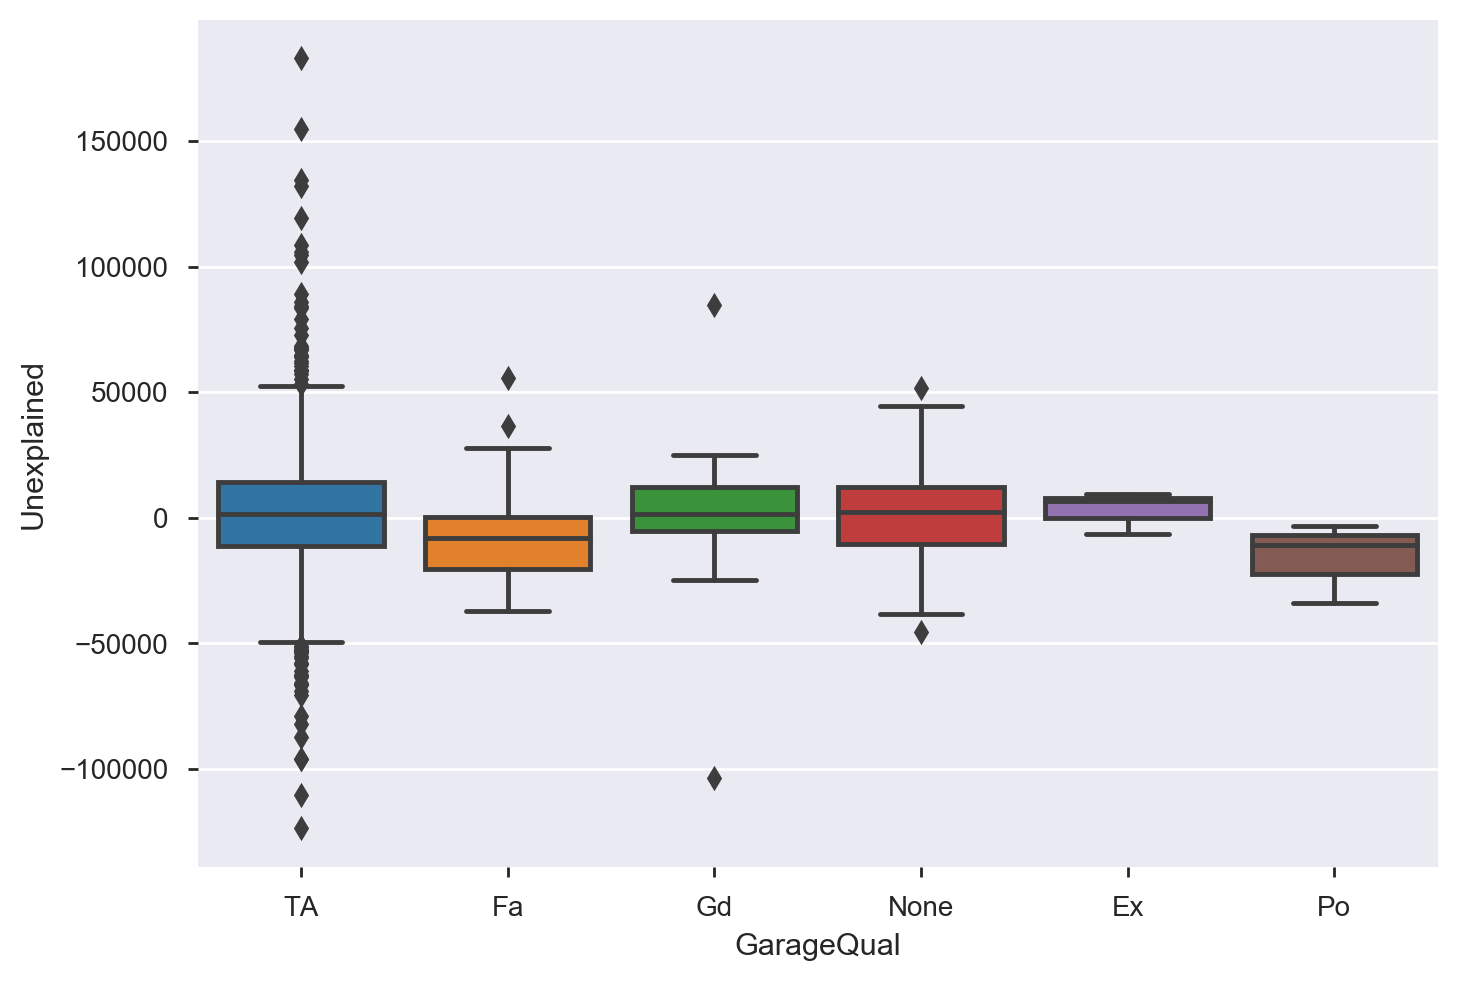

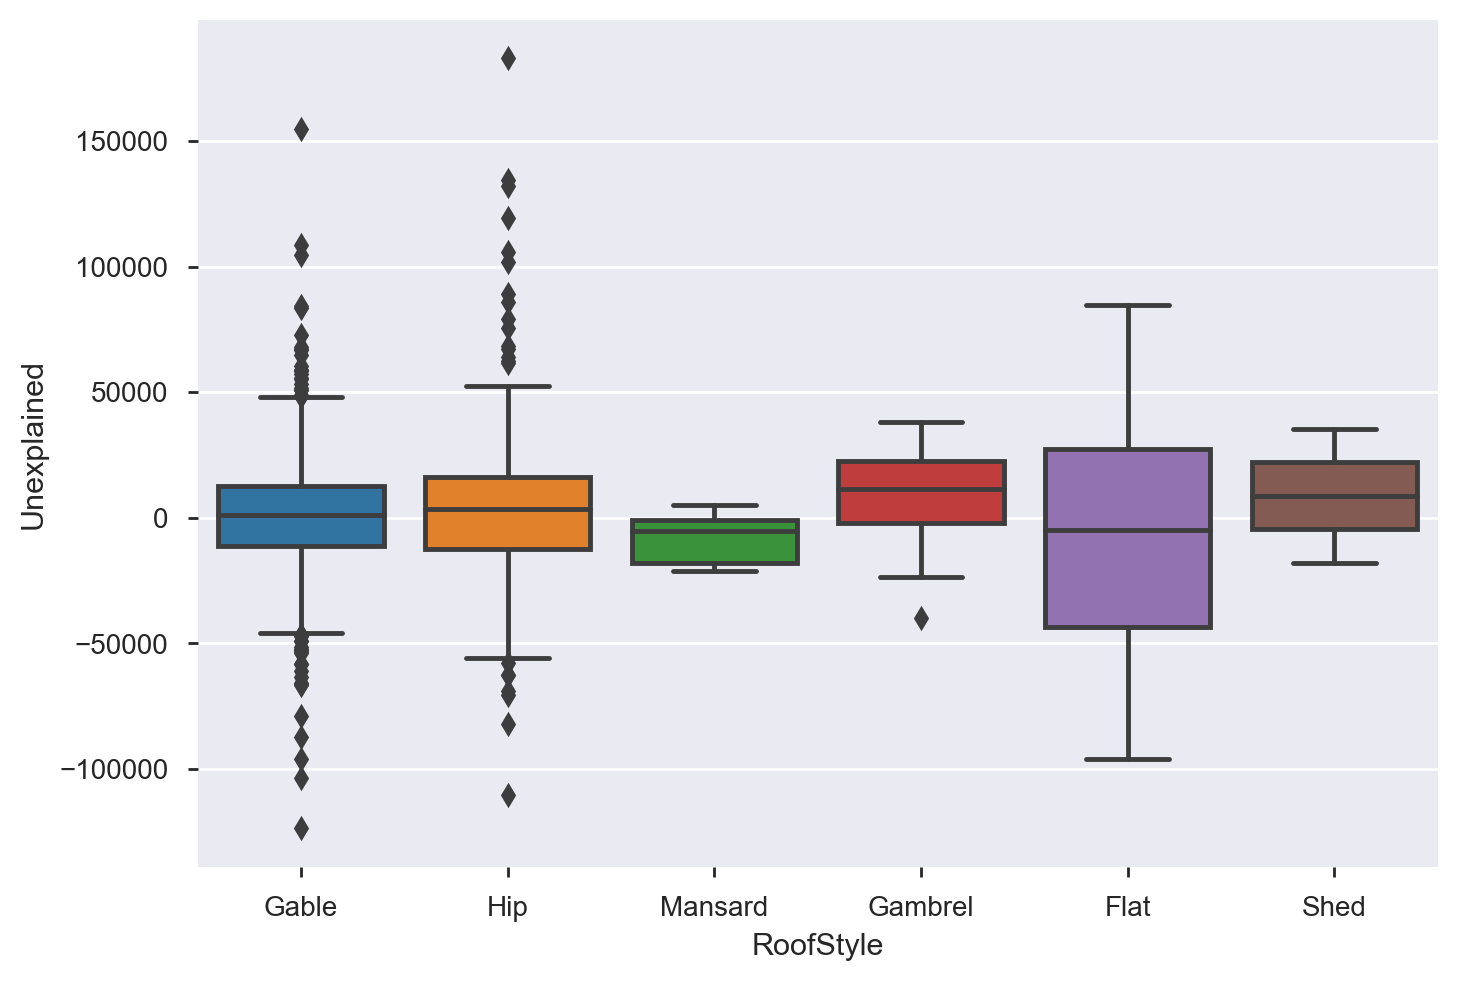

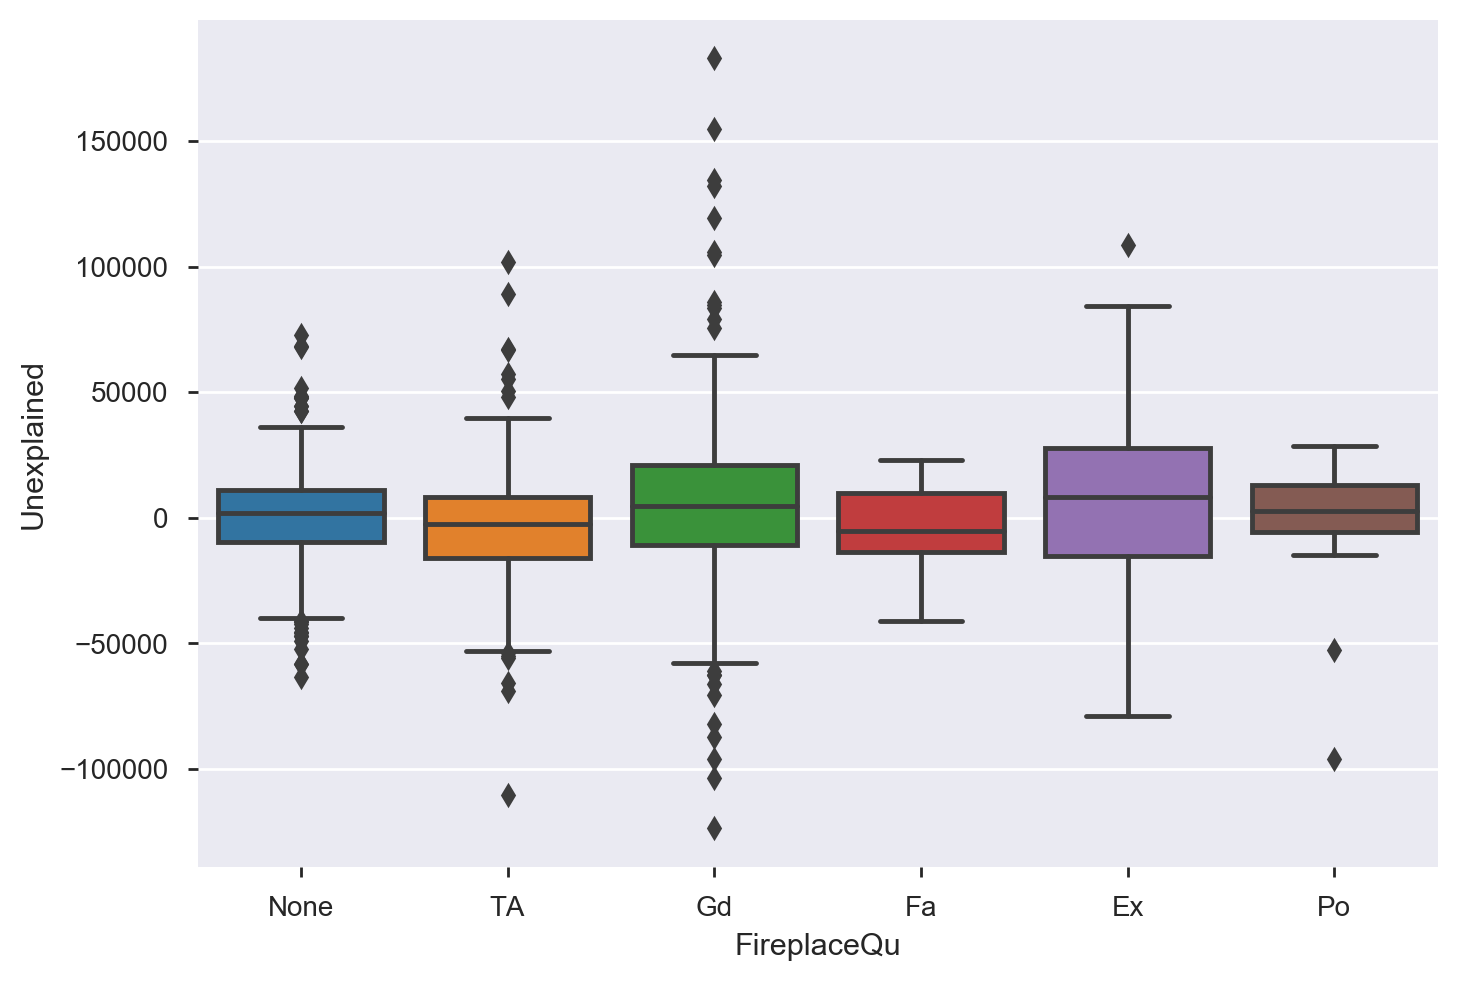

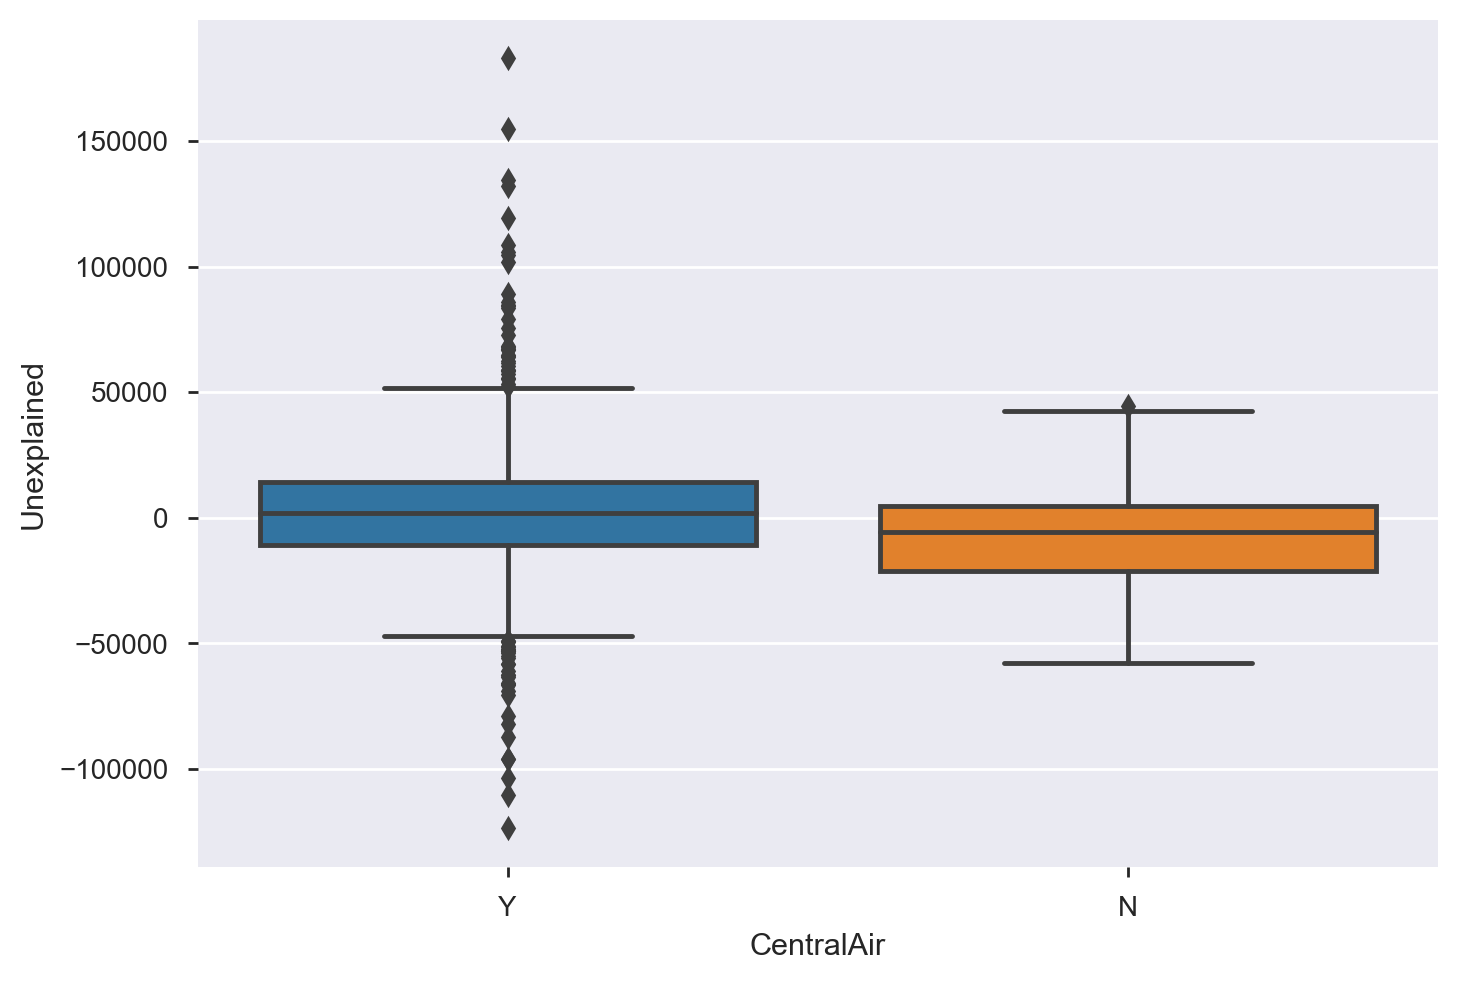

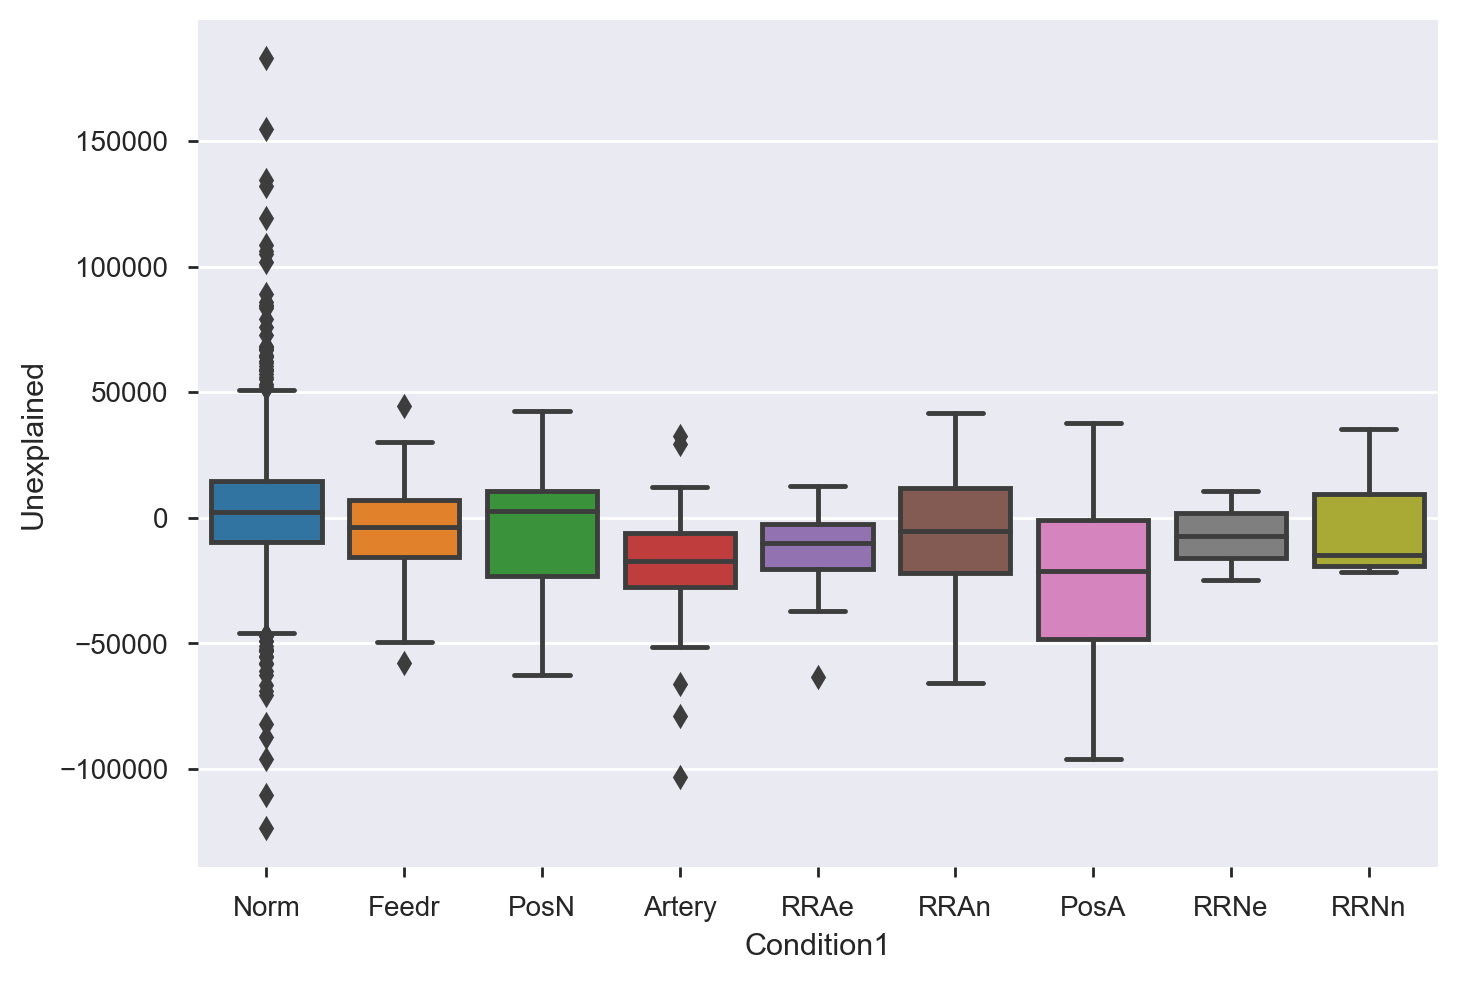

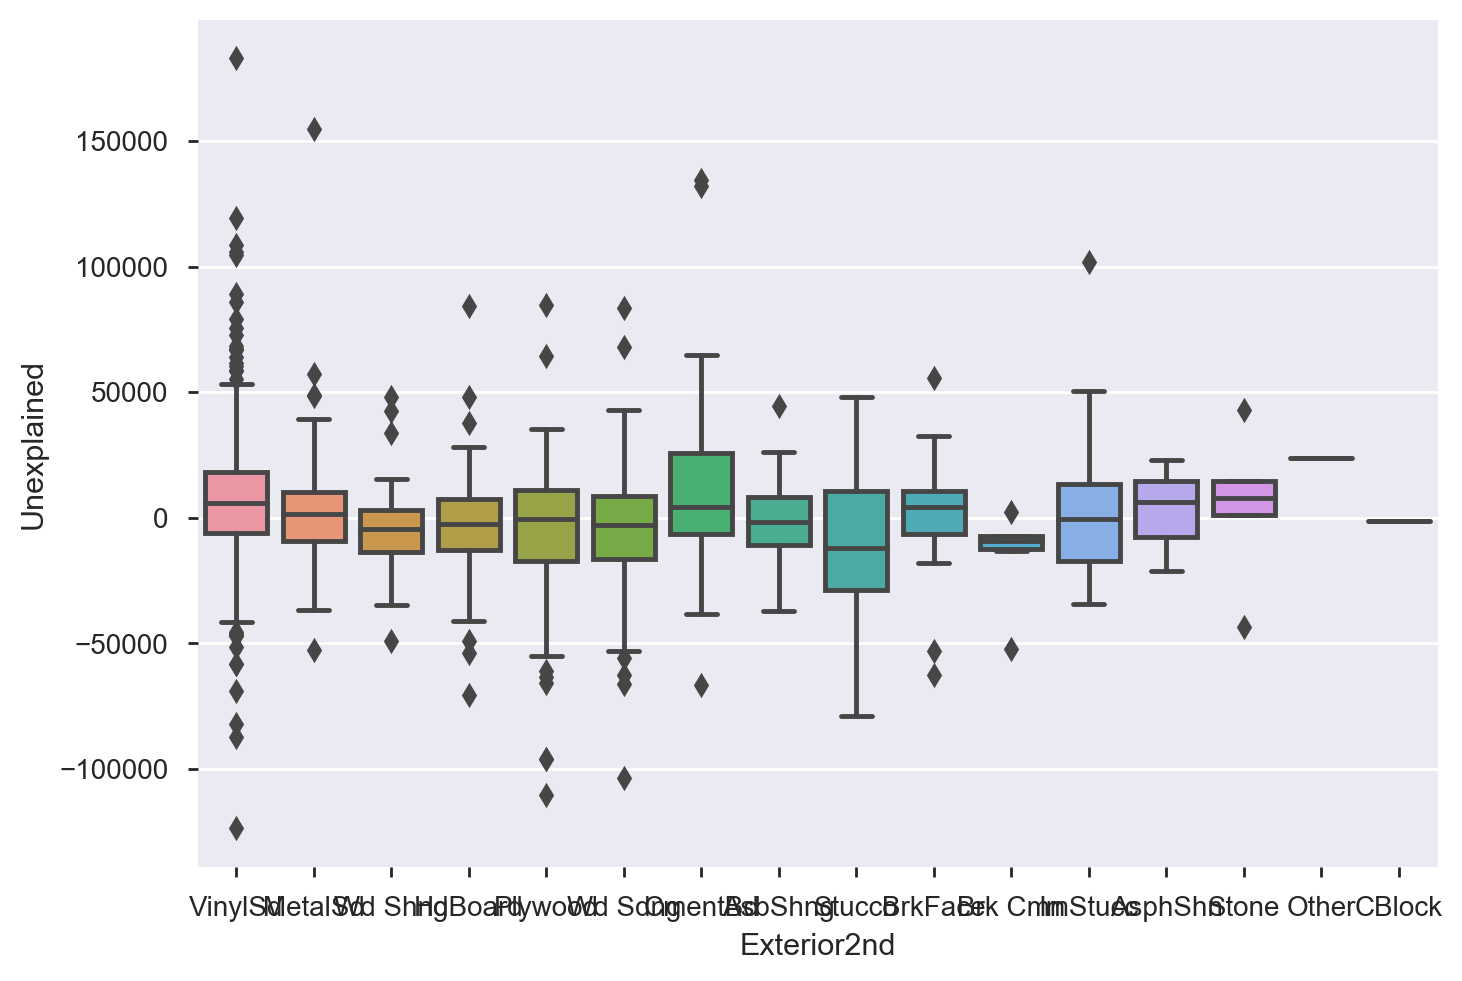

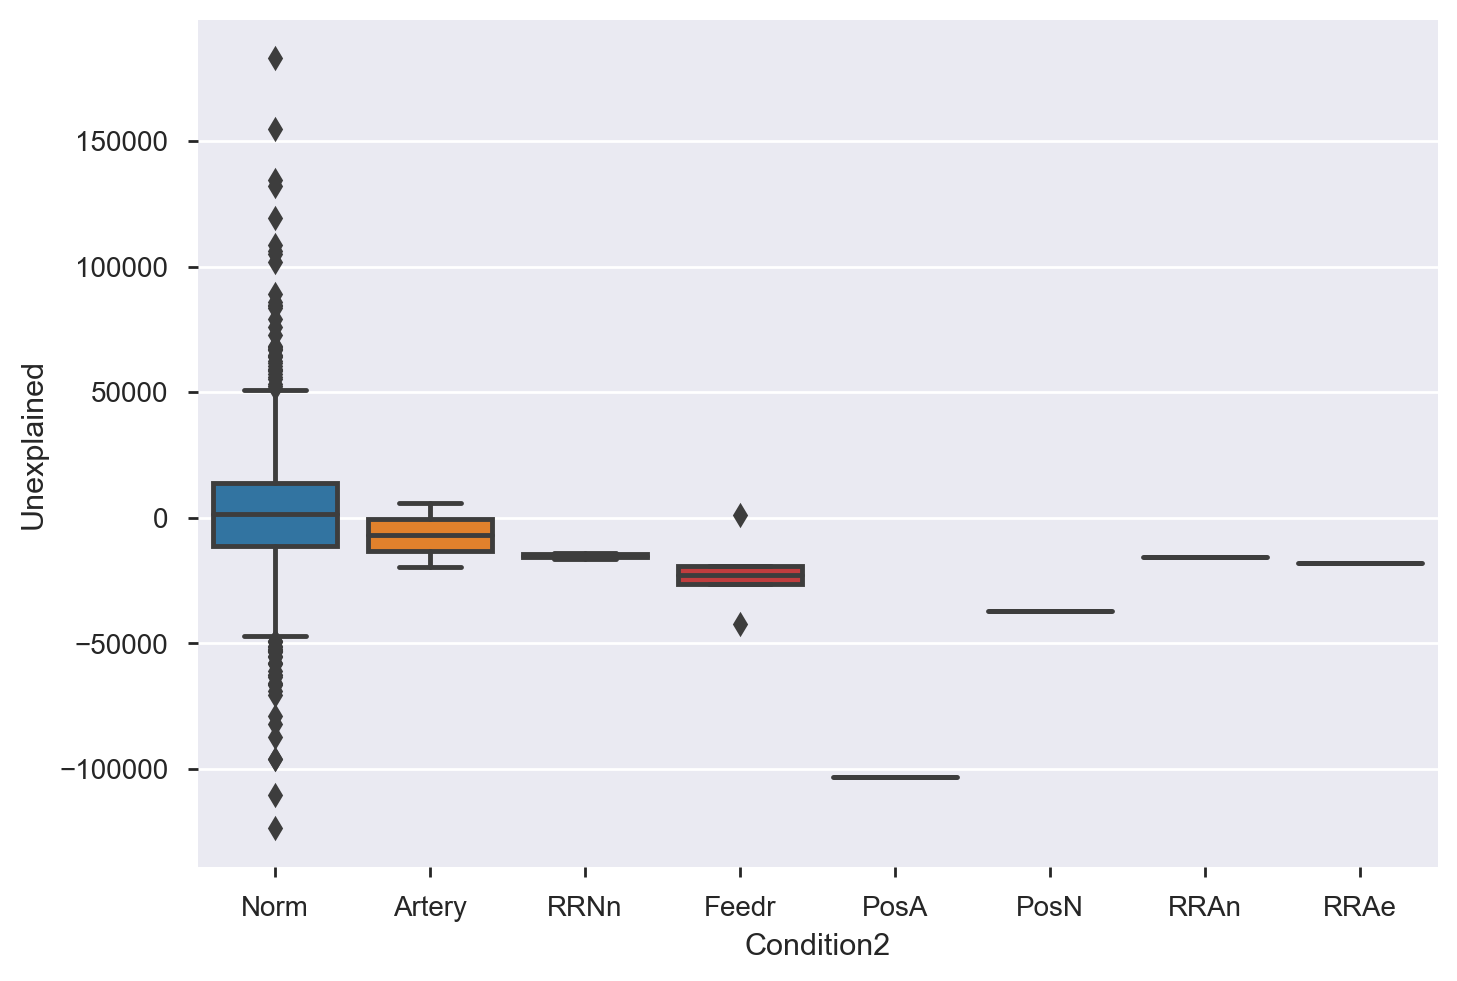

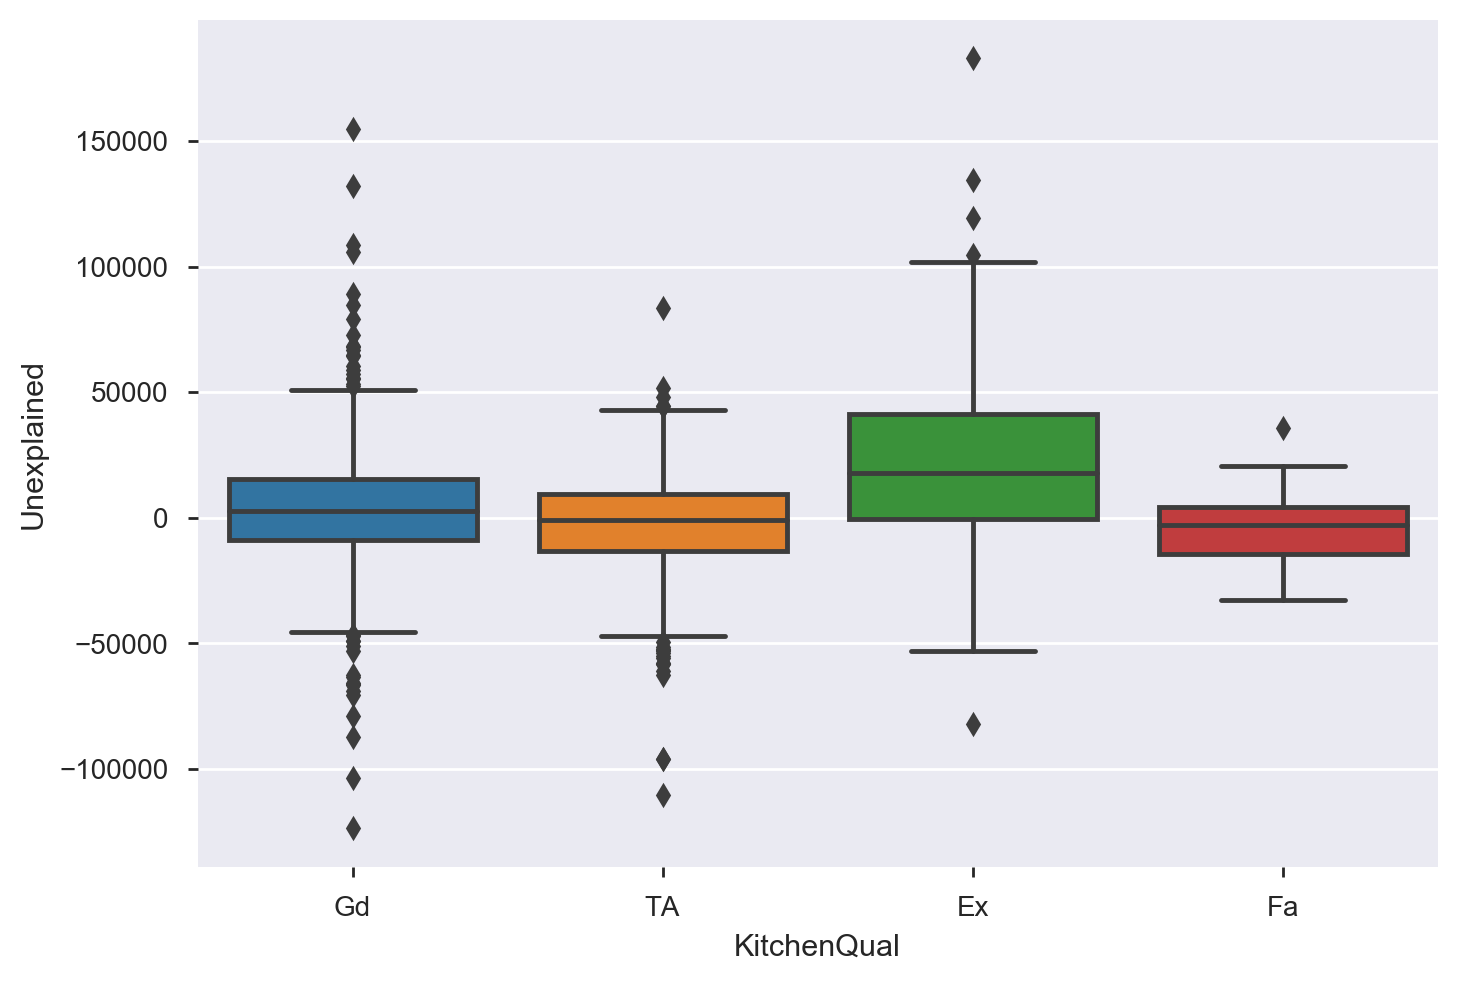

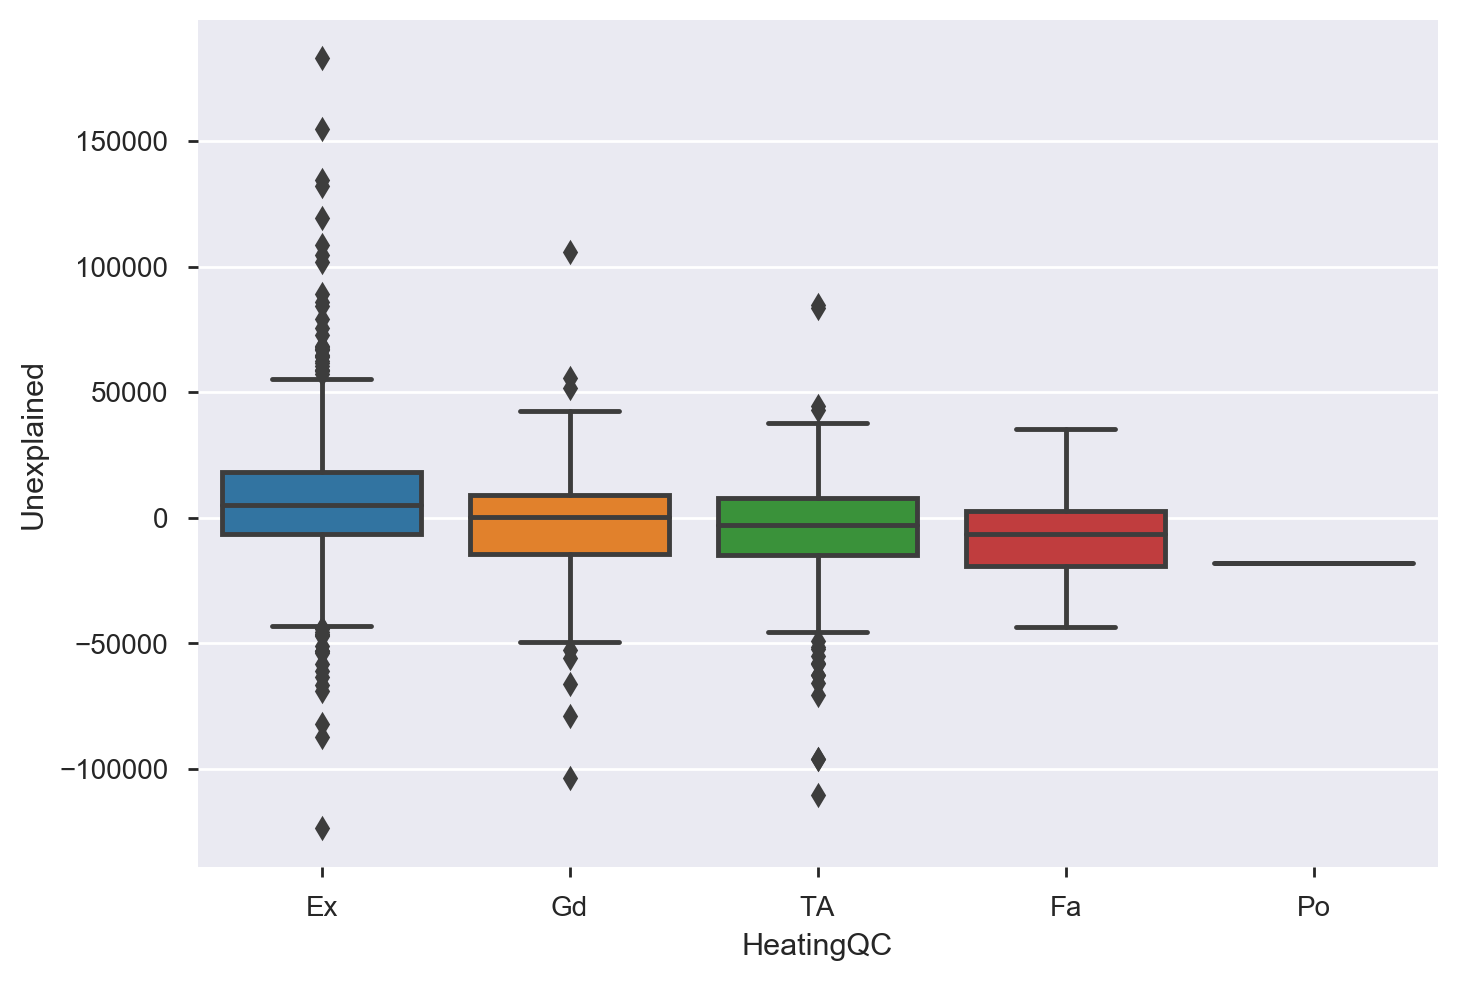

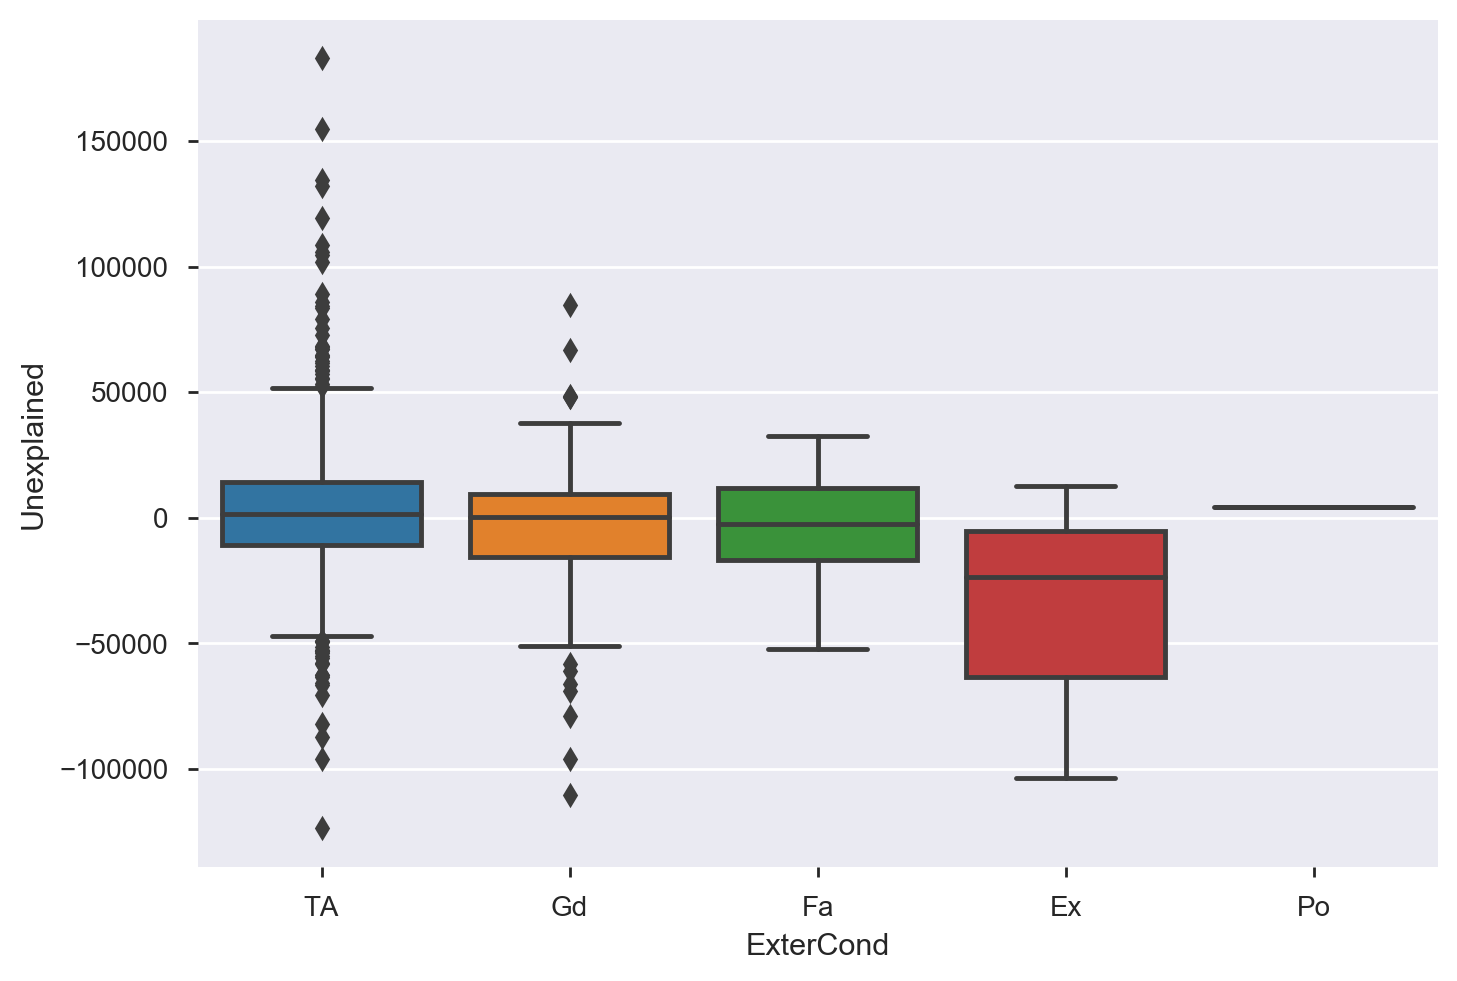

In [307]:
for col in newhouse2cat.columns.values:
    plt.figure(figsize=(5,5))
    sns.boxplot(x=col,y=newhouse2['Unexplained'],data=newhouse2)
    plt.xlabel(col)
    plt.show()

In [308]:
#drop all conditions columns with high carinality:
dropcl2 = []
for col in newhouse2cat.columns.values:
    if len(newhouse2cat[col].value_counts())>6:
        dropcl2.append(col)

In [309]:
newhouse2cat.drop(dropcl2,axis=1,inplace=True)
newhouse2cat.columns
#newhouse2cat.FireplaceQu.value_counts()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['GarageCond', 'Fence', 'BsmtQual', 'ExterQual', 'SaleCondition',
       'Heating', 'Electrical', 'BsmtCond', 'GarageQual', 'RoofStyle',
       'FireplaceQu', 'CentralAir', 'KitchenQual', 'HeatingQC', 'ExterCond'],
      dtype='object')

In [310]:
newhouse2cat = newhouse2cat.replace({
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
                        }
                     )

In [311]:
#LabelEncoder on features to keep information in the ordering categories
from sklearn.preprocessing import LabelEncoder
cols = newhouse2cat.select_dtypes(include='object')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(newhouse2cat[c].values)) 
    newhouse2cat[c] = lbl.transform(list(newhouse2cat[c].values)).astype(str)

In [ ]:
newhouse2cat.drop('SaleCondition',axis=1,inplace=True)

In [314]:
len(newhouse2cat.columns)

43

In [315]:
newhouse2cat = pd.get_dummies(newhouse2cat,drop_first=True)
X.shape

(1434, 90)

In [316]:
trainunx = newhouse2cat
#trainunx[['WoodDeckSF', 'MasVnrArea', 'MiscVal', 'LowQualFinSF','Porch']] = newhouse2num[['WoodDeckSF', 'MasVnrArea', 'MiscVal', 'LowQualFinSF','Porch']]
y_trainunx = newhouse2['Unexplained']

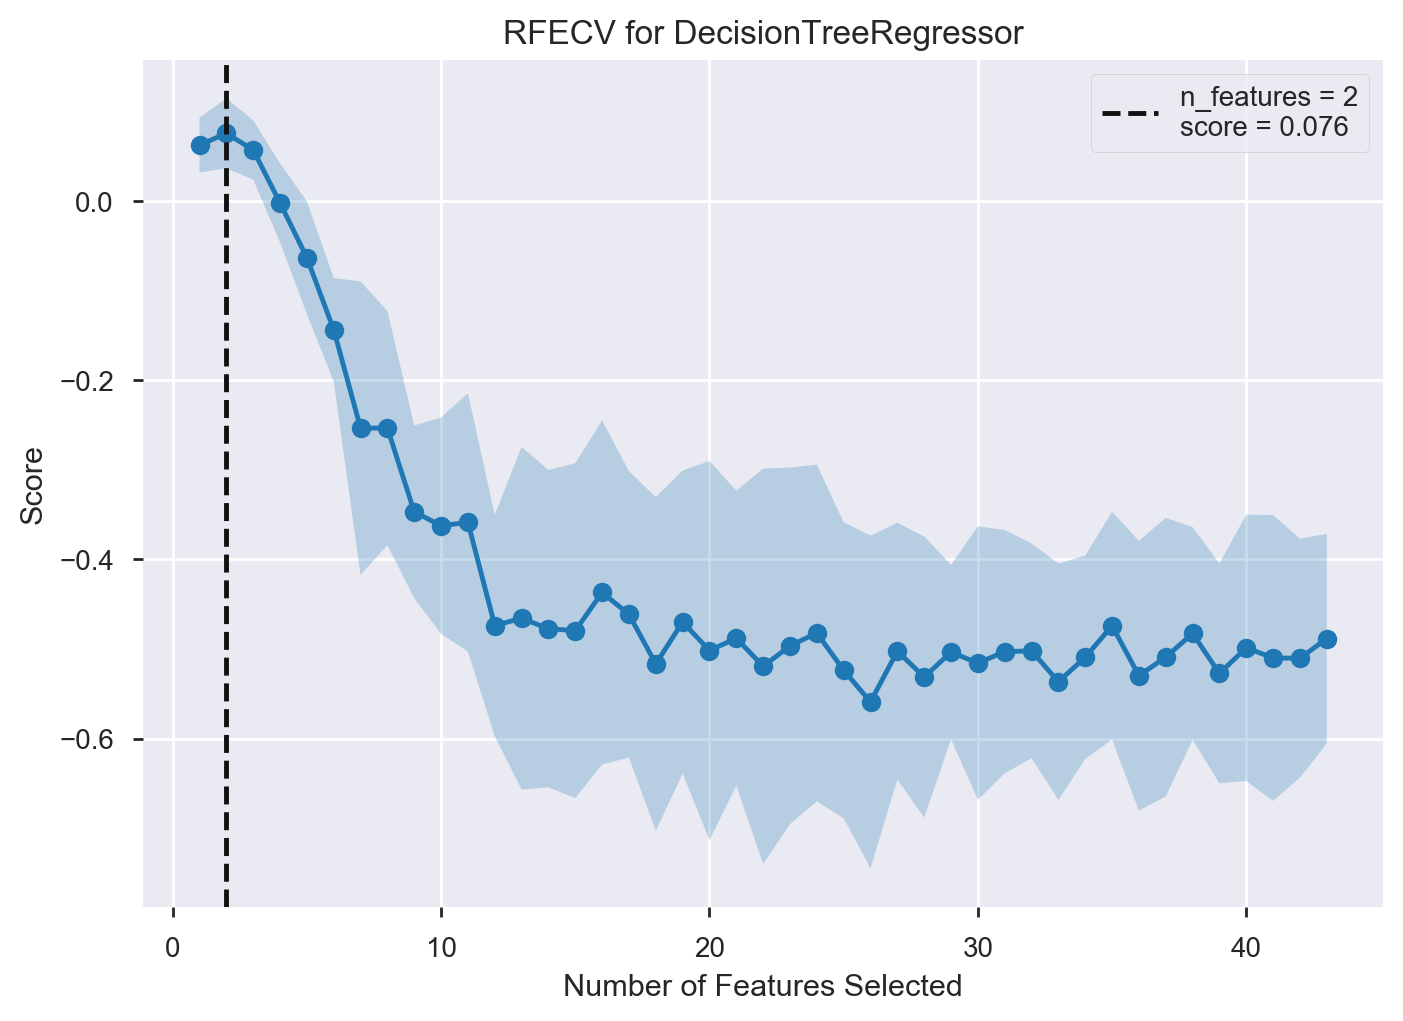

[False False False  True False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
['HeatingQC' 'BsmtQual_3']


In [318]:
#use decisiontree regressor to do feature selections
from yellowbrick.features import RFECV
from sklearn.tree import DecisionTreeRegressor

viz = RFECV(DecisionTreeRegressor(),cv=5)
viz.fit(trainunx, y_trainunx)
viz.poof()
print(viz.get_support())
print(trainunx.iloc[:,viz.get_support()].columns.values)
finalunx = trainunx.iloc[:,viz.get_support()].columns.values

In [320]:
trainunx1 = trainunx[finalunx]
trainunx1.shape

(1434, 2)

In [321]:
for folds in range(5,11):
    print('------------------------------------\n')
    print('K:', folds)
    model = LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, trainunx1.values, y_trainunx, cv=folds)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(model, trainunx1.values, y_trainunx, cv=folds)
    
    r2 = metrics.r2_score(y_trainunx, predictions)
    print("Cross-Predicted R2:", r2)
    print(predictions.max())

------------------------------------

K: 5
Cross-validated scores: [0.10884495 0.03008317 0.08785134 0.12169599 0.07290072]
Mean CV R2: 0.08427523560066319
Std CV R2: 0.031883950816795764
Cross-Predicted R2: 0.0876967651926055
26857.006783087258
------------------------------------

K: 6
Cross-validated scores: [0.1141425  0.05970687 0.08328229 0.06692053 0.09494561 0.10527346]
Mean CV R2: 0.08737854475710838
Std CV R2: 0.019556878020498696
Cross-Predicted R2: 0.09066682485326916
25576.265390140154
------------------------------------

K: 7
Cross-validated scores: [0.11856629 0.1214435  0.04033917 0.07885446 0.10759252 0.07092122
 0.10175892]
Mean CV R2: 0.09135372652587756
Std CV R2: 0.02723990918906474
Cross-Predicted R2: 0.09057683642314274
25833.753282924845
------------------------------------

K: 8
Cross-validated scores: [ 0.12235101  0.10253346 -0.05554371  0.12577711  0.024251    0.18177788
 -0.04097749  0.11774491]
Mean CV R2: 0.07223927044629007
Std CV R2: 0.0804783310224067

## Answer to Q2
Due to the good performance of the first model, we are barely able to attribute much of the error results from the first prediction to the renovable features. It is interesting that the second model barely explained less than 10 percent of the errors.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [3]:
# A:
house3 = pd.read_csv('../housing.csv')
house3.shape
house3.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [4]:
#Merge BsmtBath and BsmtHalfBath and convert it to Categorical feature
house3['TotalBsmtBath'] = house3['BsmtFullBath'] + house3['BsmtHalfBath']
house3.drop(['BsmtFullBath','BsmtHalfBath'],axis=1,inplace=True)
#Merge FullBath and HalfBath
house3['TotalBath'] = house3['FullBath'] + house3['HalfBath']
house3.drop(['FullBath','HalfBath'],axis=1,inplace=True)
#Merge BsmtFinSF1 and BsmtFinSF2
#house['BsmtFinSF'] = house['BsmtFinSF1'] + house['BsmtFinSF2']
house3.drop(['BsmtFinSF1','BsmtFinSF2'],axis=1,inplace=True)
#TotalSF
house3['PricePerSF'] = house3['SalePrice']/(house3['GrLivArea']+house3['TotalBsmtSF'])
house3['Porch'] = house3['EnclosedPorch'] + house3['ScreenPorch'] +\
house3['OpenPorchSF']+house3['3SsnPorch']
house3.drop(['EnclosedPorch','ScreenPorch','OpenPorchSF','3SsnPorch'],axis=1,inplace=True)

In [5]:
house3["LotFrontage"] = house3.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [6]:
house3.drop(['Id','YearBuilt','GarageYrBlt','YearRemodAdd','MoSold','YrSold'],axis=1,inplace=True)
numeric3 = house3.select_dtypes(exclude='object').columns.values

In [7]:
catq3 = ["BsmtCond","BsmtQual","ExterCond","ExterQual",
         "FireplaceQu","GarageCond","GarageQual","HeatingQC","KitchenQual"]
for col in catq3:
    house3[col] = house3[col].fillna('None')

In [8]:
house3 = house3.replace({
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
                        }
                     )
q3cat = house3[catq3]

In [9]:
### LabelEncoder on features to keep information in the ordering categories
from sklearn.preprocessing import LabelEncoder
cols = q3cat.select_dtypes(include='object')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(q3cat[c].values)) 
    q3cat[c] = lbl.transform(list(q3cat[c].values)).astype(str)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


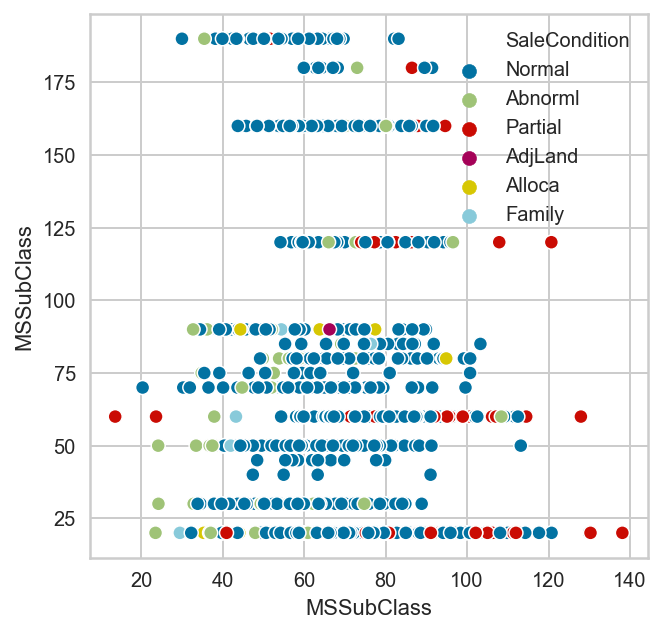

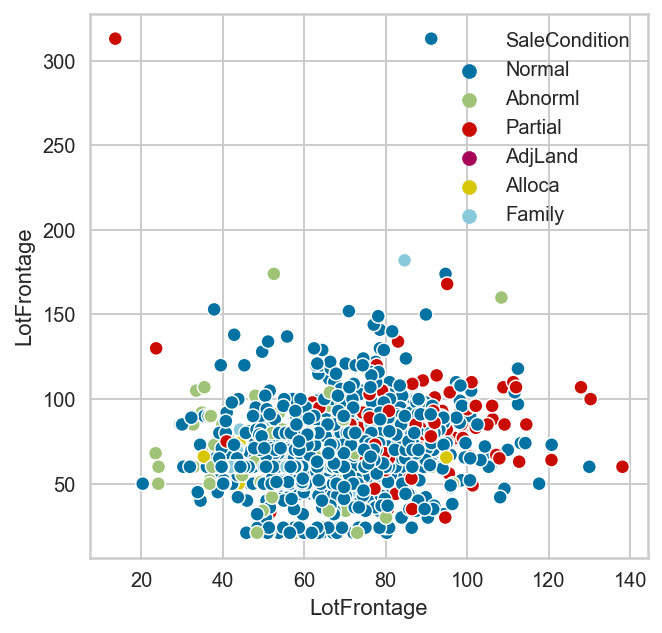

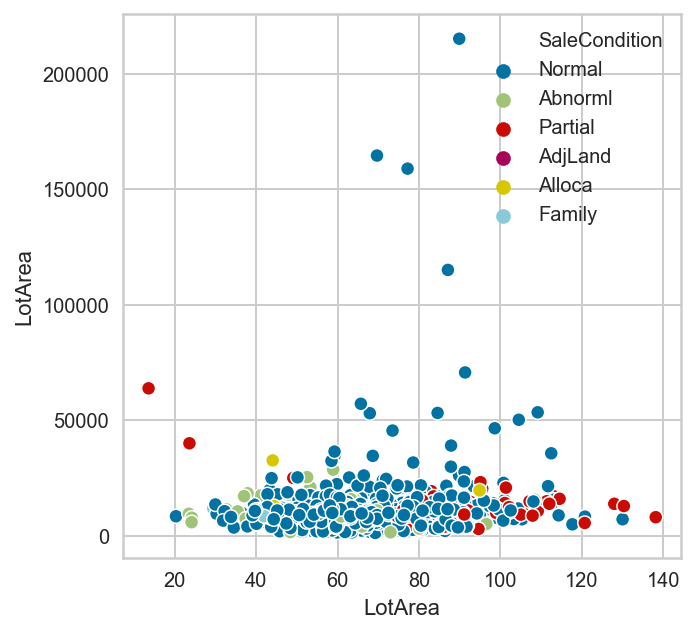

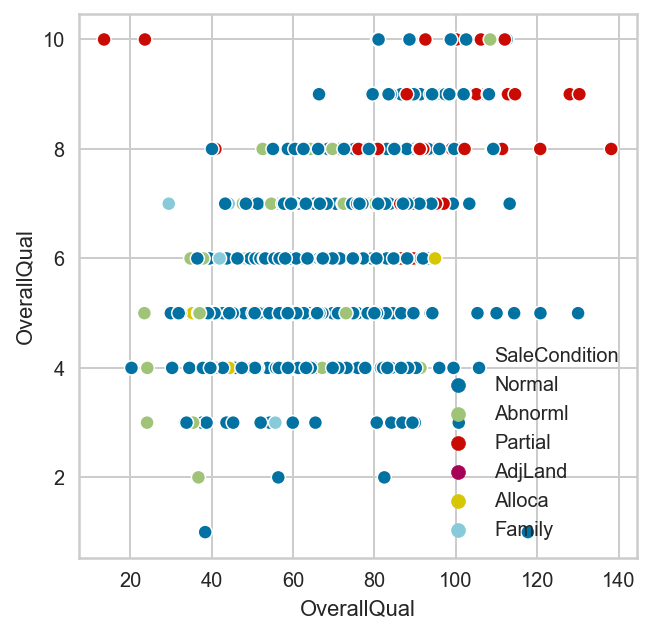

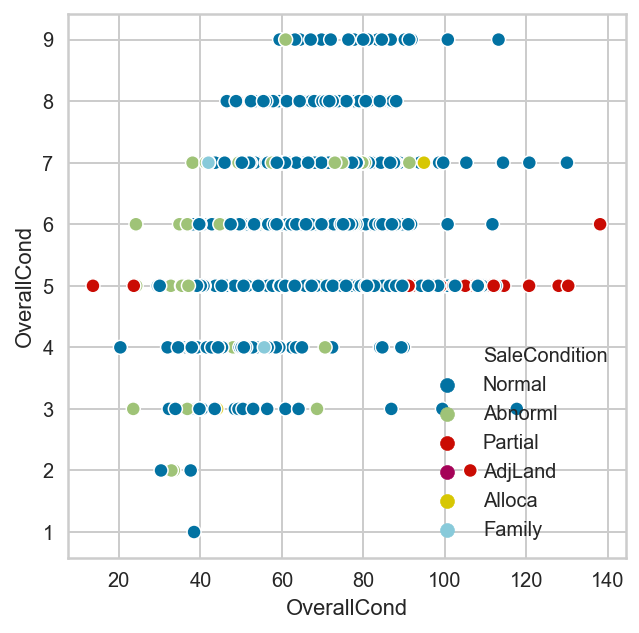

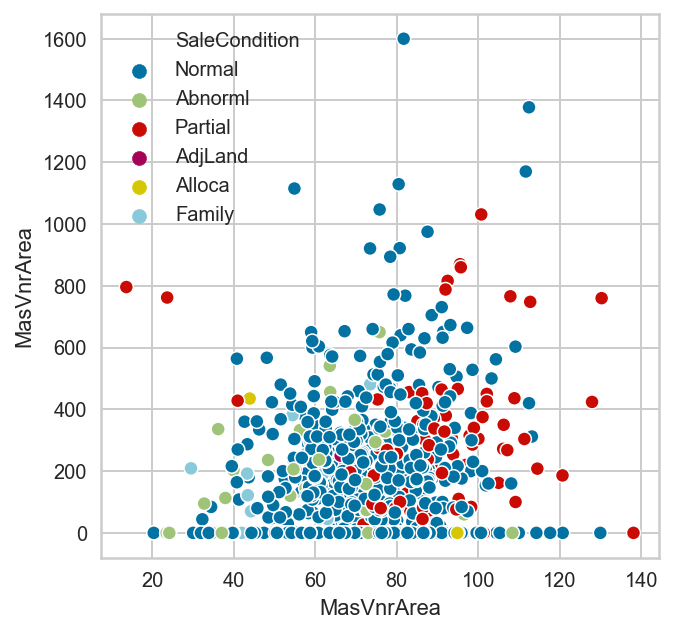

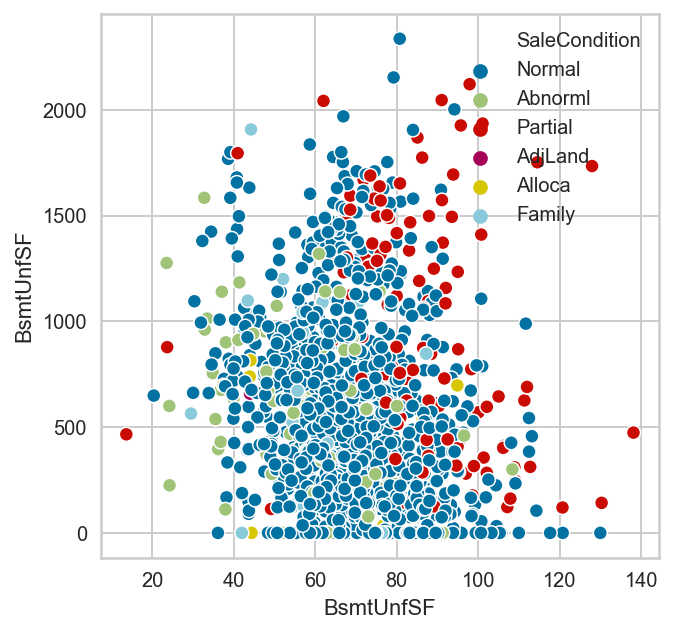

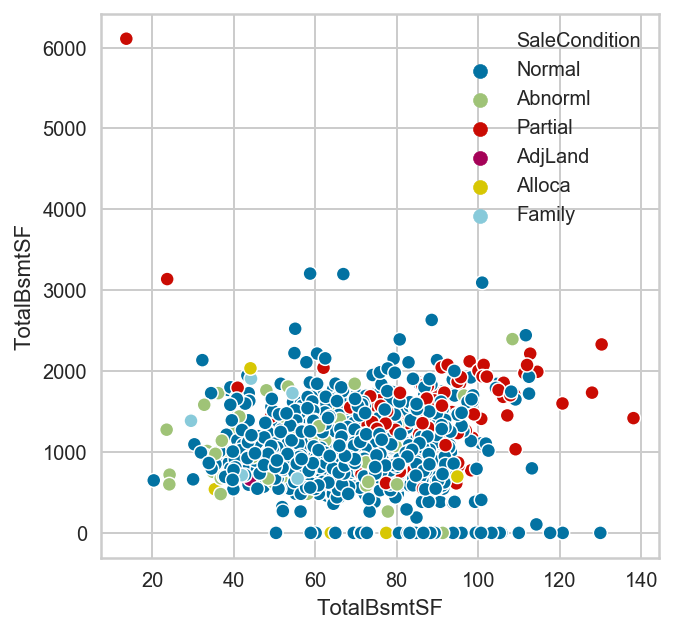

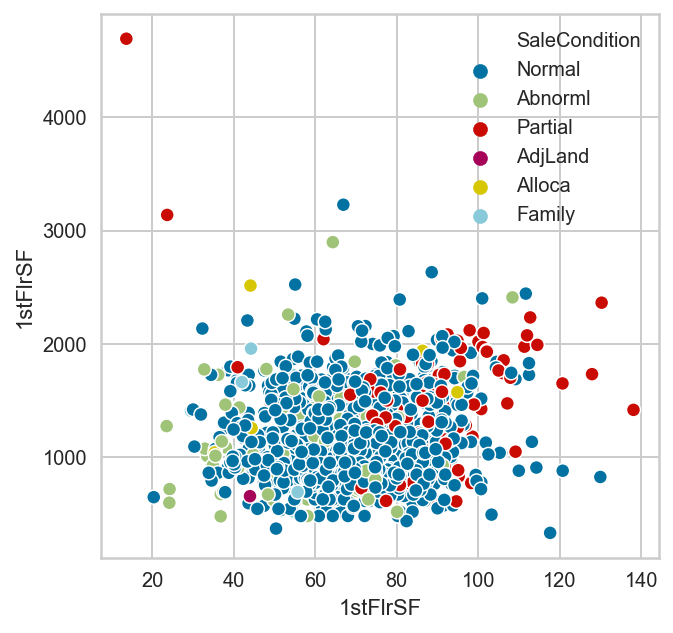

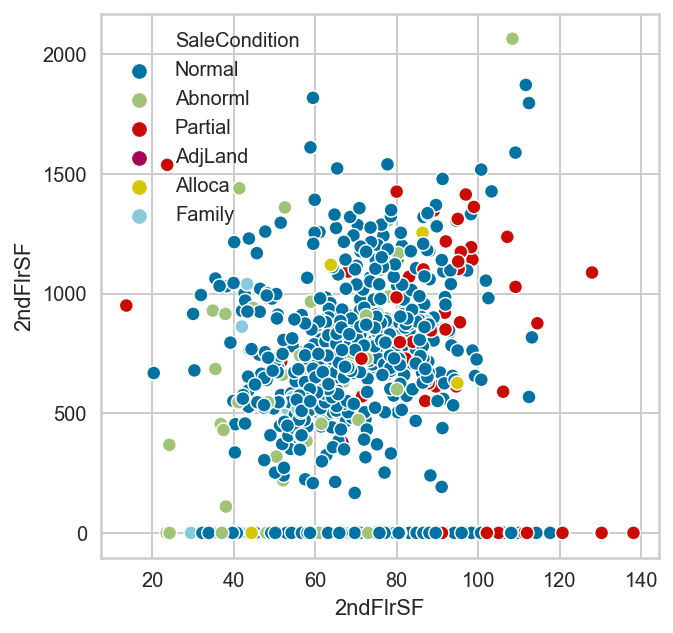

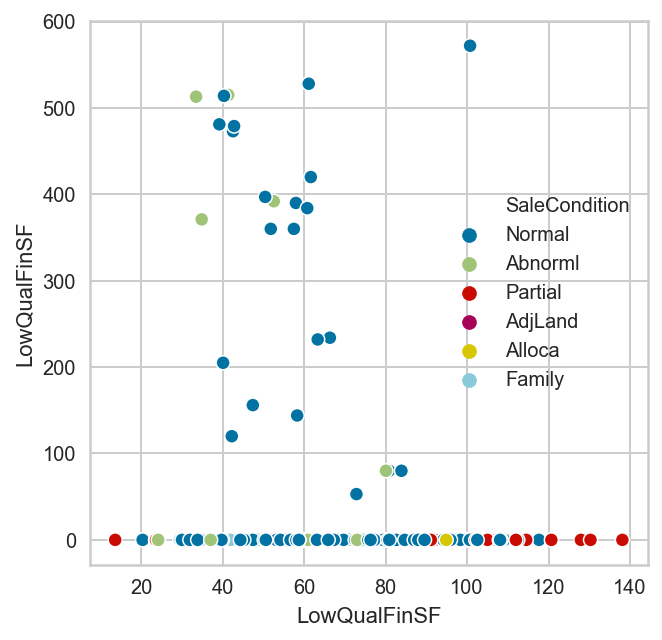

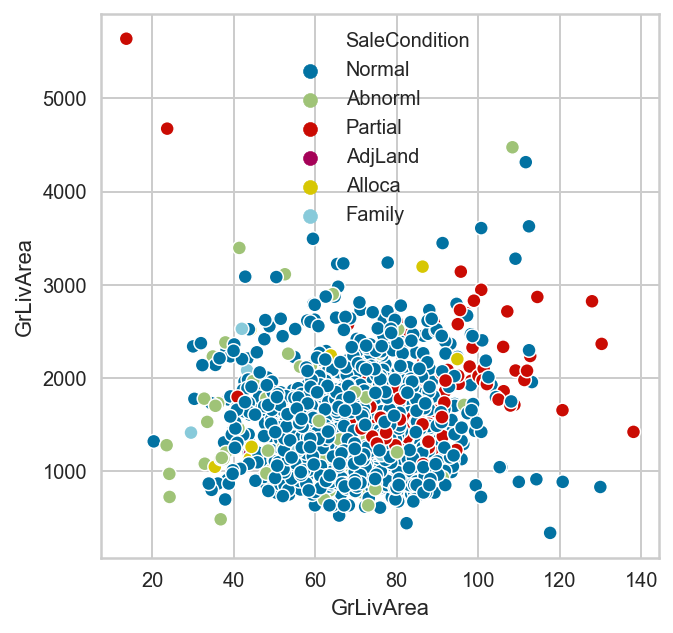

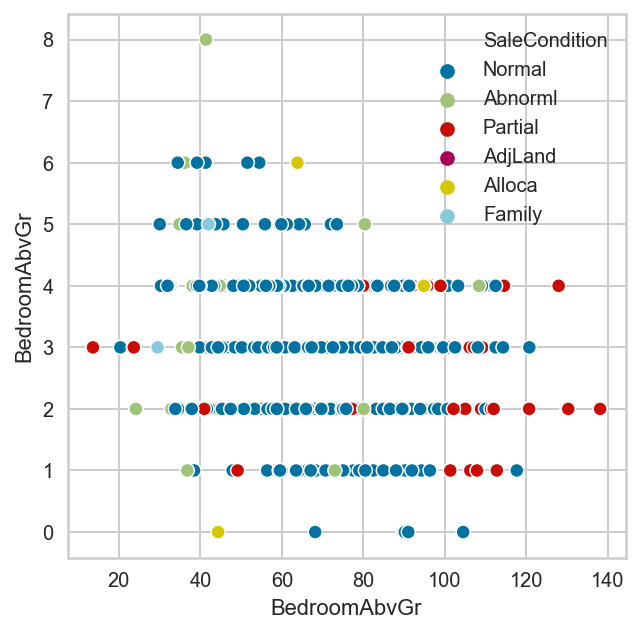

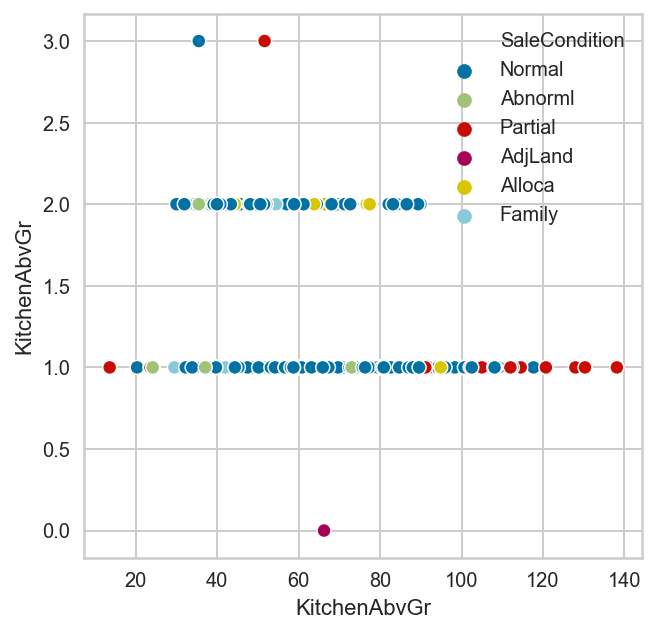

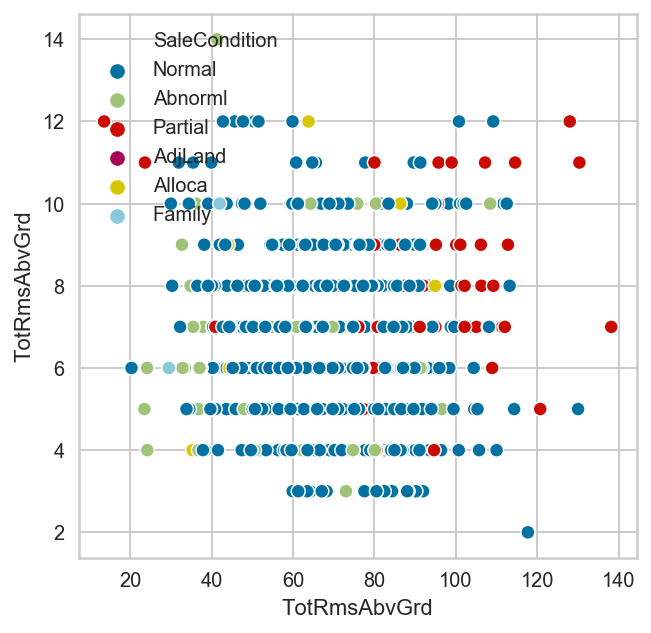

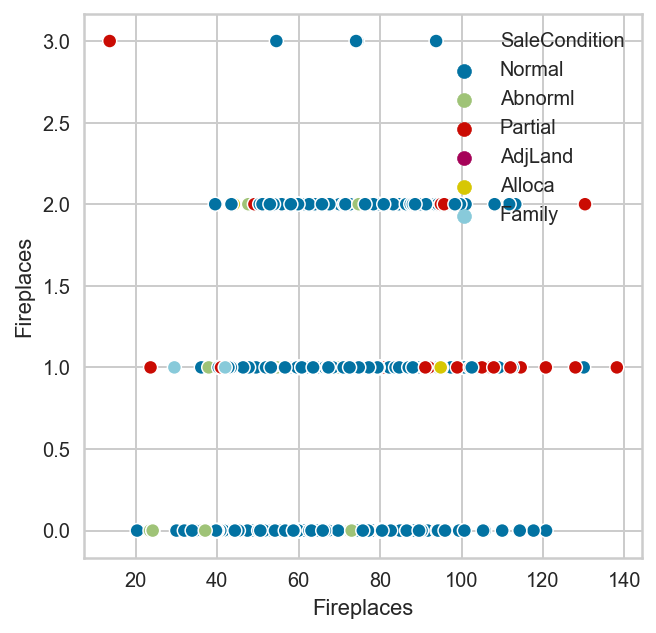

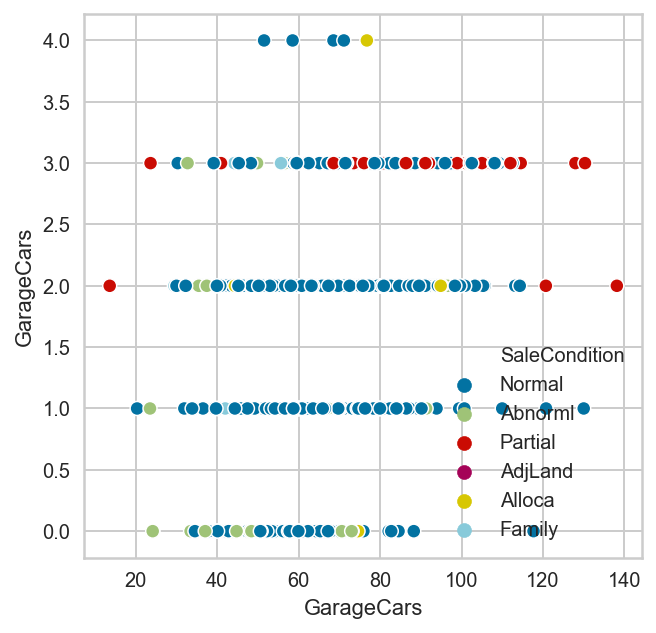

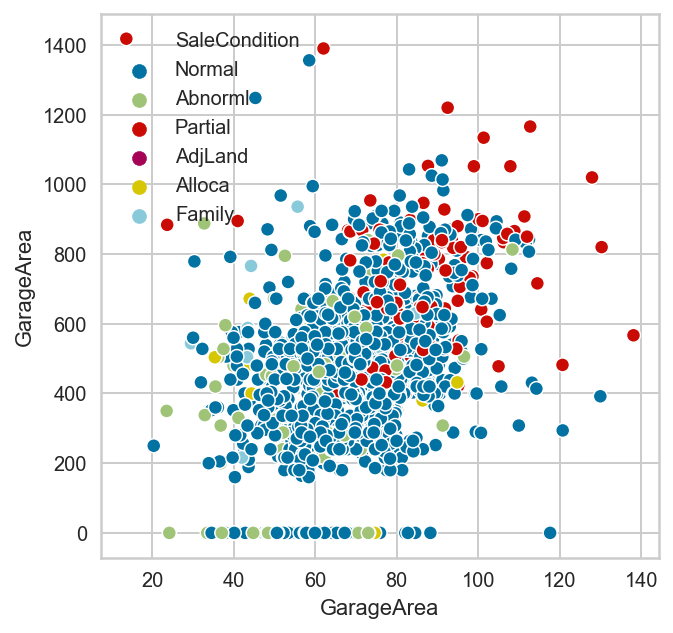

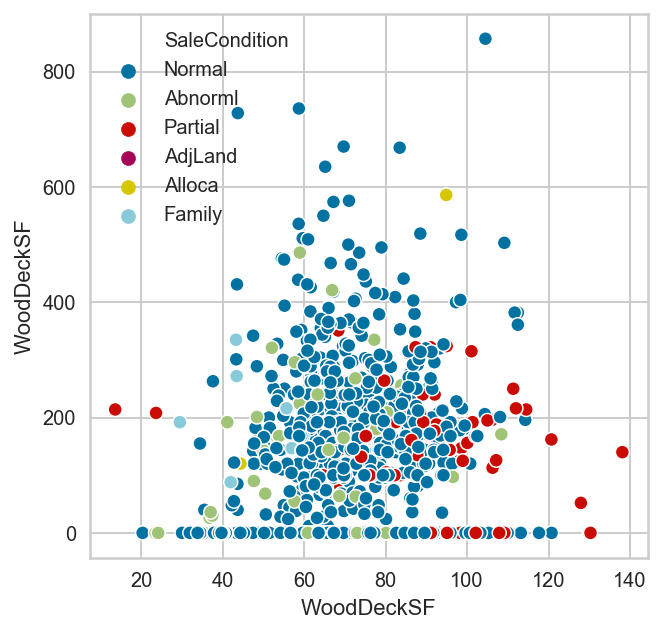

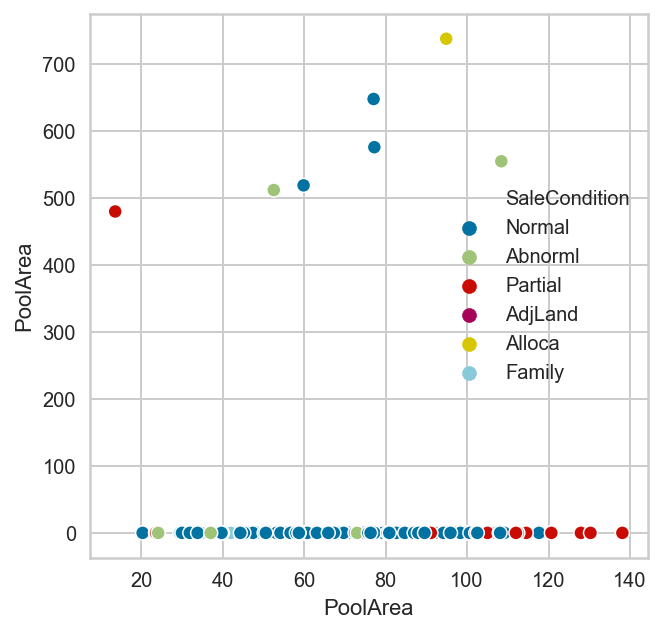

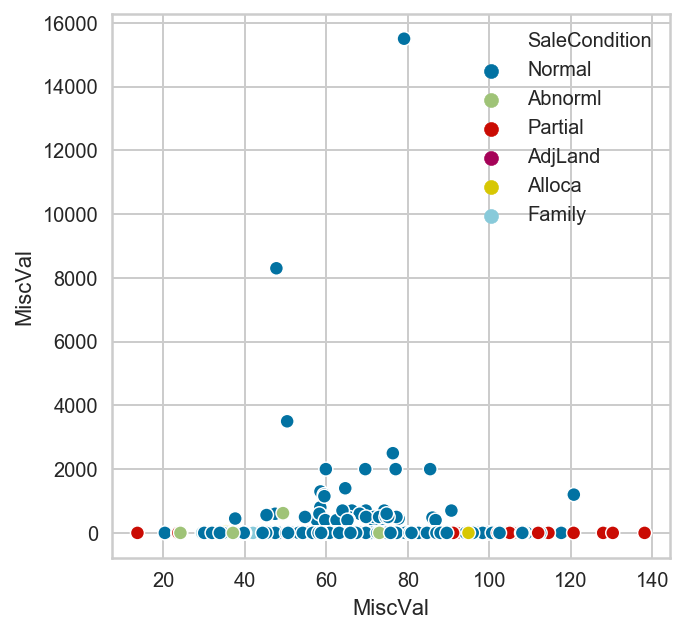

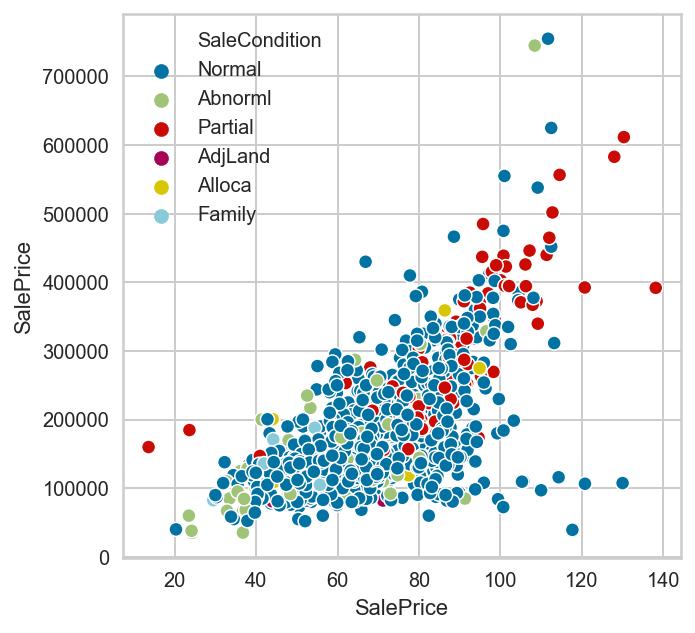

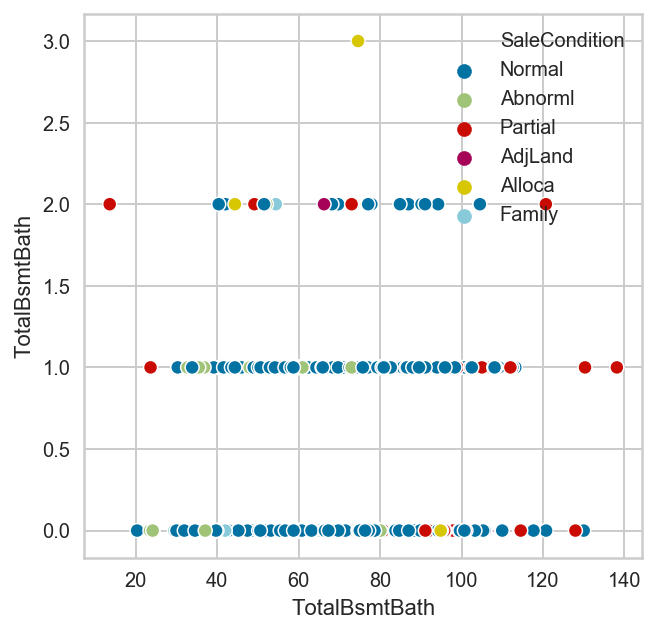

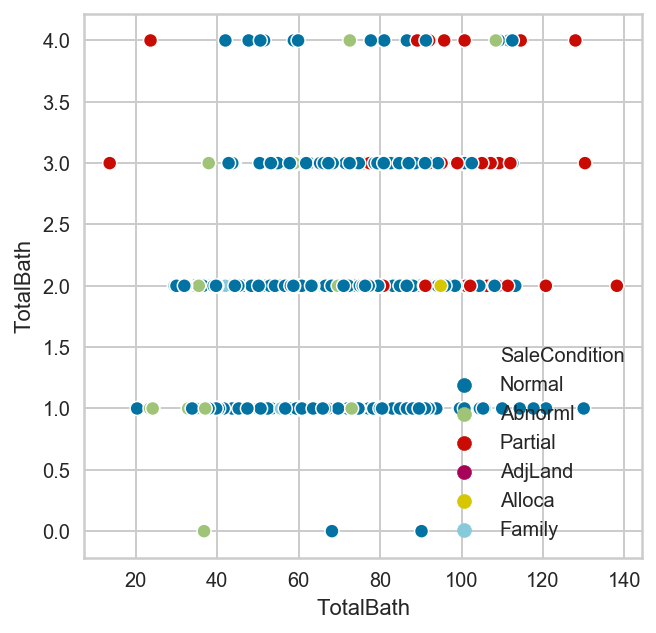

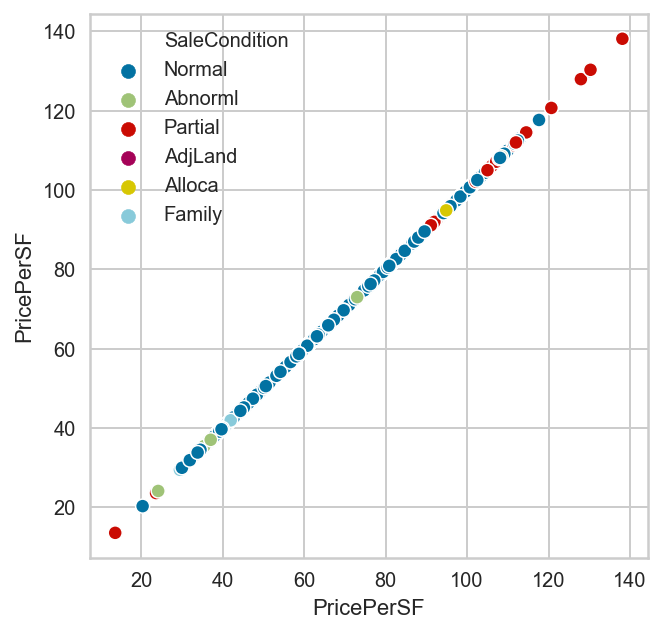

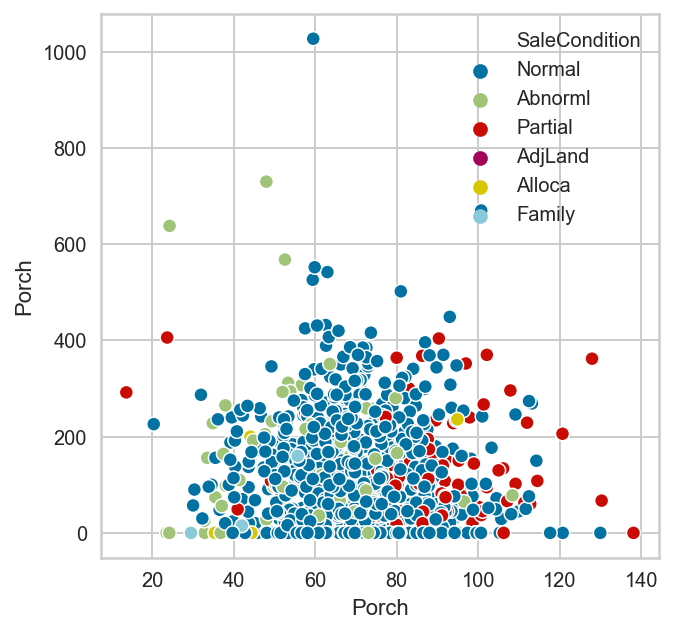

In [86]:
for col in house3.select_dtypes(exclude='object').columns.values:
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=house3['PricePerSF'],y=col, hue=house3['SaleCondition'], data=house3)
    plt.xlabel(col)
    plt.show()

We can see across all the numeric features, abnormal sale condition is very similar to family condition, therefore we can basically rule out all the numeric features as the classifier would not work properly

In [10]:
q3 = house3[numeric3]
q3[catq3] = house3[catq3]
q3 = q3.fillna(0)
q3 = pd.get_dummies(q3,drop_first=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [11]:
q3Y = house3['SaleCondition']
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(q3, q3Y)

for train_index, test_index in sss.split(q3, q3Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    q3_train, q3_test = q3.iloc[train_index,], q3.iloc[test_index,]
    q3Y_train, q3Y_test = q3Y.iloc[train_index,], q3Y.iloc[test_index,]

print(q3_train.shape)
print(q3Y_train.shape)
print(q3_train.columns)

(1168, 49)
(1168,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'PoolArea', 'MiscVal', 'SalePrice', 'TotalBsmtBath', 'TotalBath',
       'PricePerSF', 'Porch', 'ExterCond', 'ExterQual', 'FireplaceQu',
       'HeatingQC', 'KitchenQual', 'BsmtCond_2', 'BsmtCond_3', 'BsmtCond_4',
       'BsmtCond_None', 'BsmtQual_3', 'BsmtQual_4', 'BsmtQual_5',
       'BsmtQual_None', 'GarageCond_2', 'GarageCond_3', 'GarageCond_4',
       'GarageCond_5', 'GarageCond_None', 'GarageQual_2', 'GarageQual_3',
       'GarageQual_4', 'GarageQual_5', 'GarageQual_None'],
      dtype='object')


In [17]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
catBest = SelectKBest(mutual_info_classif, k=4).fit(q3_train, q3Y_train)
mask = catBest.get_support()
usefulcat = q3_train.iloc[:,mask].columns
print(usefulcat)

Index(['GarageCars', 'PricePerSF', 'HeatingQC', 'KitchenQual'], dtype='object')


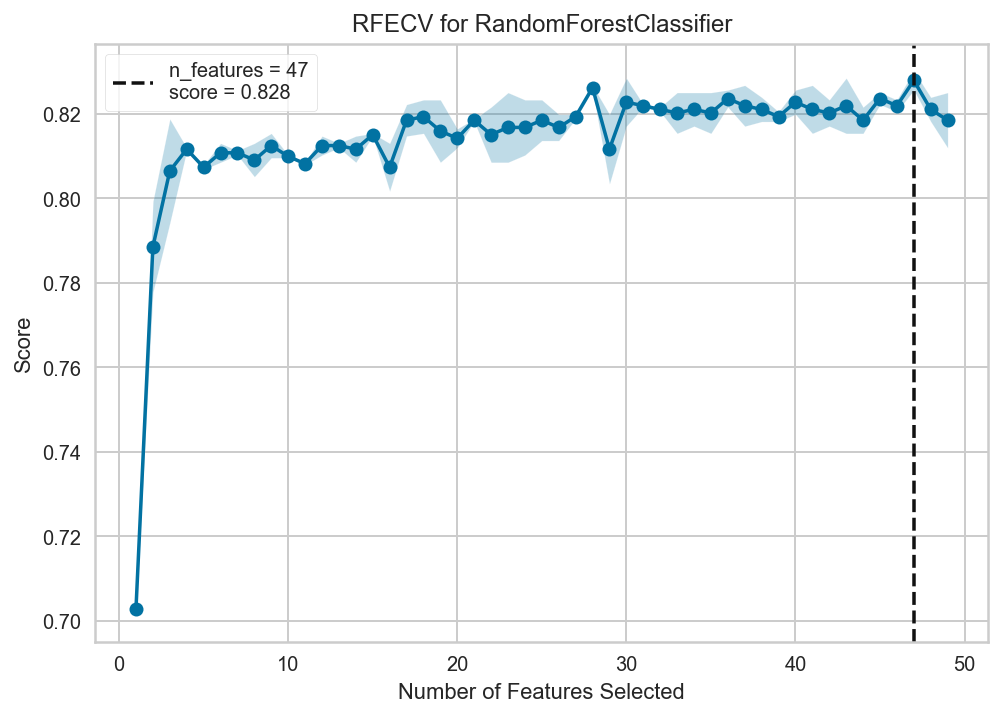

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True False
  True]
['MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'MasVnrArea' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd'
 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF' 'PoolArea' 'MiscVal'
 'SalePrice' 'TotalBsmtBath' 'TotalBath' 'PricePerSF' 'Porch' 'ExterCond'
 'ExterQual' 'FireplaceQu' 'HeatingQC' 'KitchenQual' 'BsmtCond_2'
 'BsmtCond_3' 'BsmtCond_4' 'BsmtCond_None' 'BsmtQual_3' 'BsmtQual_4'
 'BsmtQual_5' 'BsmtQual_None' 'GarageCond_2' 'GarageCond_3' 'GarageCond_4'
 'GarageCond_None' 'GarageQual_2' 'GarageQual_3' 'GarageQual_4'
 'GarageQual_None']


In [14]:
### use decisiontree regressor to do feature selections
from sklearn.model_selection import StratifiedKFold
from yellowbrick.features import RFECV
from sklearn.ensemble import RandomForestClassifier

viz = RFECV(RandomForestClassifier(n_estimators=100),cv=StratifiedKFold(2))
viz.fit(q3_train, q3Y_train)
viz.poof()
print(viz.get_support())
fs = q3_train.iloc[:,viz.get_support()].columns.values
print(fs)

In [15]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.features import RFECV
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(q3_train[fs], q3Y_train)
q3_pred = model.predict(q3_test[fs])
unique, counts = np.unique(q3_pred, return_counts=True)
print(dict(zip(unique, counts)))
len(q3_test)

{'Abnorml': 2, 'Normal': 272, 'Partial': 18}


292

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knntrain = usefulcat.values
m2_train = q3_train[knntrain]
print(m2_train.shape)
m2_test = q3_test[knntrain]
print(m2_test.shape)

(1168, 4)
(292, 4)


In [19]:
modela = KNeighborsClassifier()

In [20]:
modela.fit(m2_train, q3Y_train)
q3_pred2 = modela.predict(m2_test)
unique, counts = np.unique(q3_pred2, return_counts=True)
print(dict(zip(unique, counts)))
len(q3_test)

{'Abnorml': 4, 'Alloca': 2, 'Normal': 271, 'Partial': 15}


292

In [21]:
modela.score(m2_test, q3Y_test)

0.8013698630136986

In [23]:
labels = house3['SaleCondition'].value_counts().index.values
labels

array(['Normal', 'Partial', 'Abnorml', 'Family', 'Alloca', 'AdjLand'],
      dtype=object)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(q3Y_test, q3_pred, labels=labels)

array([[231,   7,   2,   0,   0,   0],
       [ 14,  11,   0,   0,   0,   0],
       [ 20,   0,   0,   0,   0,   0],
       [  4,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0]])

In [25]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
unique_labels(q3Y_test, q3_pred)

array(['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'],
      dtype='<U7')

Confusion matrix, without normalization
[[  0   0   0   0  20   0]
 [  0   0   0   0   1   0]
 [  0   0   0   0   2   0]
 [  0   0   0   0   4   0]
 [  2   0   0   0 231   7]
 [  0   0   0   0  14  11]]


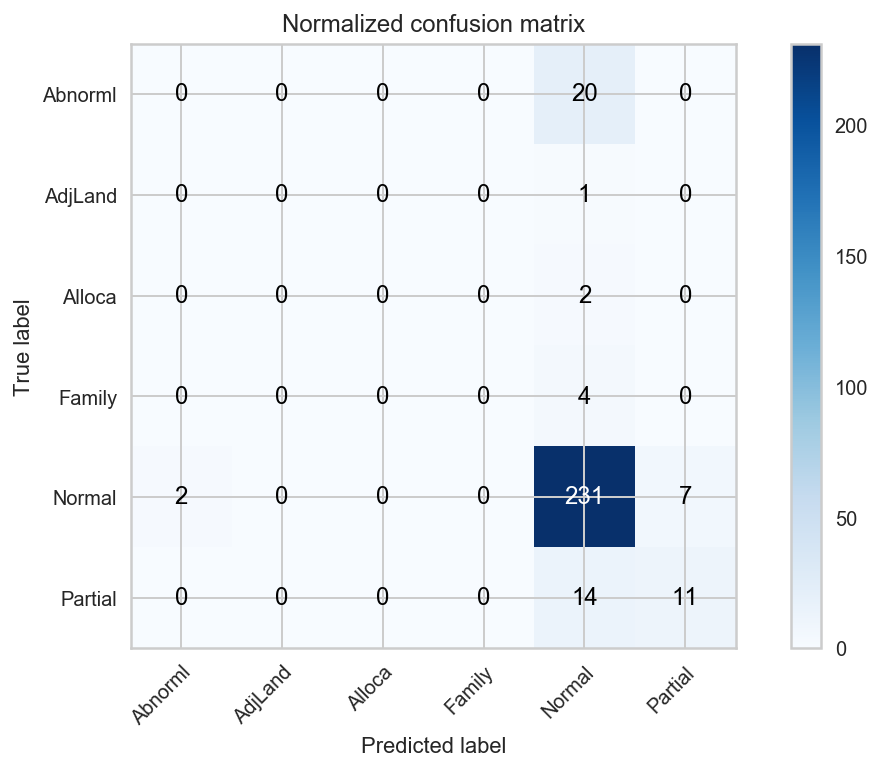

In [26]:
plot_confusion_matrix(q3Y_test, q3_pred, normalize=False,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[  1   0   0   0  19   0]
 [  0   0   0   0   1   0]
 [  0   0   0   0   2   0]
 [  0   0   1   0   3   0]
 [  3   0   1   0 227   9]
 [  0   0   0   0  19   6]]


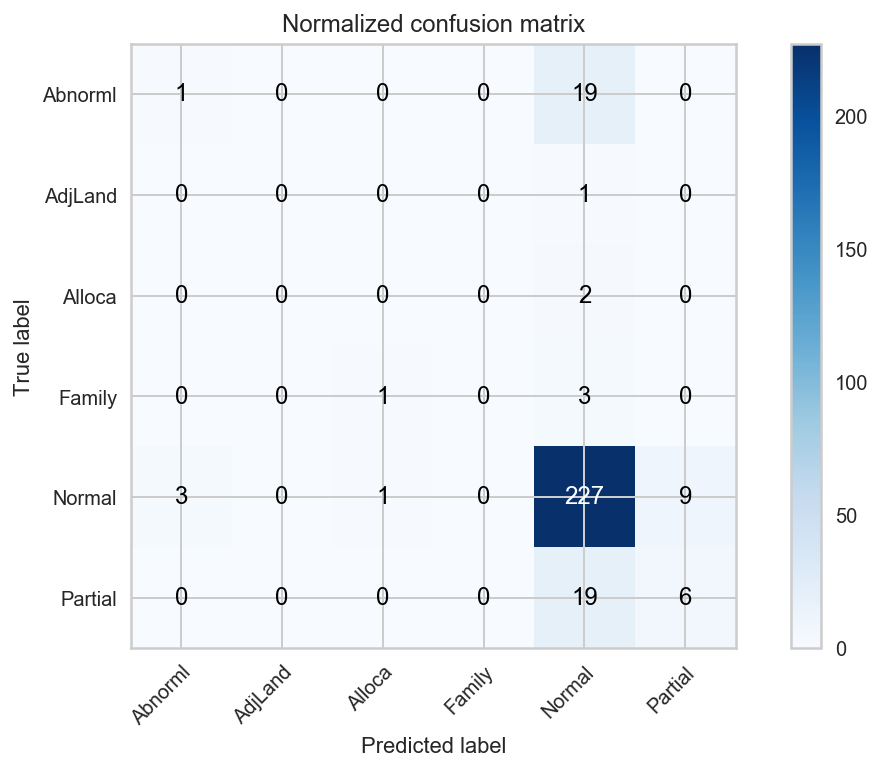

In [27]:
plot_confusion_matrix(q3Y_test, q3_pred2, normalize=False,
                      title='Normalized confusion matrix')

plt.show()

## Answer to Q3
The prediction models for abnormal sale condition are unreliable. I have searched for strategy to mitigate the underpresentation of the abnormal class however options are limited. Randon forest is considered an good options to deal with imbalanced classes however it has perform not much better than KNN here. I have considered using creating synthetic samples yet from the EDA, it is clear that the abnormal class is very similar to other minorities classes. Therefore there is no clear strategy to create synthetic samples. 

Other ideas are:
* Over-sampling increases the number of minority class members in the training set. The advantage of over-sampling is that no information from the original training set is lost, as all observations from the minority and majority classes are kept. On the other hand, it is prone to overfitting.
* Under-sampling, on contrary to over-sampling, aims to reduce the number of majority samples to balance the class distribution. Since it is removing observations from the original data set, it might discard useful information.

Both strategy are not ideal as the full data set size is really limited and features to considered are a lot and many with high cardinality, therefore both these two strategy is not considered.

The overall conclusion is that from model selection and data sampling perspectives, predicting abnormal sale condition is very illusive.


In [30]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
clf = svm.SVC()

gamma_range = np.logspace(-5, 2, 10)
C_range = np.logspace(-3, 2, 10)

In [ ]:
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']
degree_range = [2,3,4]

param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range,degree=degree_range)

grid = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(q3_train, q3Y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# check the results of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]
grid_mean_scores[0:10]
plt.plot(np.linspace(-5,2,20), grid_mean_scores)

In [ ]:
# check the results of the grid search
print(grid.best_params_)
print(grid.best_score_)
best_svm = grid.best_estimator_